In [1]:
import os
os.chdir("..")

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from utils.models import MDN
from utils.data_module import RothfussDataModule, VoestDataModule, SyntheticDataModule, TrainingDataModule
from utils.train import train_model
from utils.evaluation_functions import make_to_pass_precomputed_variables
from tqdm import tqdm
import yaml
from torch.utils.tensorboard import SummaryWriter
import wandb
import matplotlib
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d

2024-02-15 12:59:35.047913: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 12:59:35.047949: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 12:59:35.049164: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-15 12:59:35.055670: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-15 12:59:35.904758: W tensorflow/compiler/tf2

{'a/b/c': 1, 'a/b/d': 2, 'a/e': 3, 'f': 4}


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
with open("configs/dummy_config_synthetic.yml", "r") as f:
        true_config = yaml.safe_load(f)

In [5]:
training_hyperparameters = true_config["training_hyperparameters"]
model_hyperparameters = true_config["model_hyperparameters"]

In [6]:
#dm = SyntheticDataModule("datasets/simulated_data/gmm_10_10000/gmm_10_10000")
dm = RothfussDataModule(dataset_name="concrete", data_path="datasets/rothfuss_datasets/", pre_normalize_mean_absolute_response=True, validation_is_test=True)

if not dm.has_distribution():
    training_hyperparameters["evaluation_function_names"] = []

training_dm = TrainingDataModule(dm.train_dataset, dm.val_dataset)
model = MDN(training_dm, **model_hyperparameters).to(device)
summary_writer = SummaryWriter(
        os.path.join("runs", "test_project")
    )
wandb.init(
        project="project_name",
        config=true_config,
        name="run_name",
        group="group_name",
        dir=os.path.join("runs", "project_name"),
        mode="disabled",
    )

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [7]:
best_params, val_metrics = train_model(
    model,
    training_dm,
    **training_hyperparameters,
    device=device,
    summary_writer=summary_writer
)

val_nll_loss: -0.42237308256087763:  17%|█▋        | 25/150 [00:02<00:11, 10.58it/s]

Early stopping


In [8]:
model.load_state_dict(best_params)

<All keys matched successfully>

In [20]:
finer_factor = 10
conformal_p = 0.90
has_true_distribution = dm.has_distribution()
draw_plot = True

  0%|          | 0/3 [00:00<?, ?it/s]

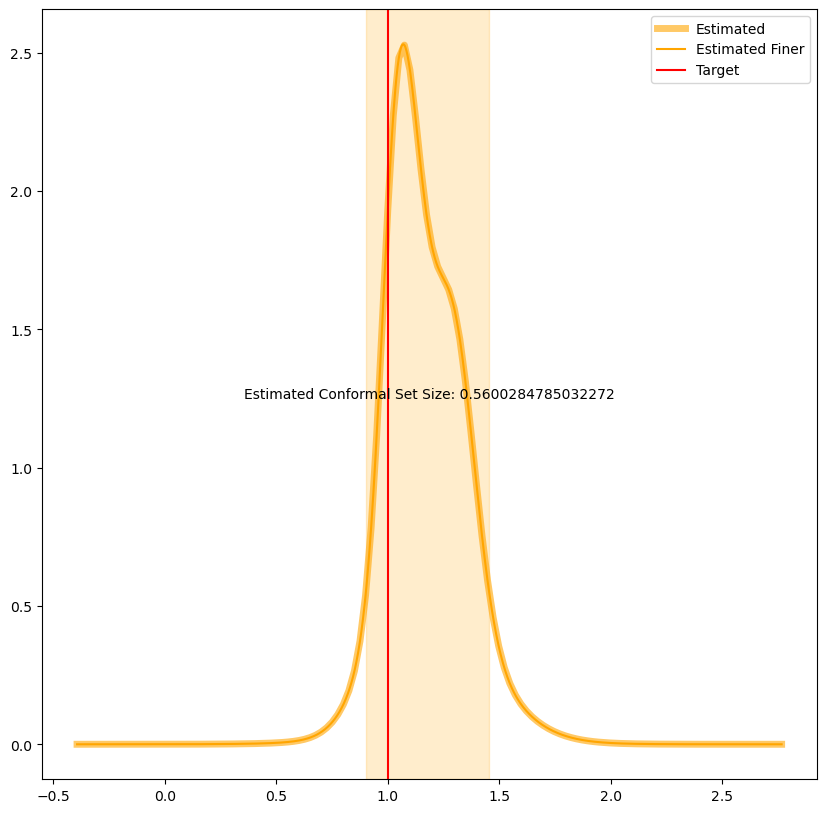

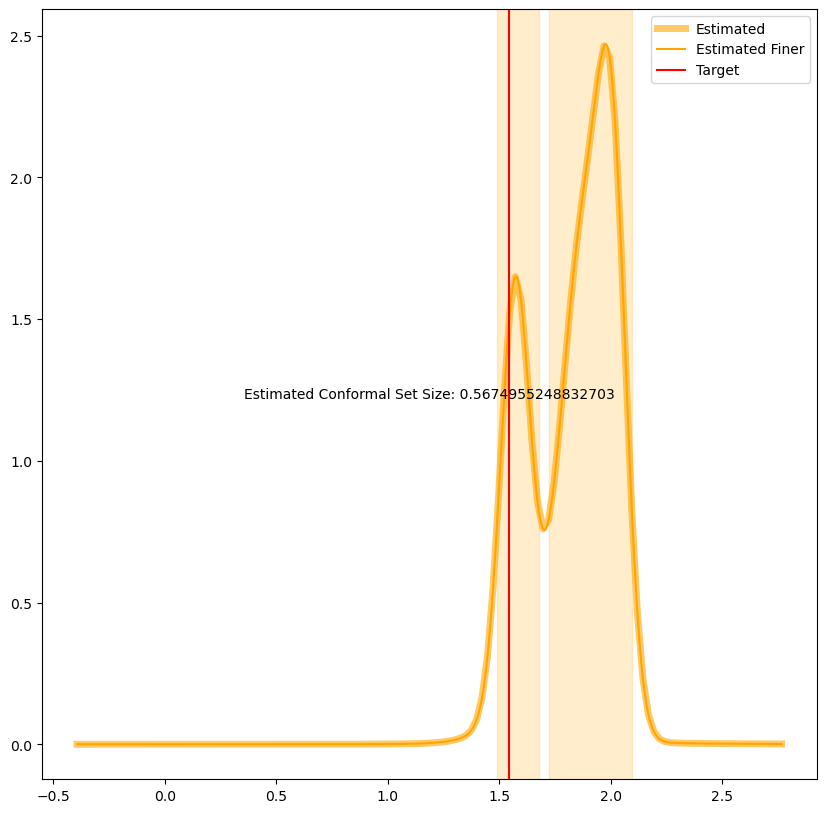

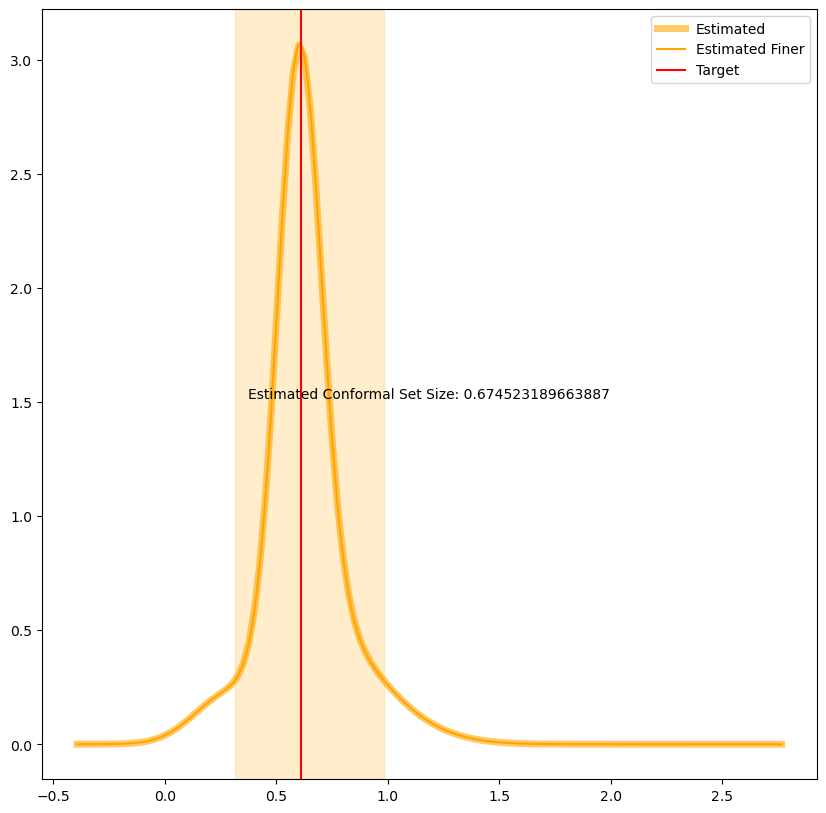

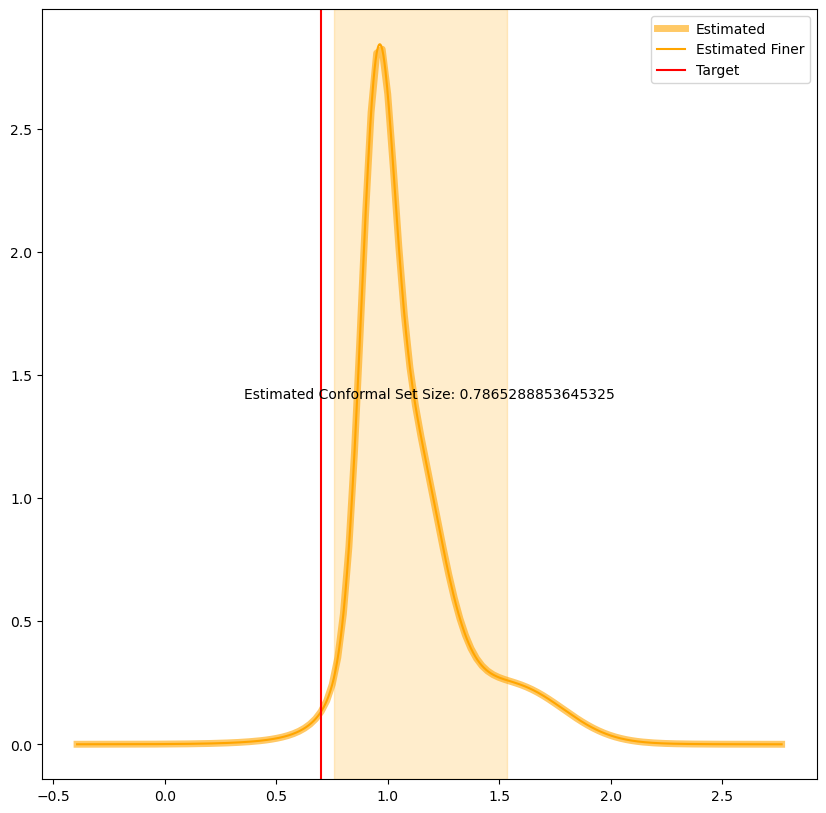

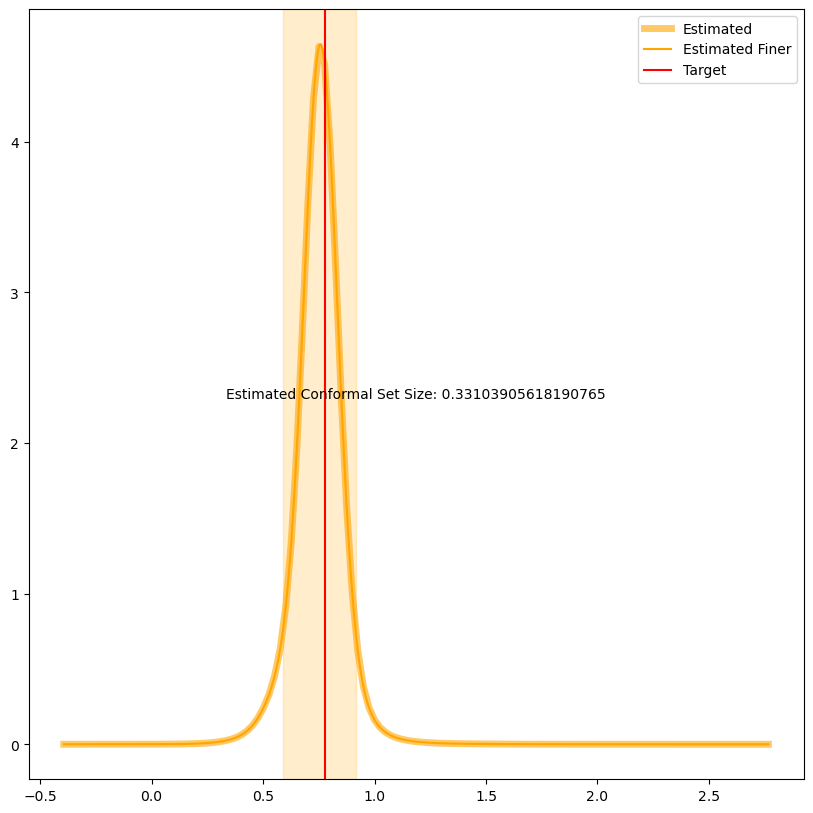

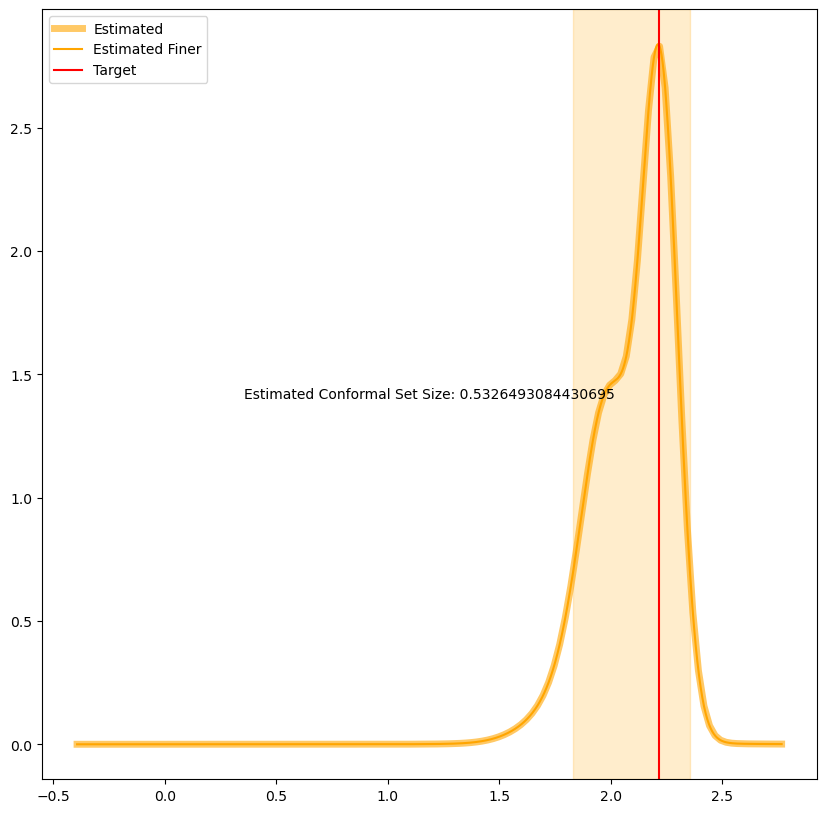

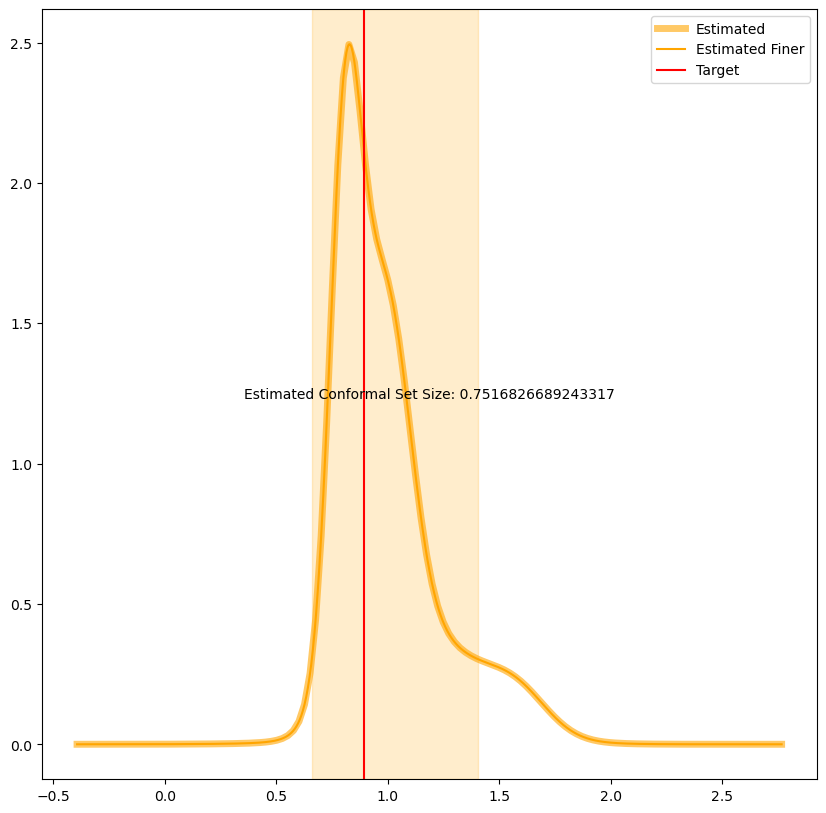

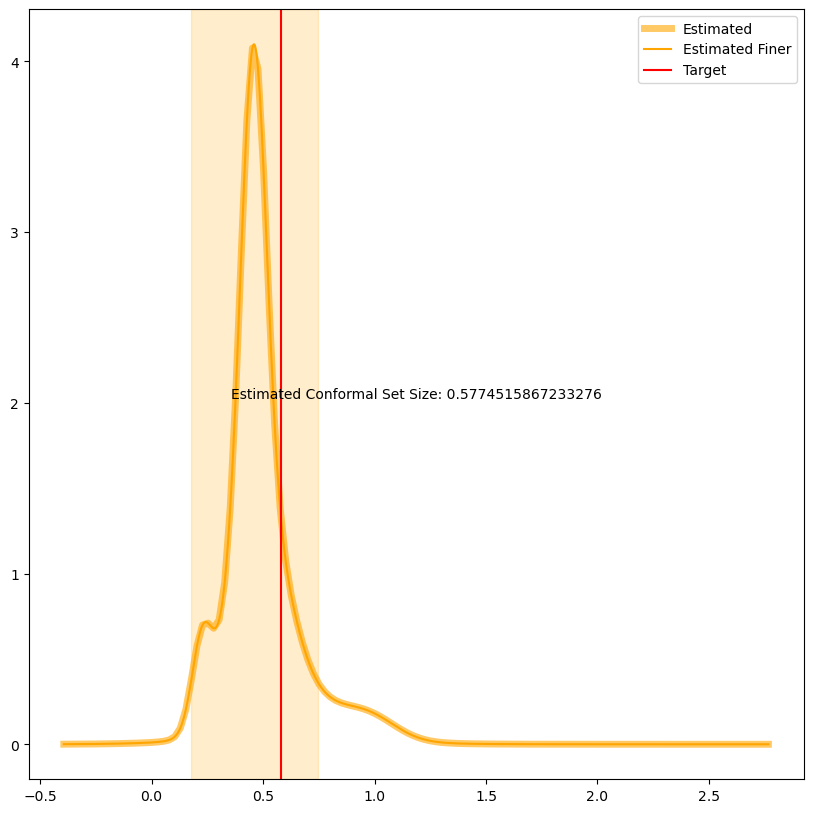

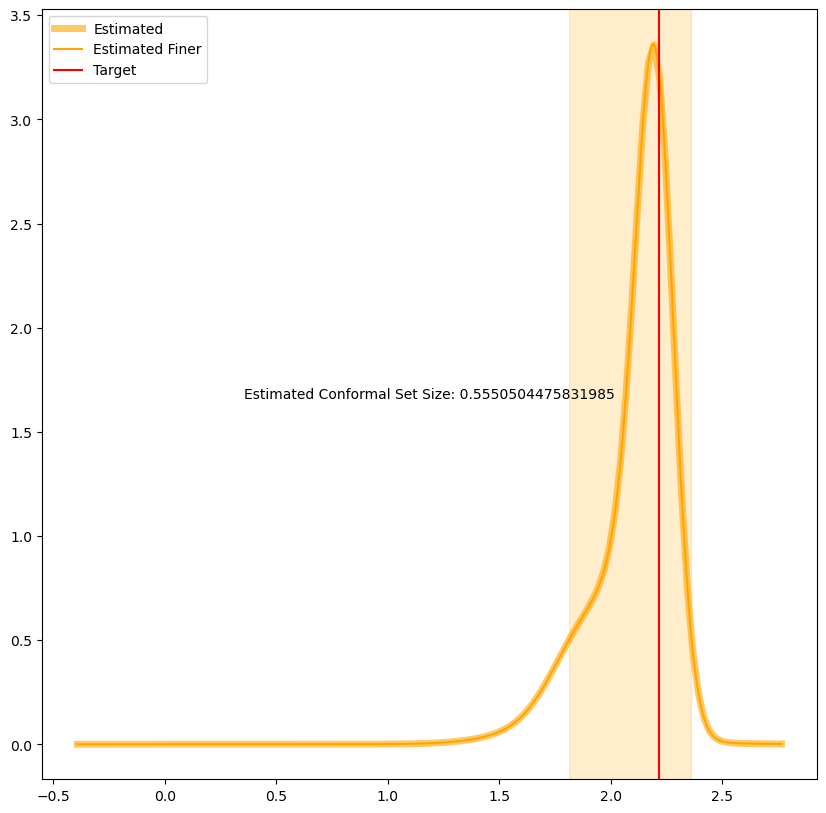

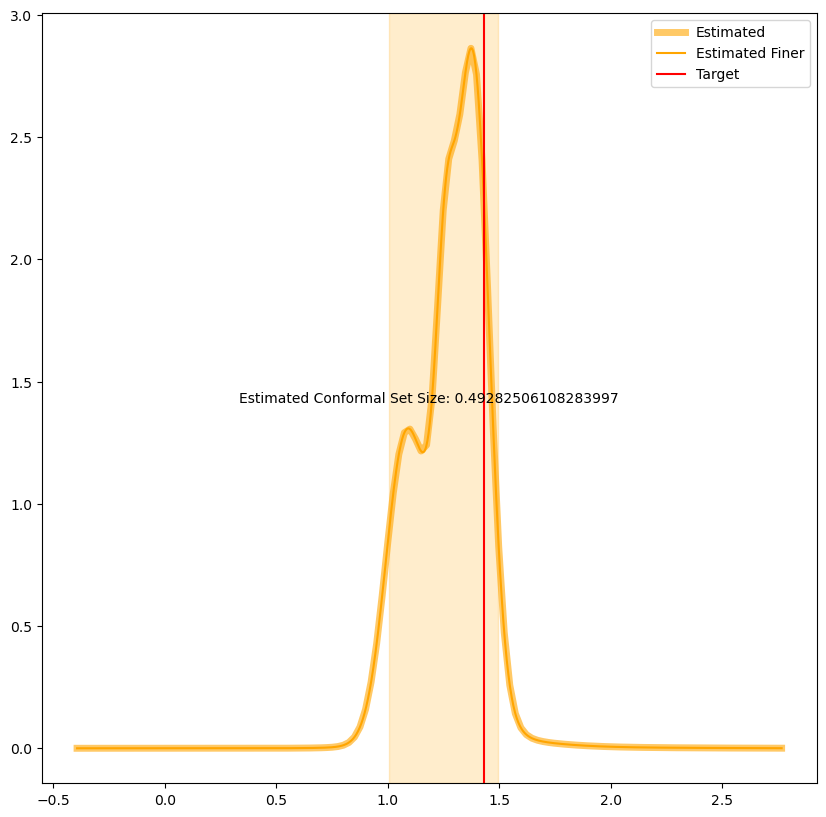

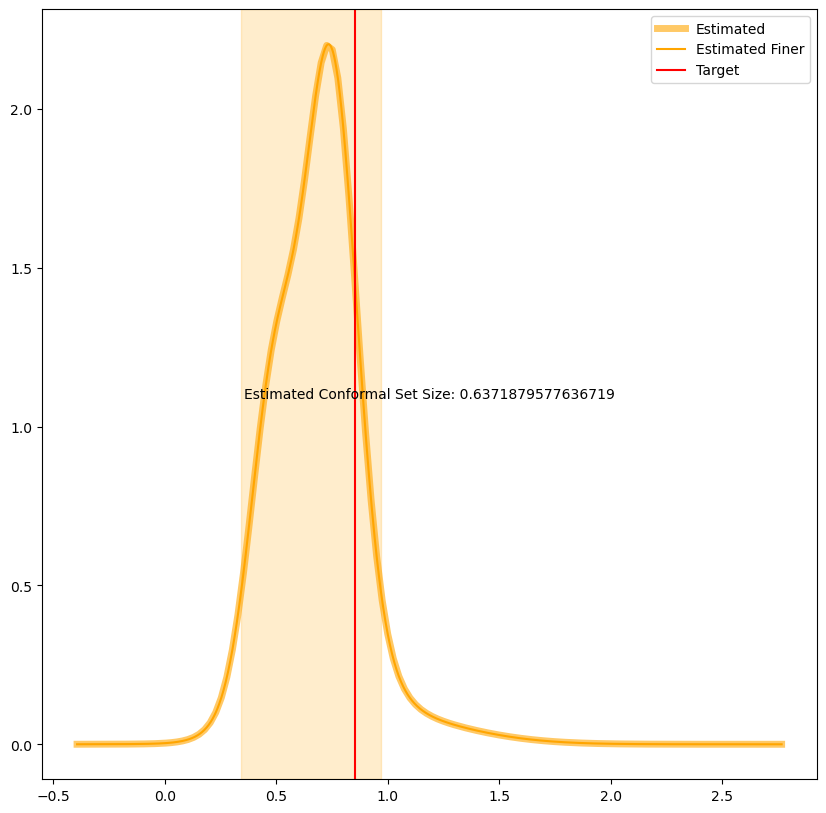

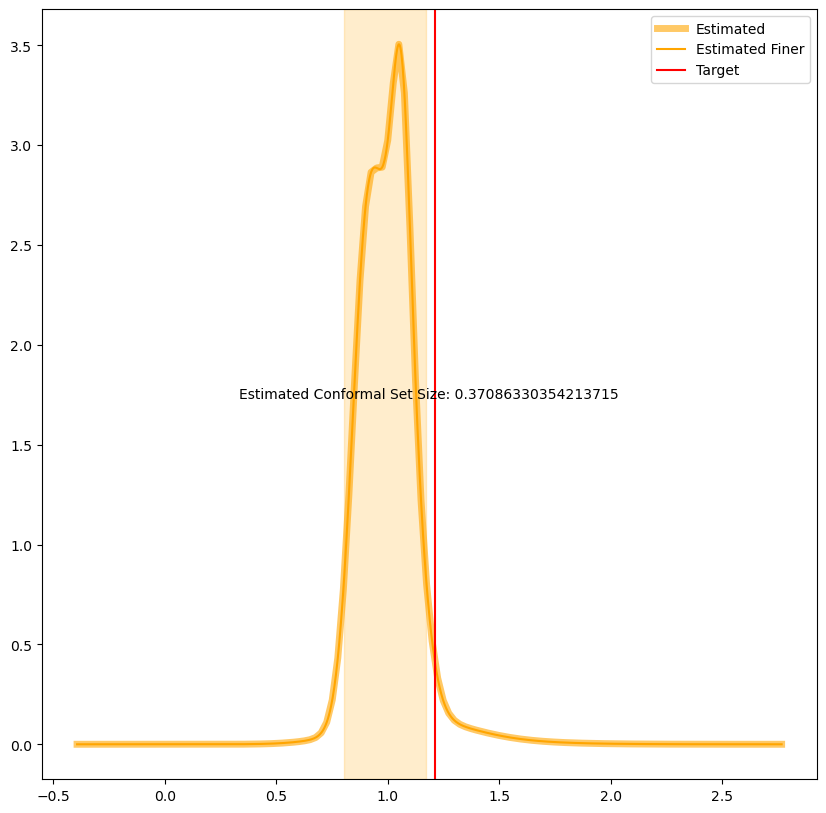

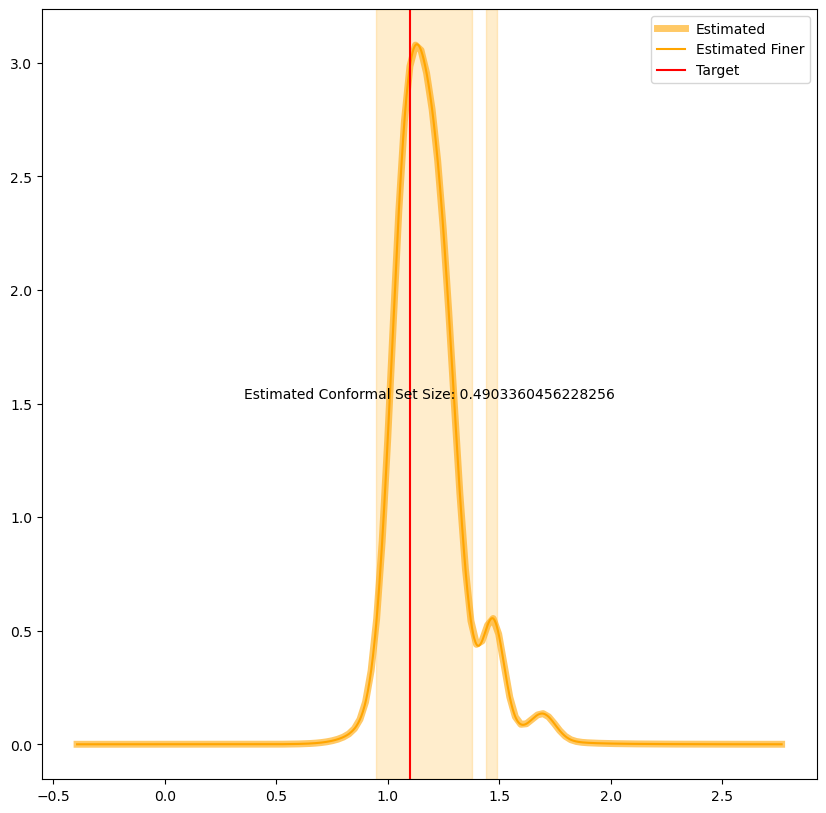

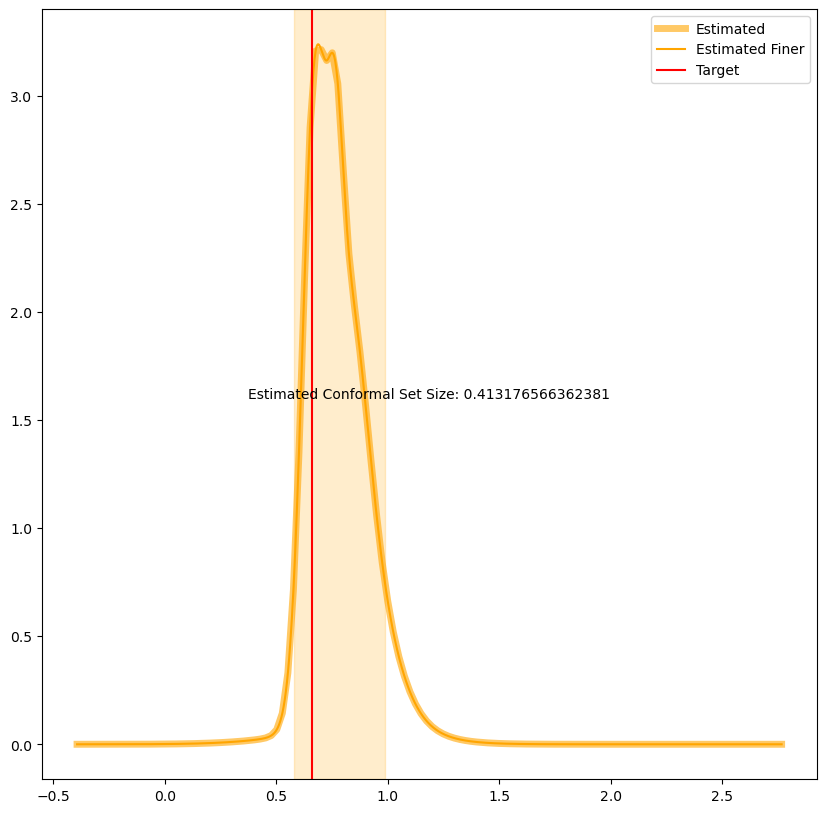

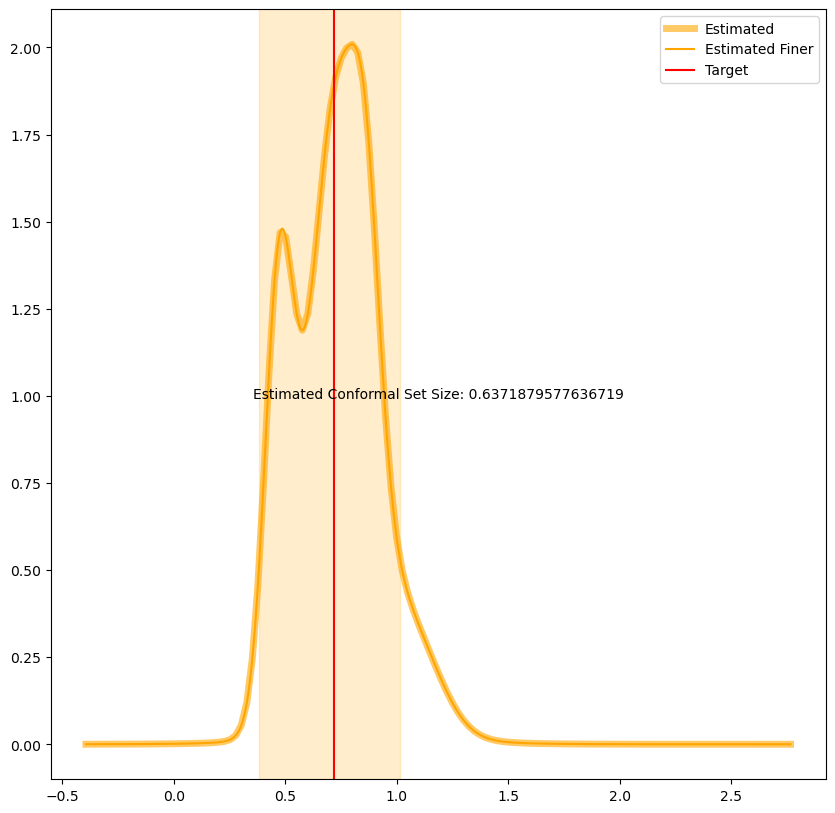

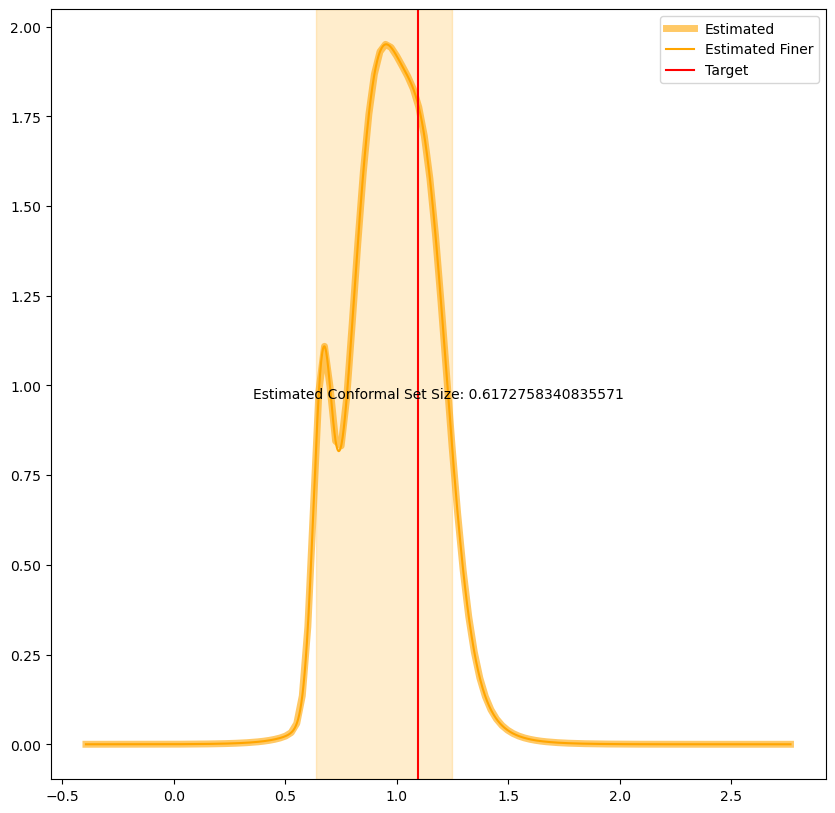

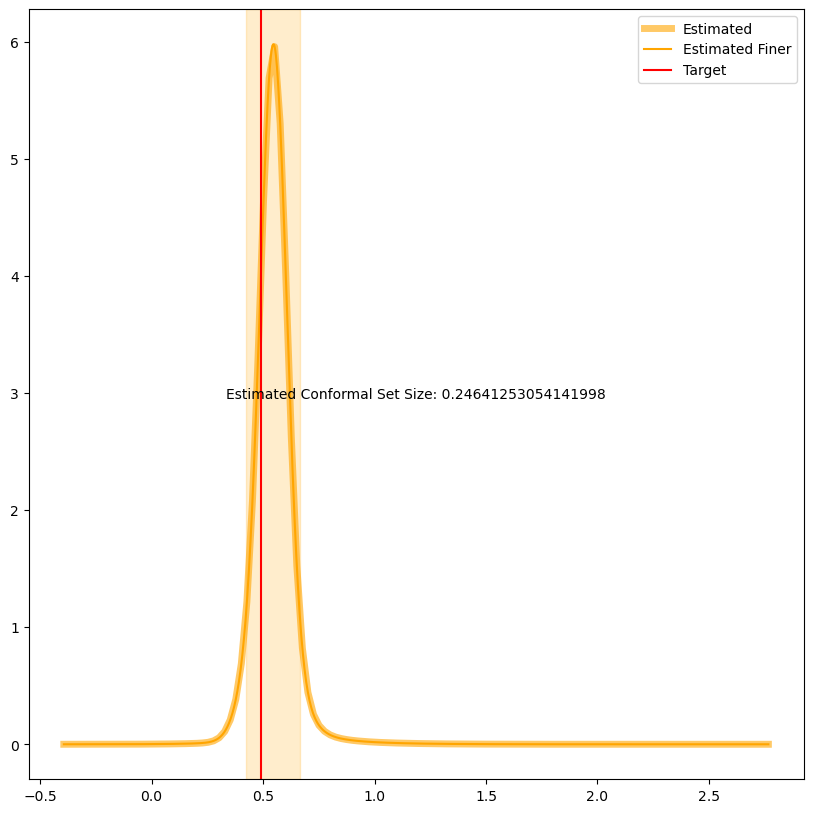

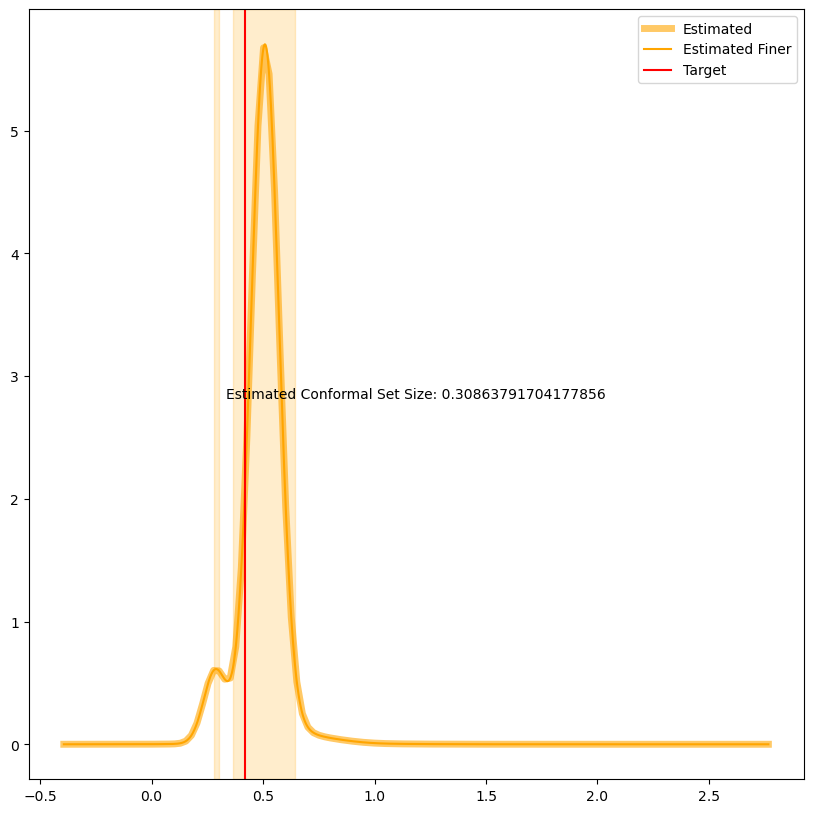

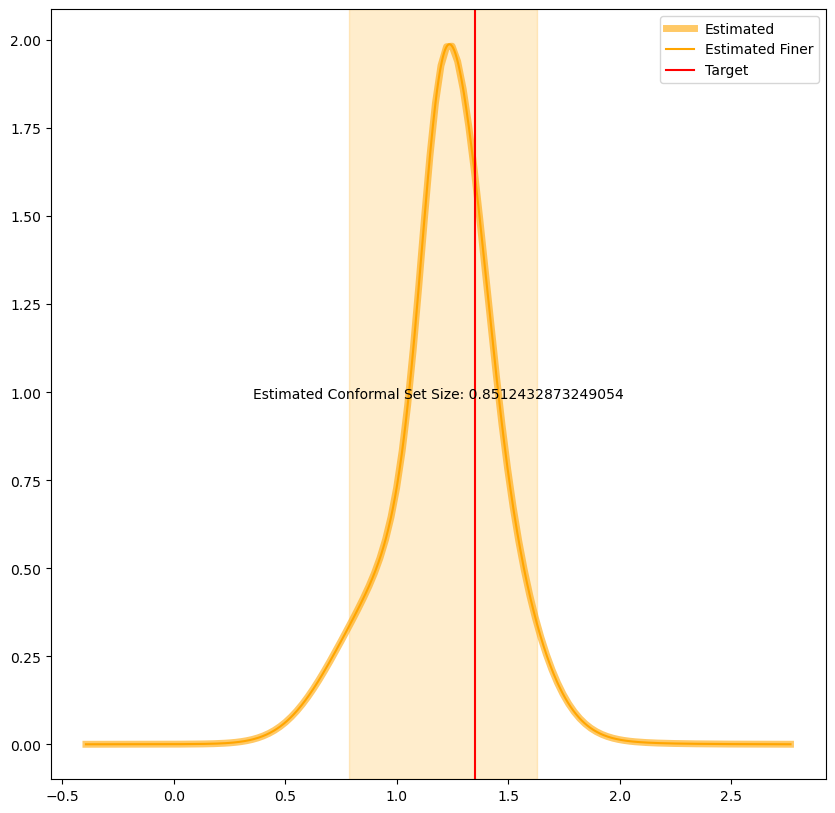

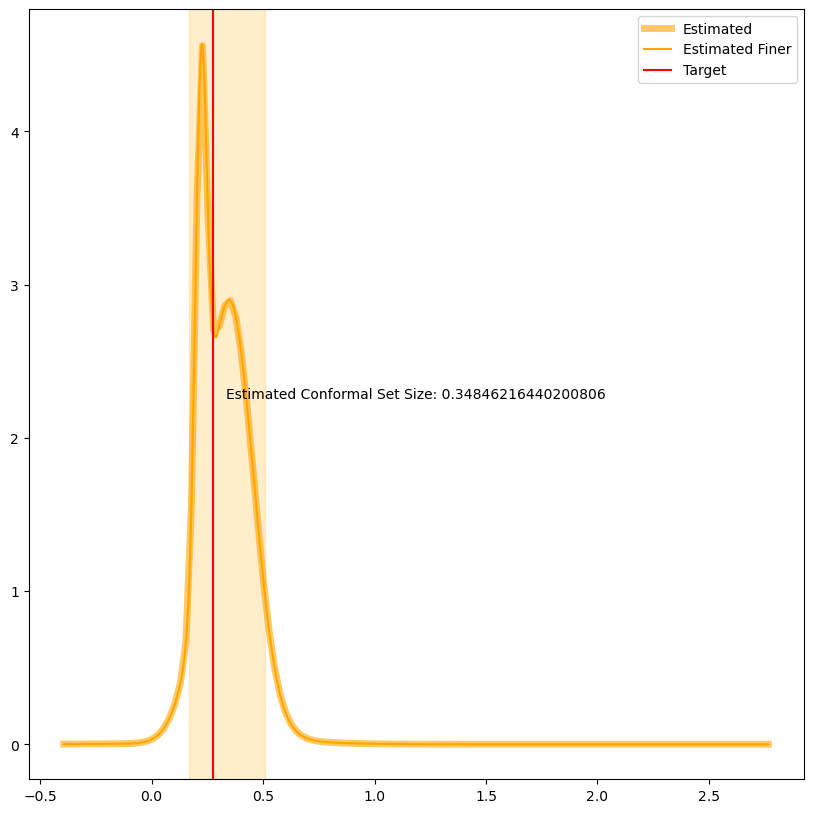

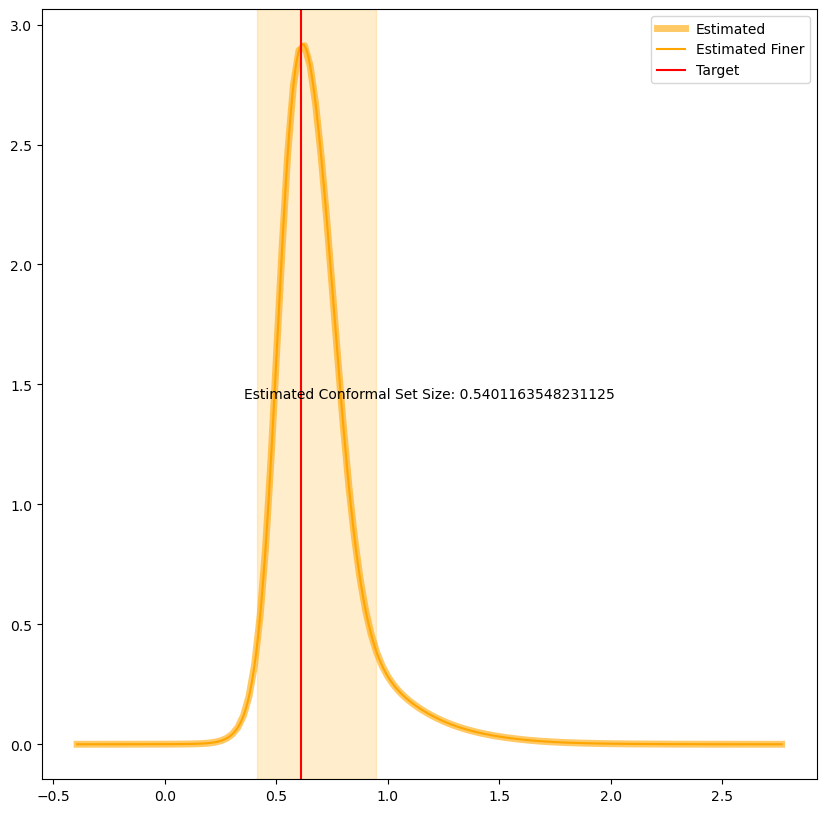

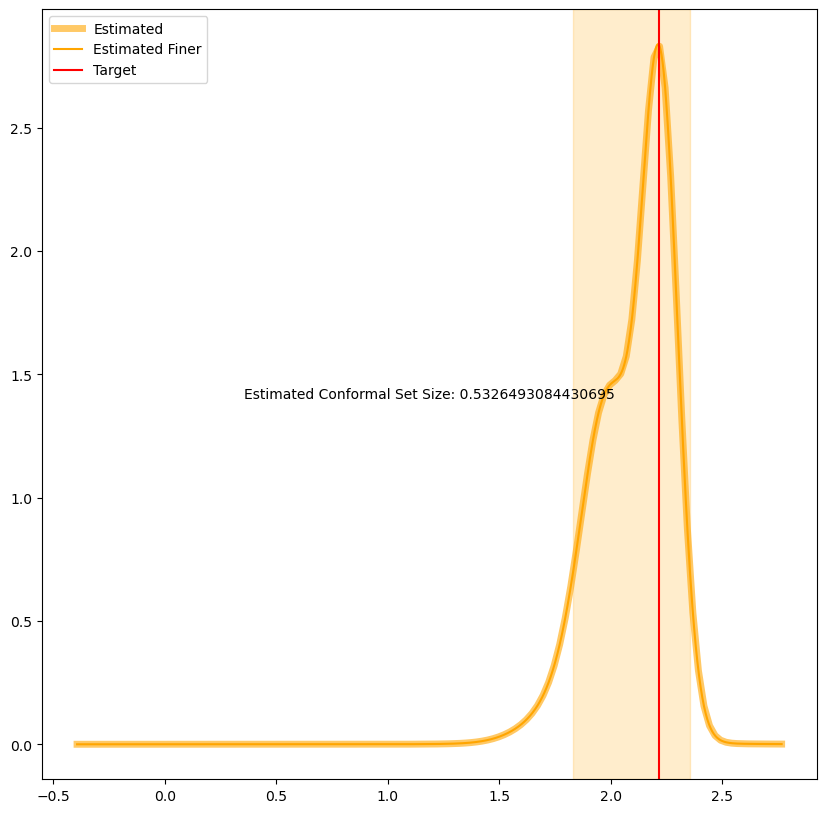

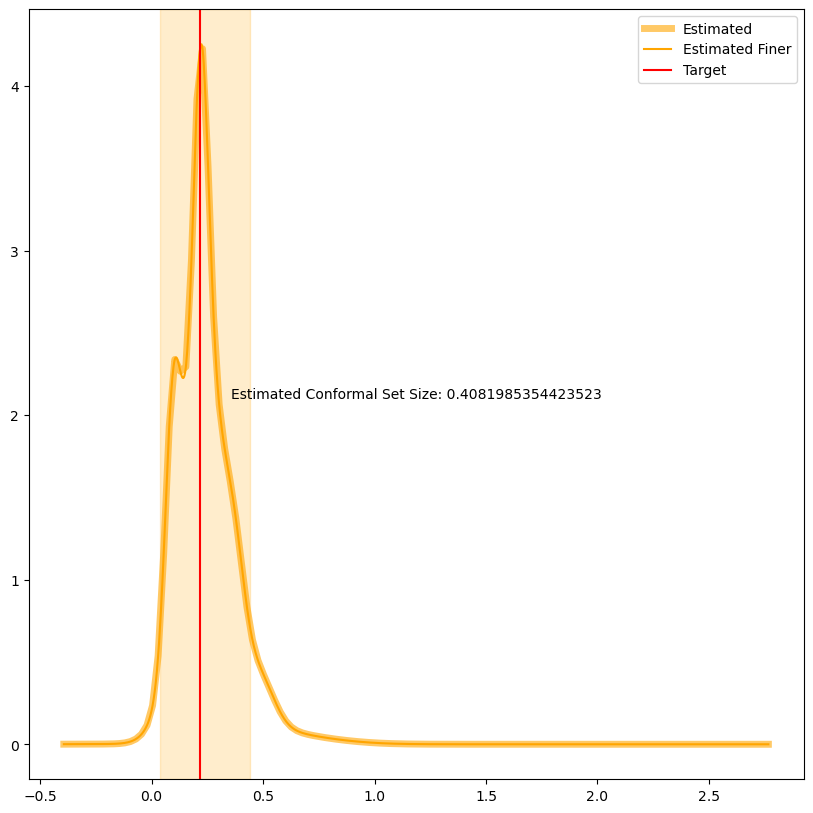

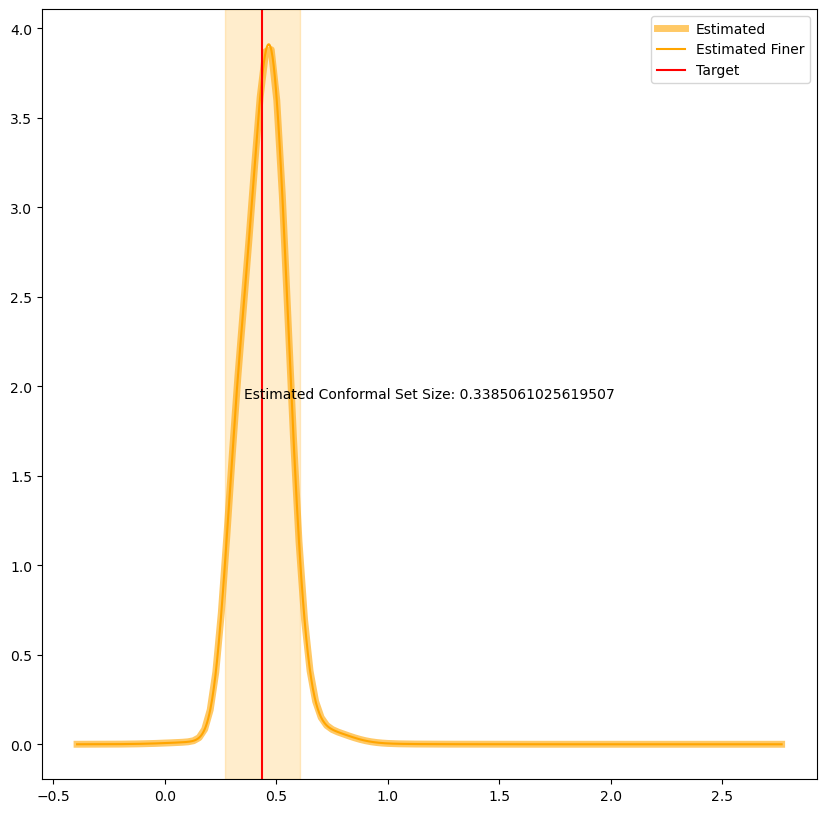

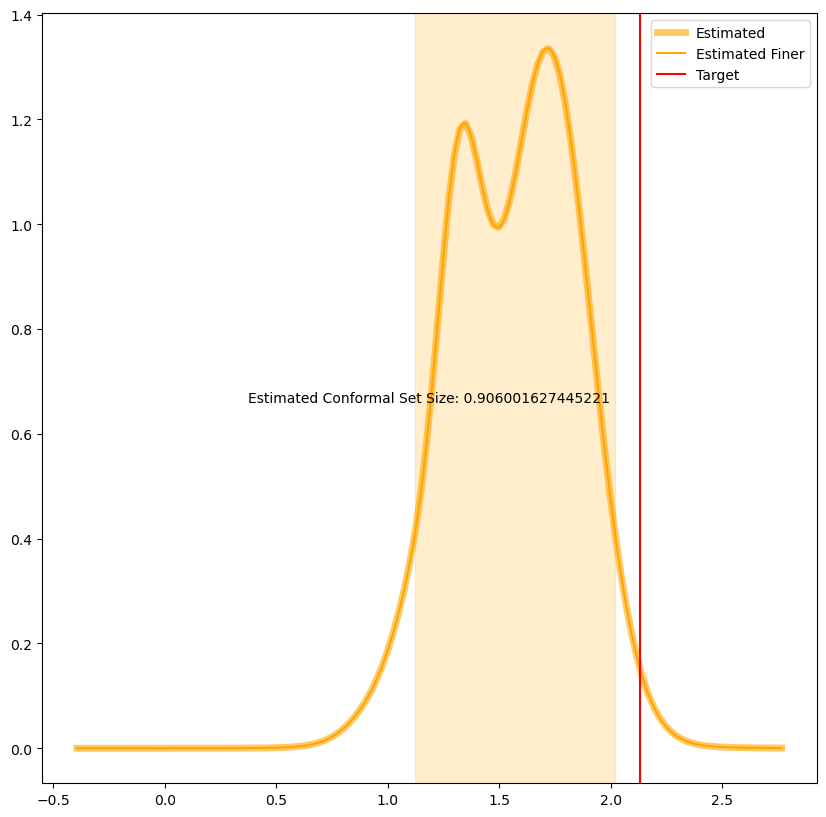

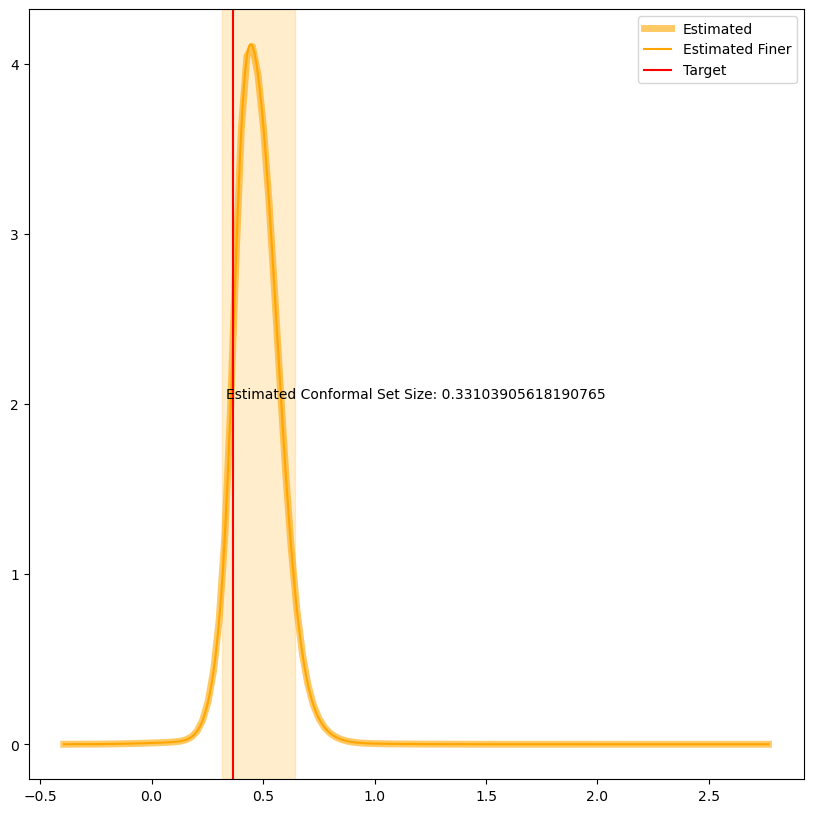

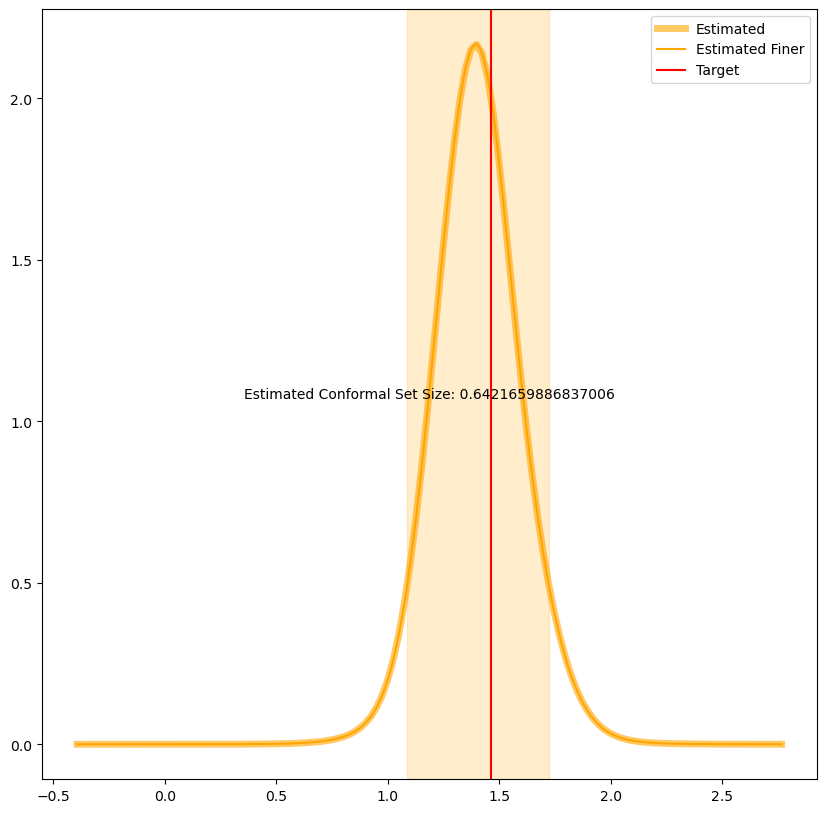

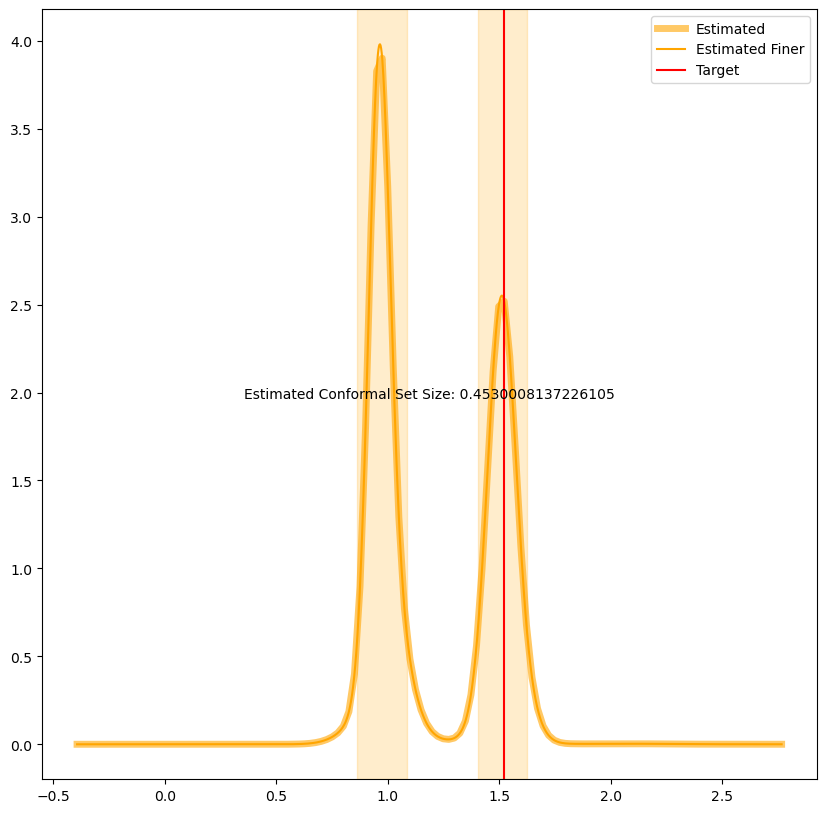

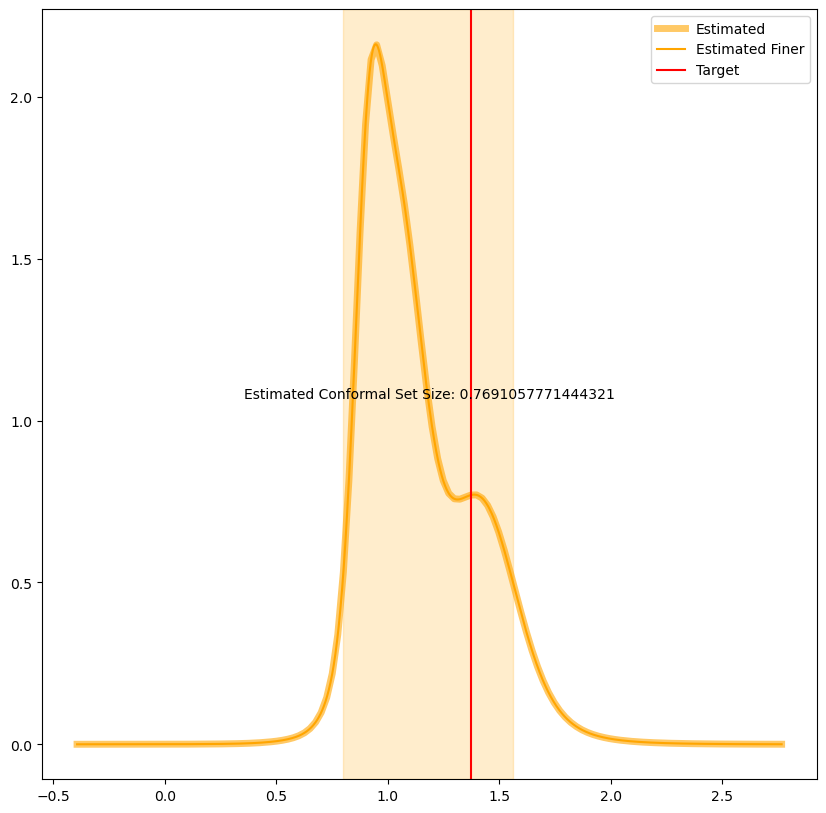

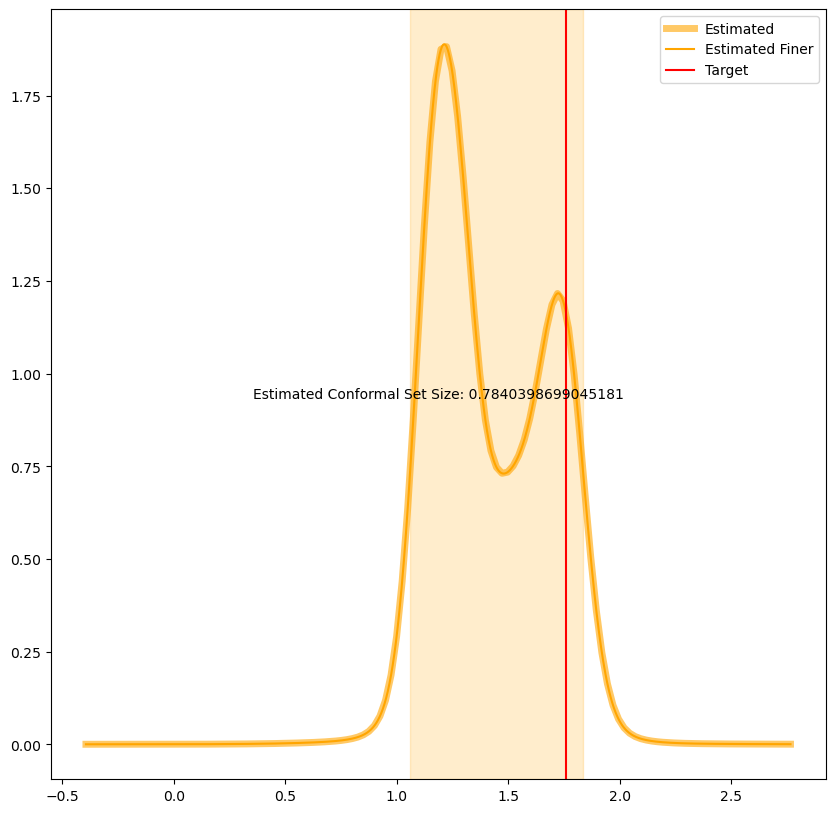

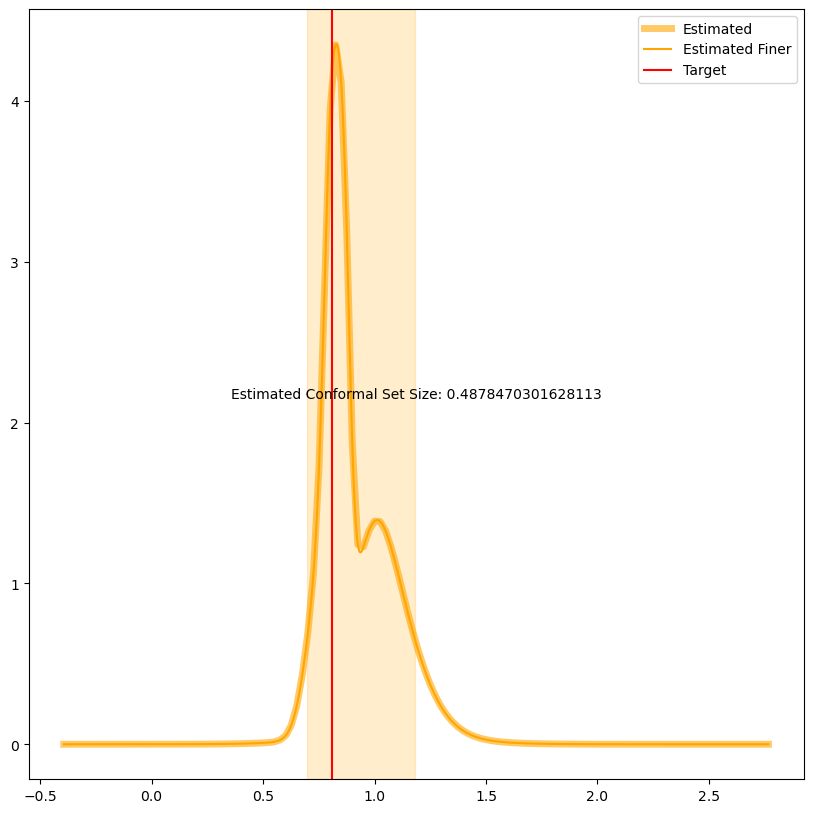

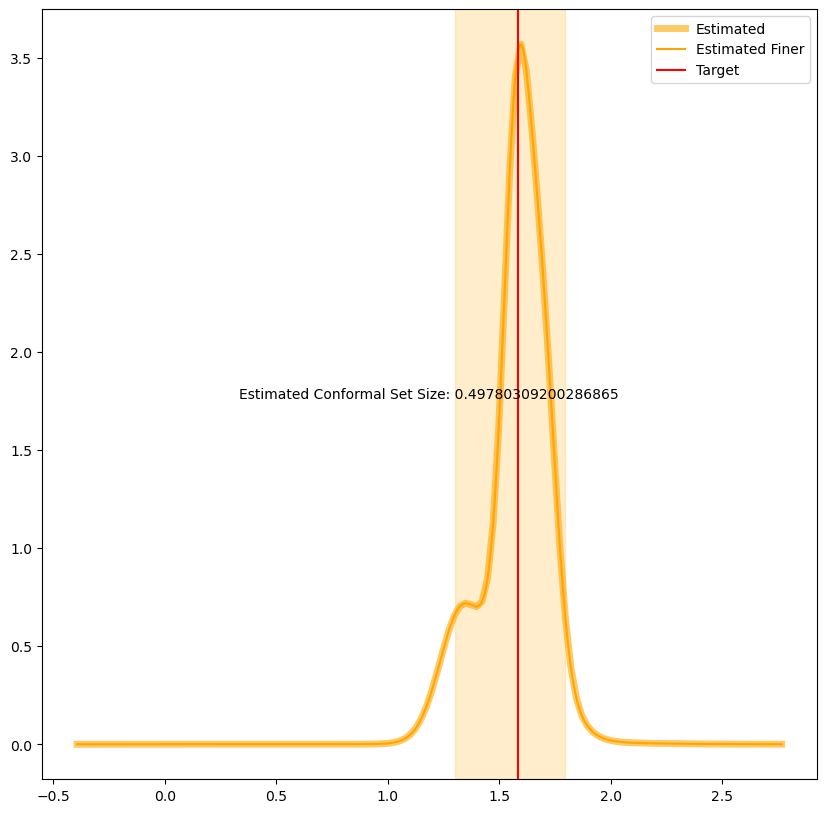

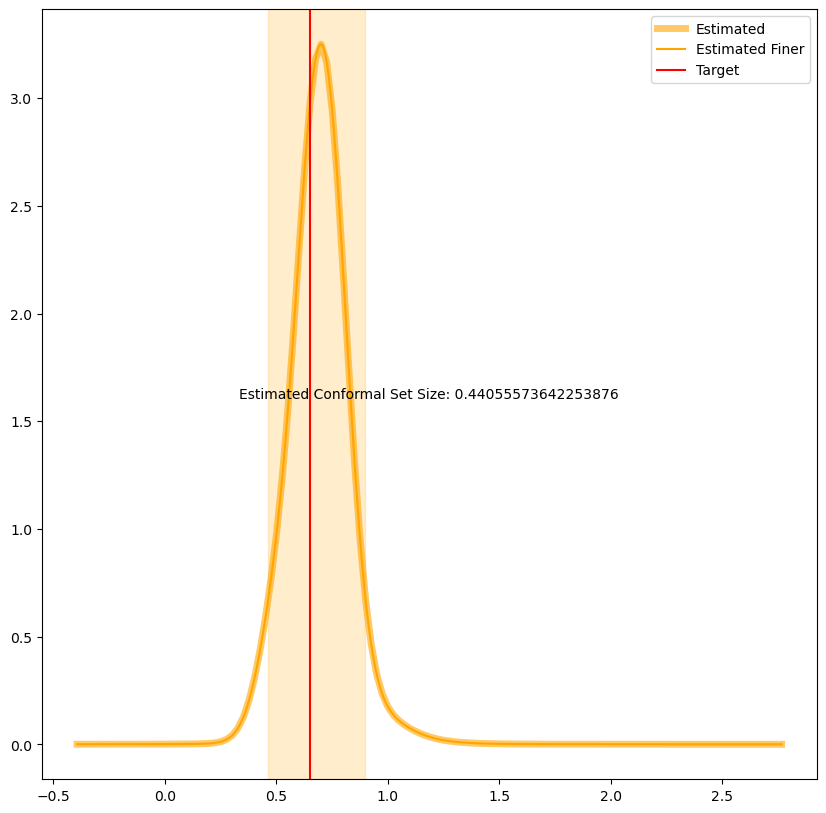

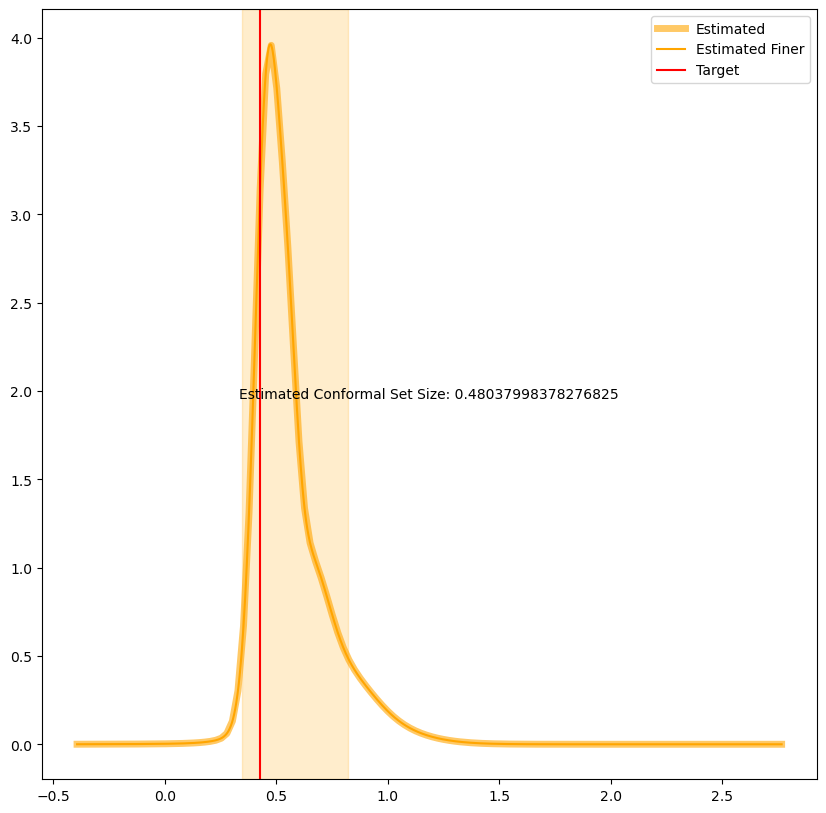

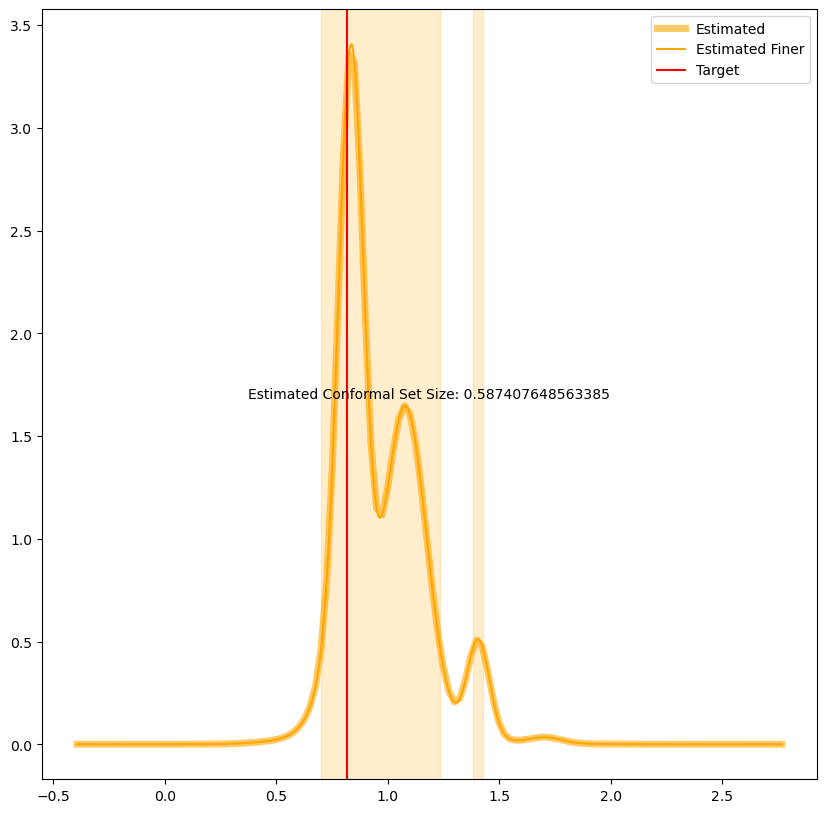

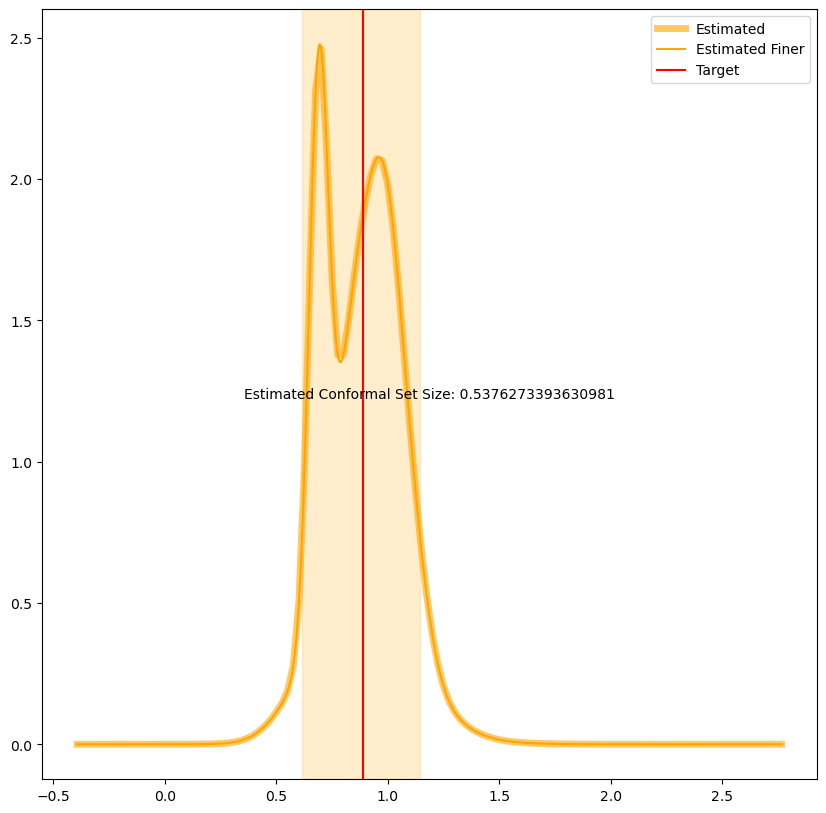

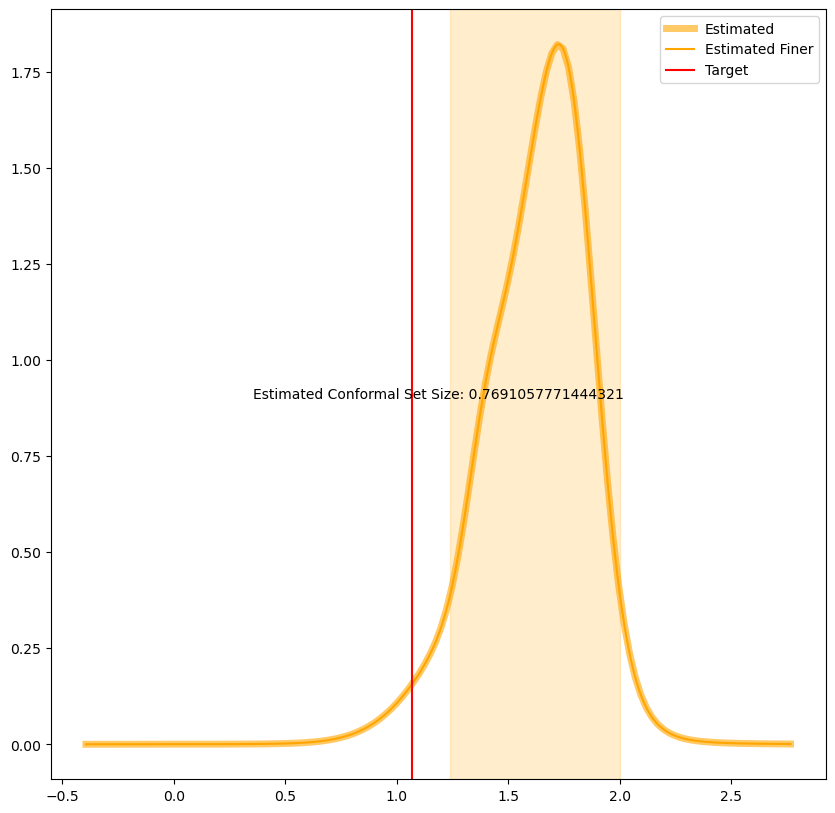

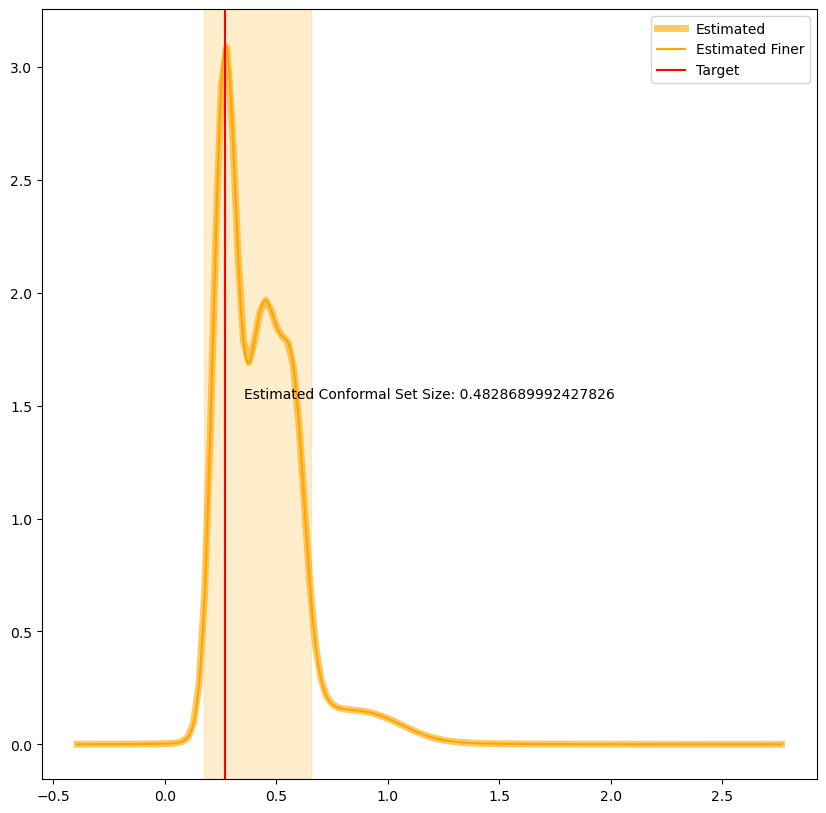

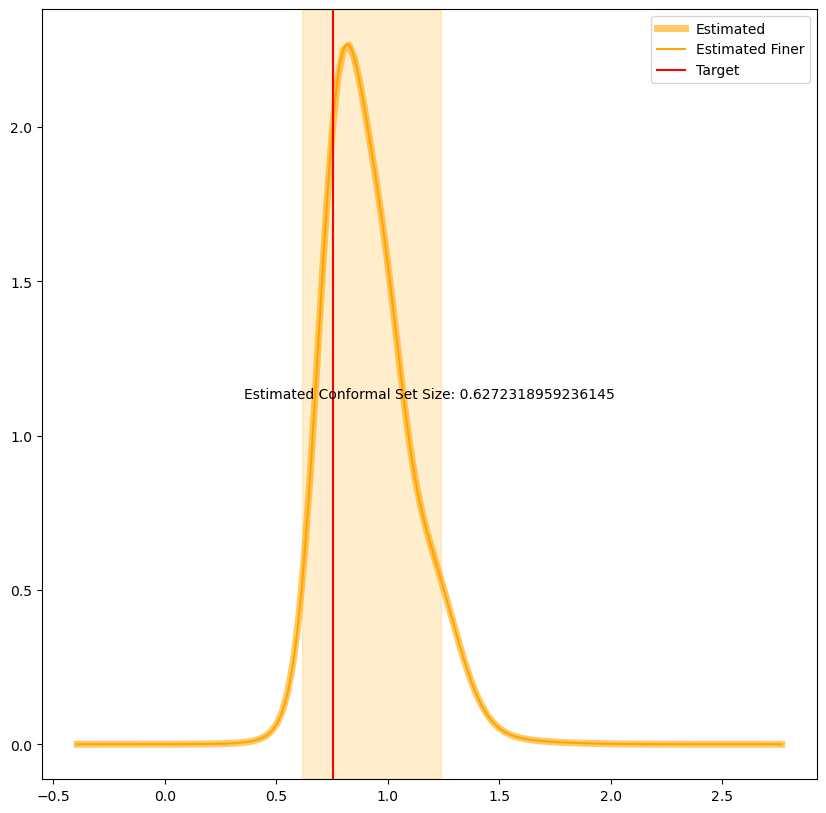

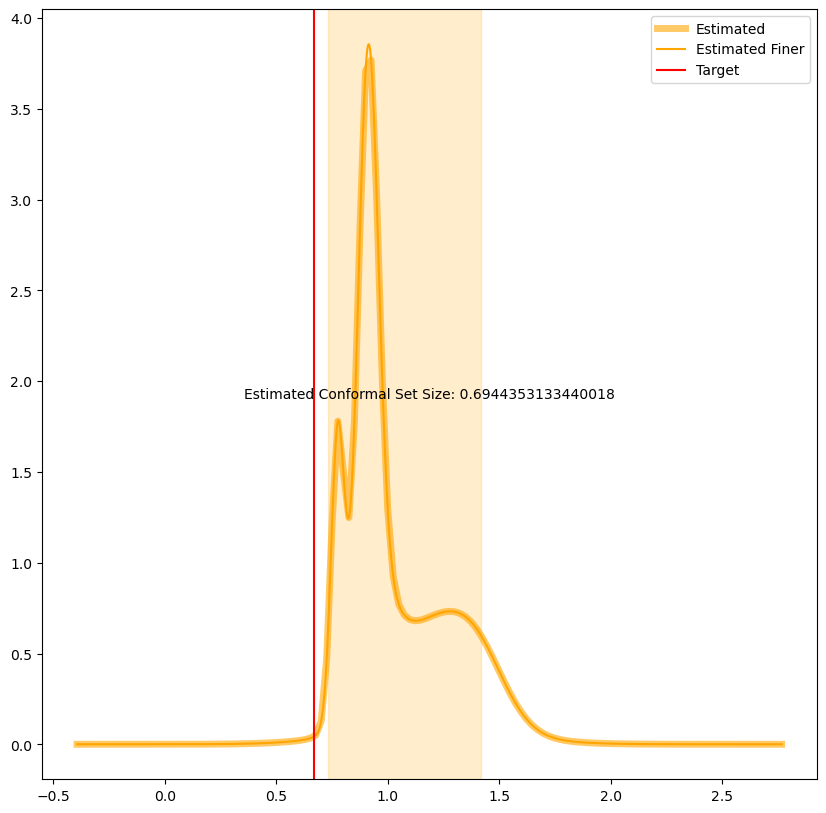

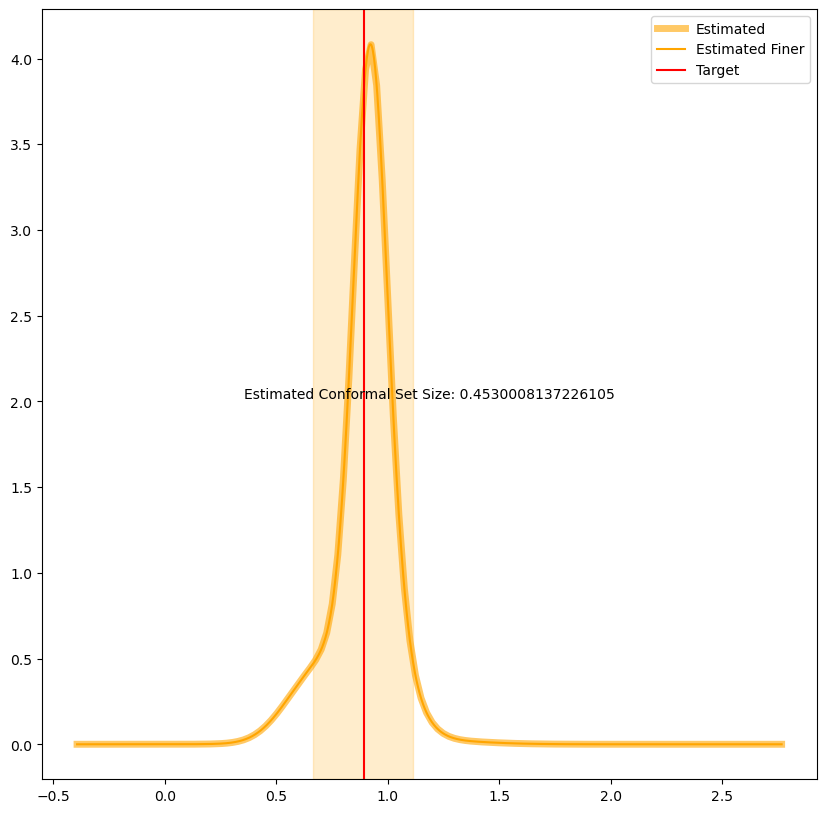

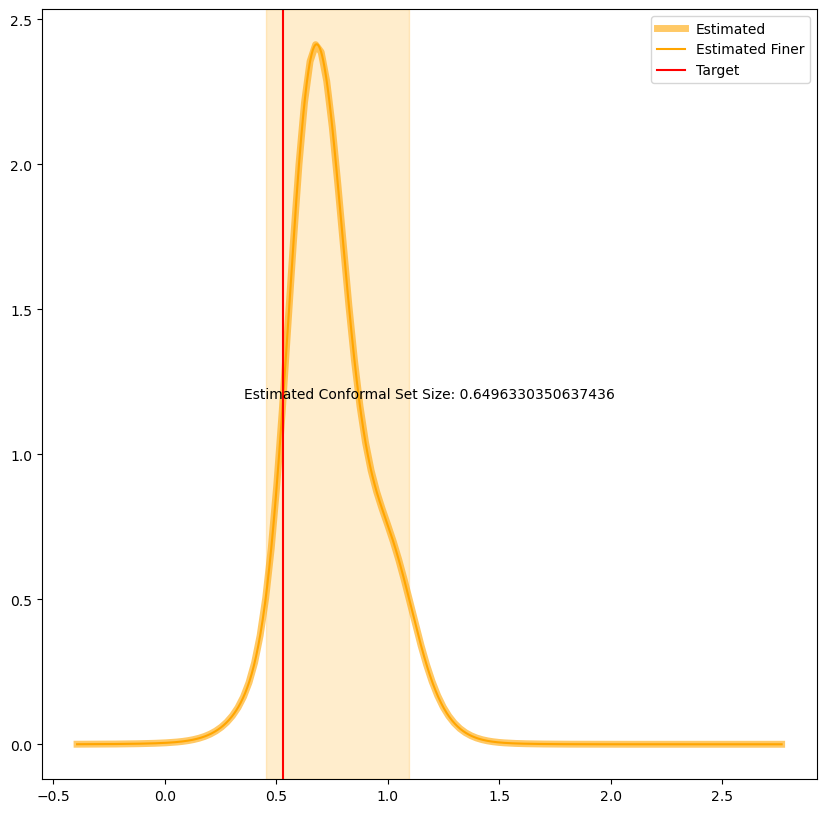

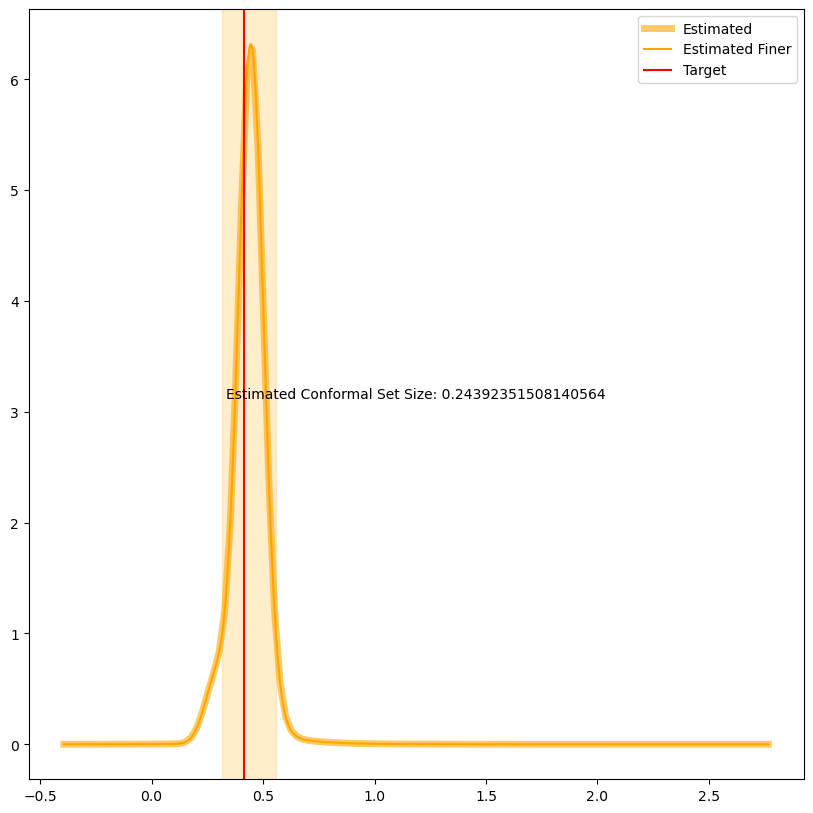

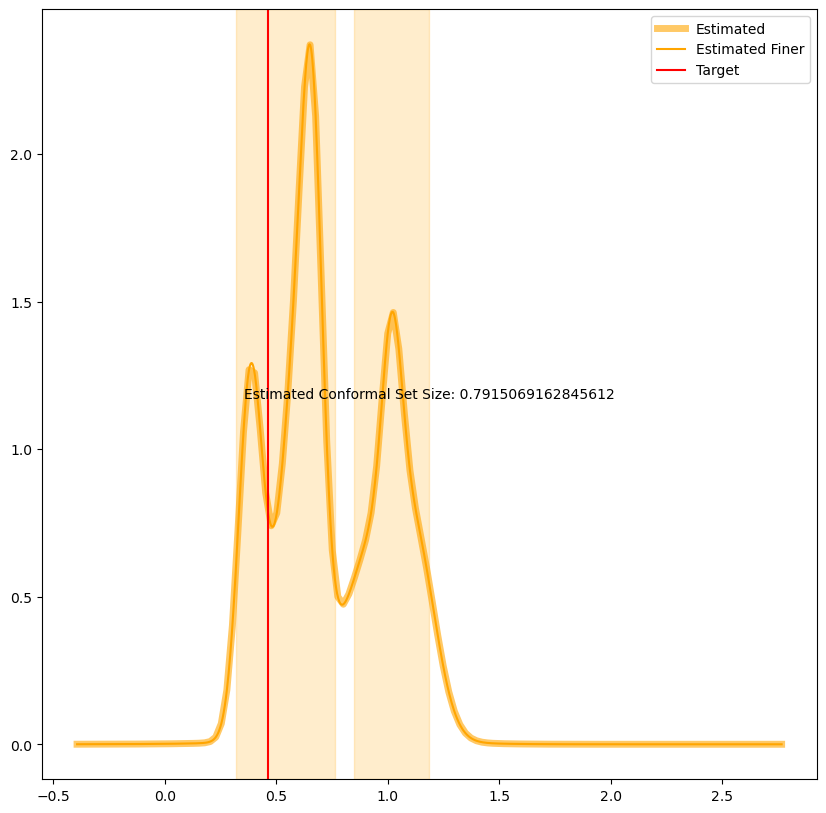

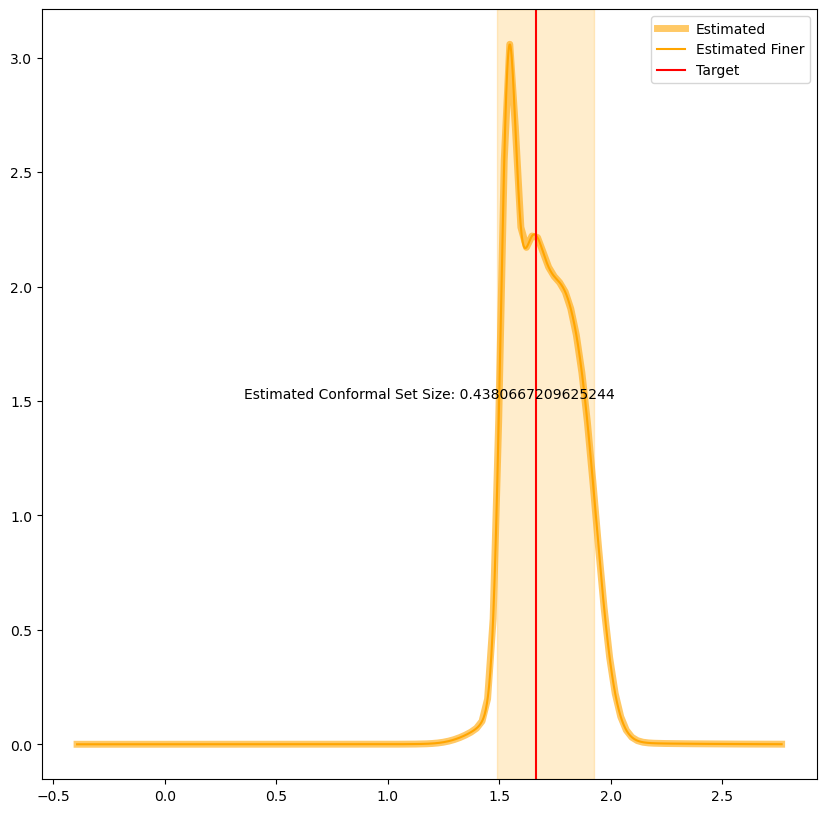

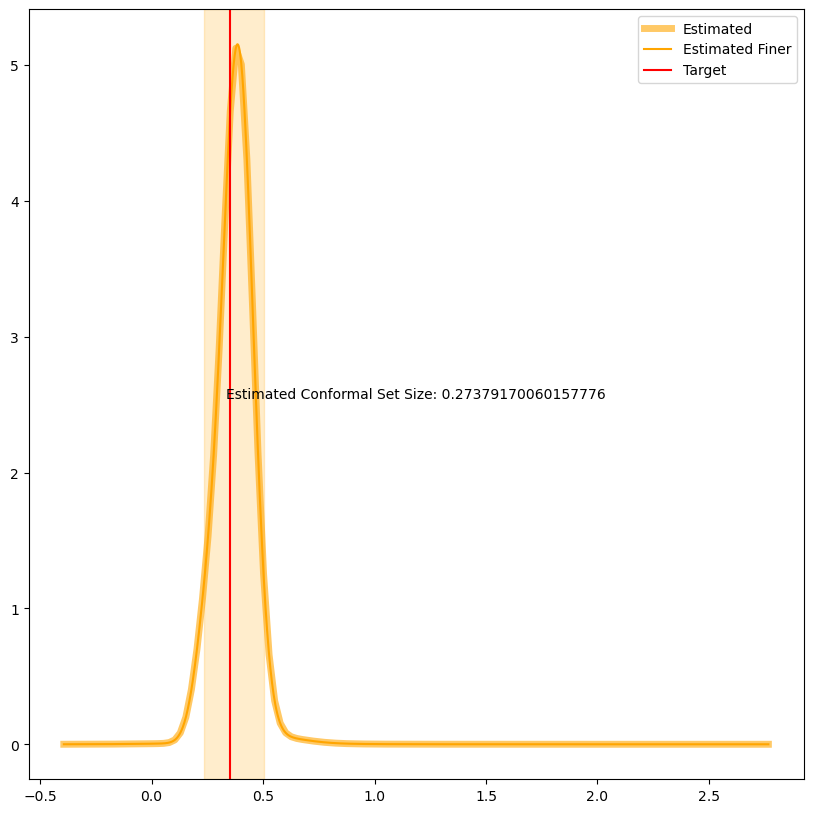

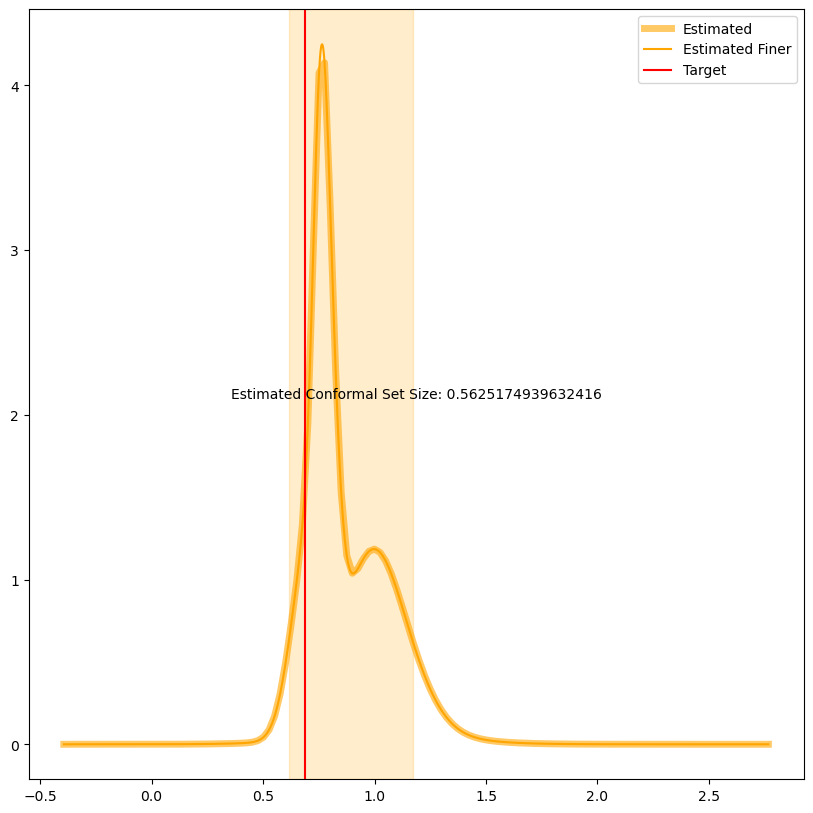

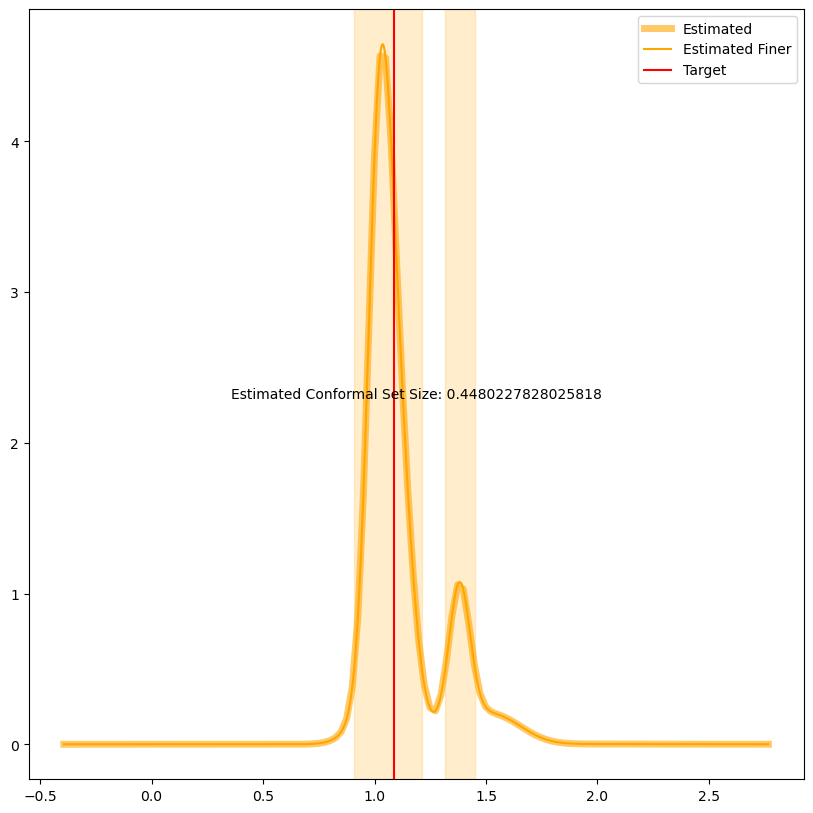

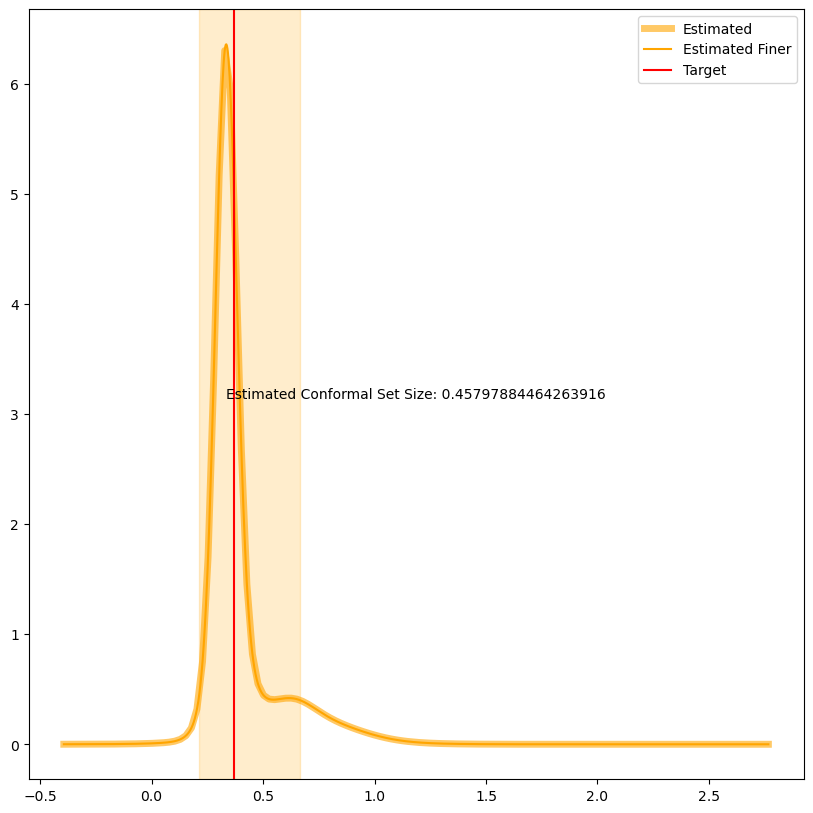

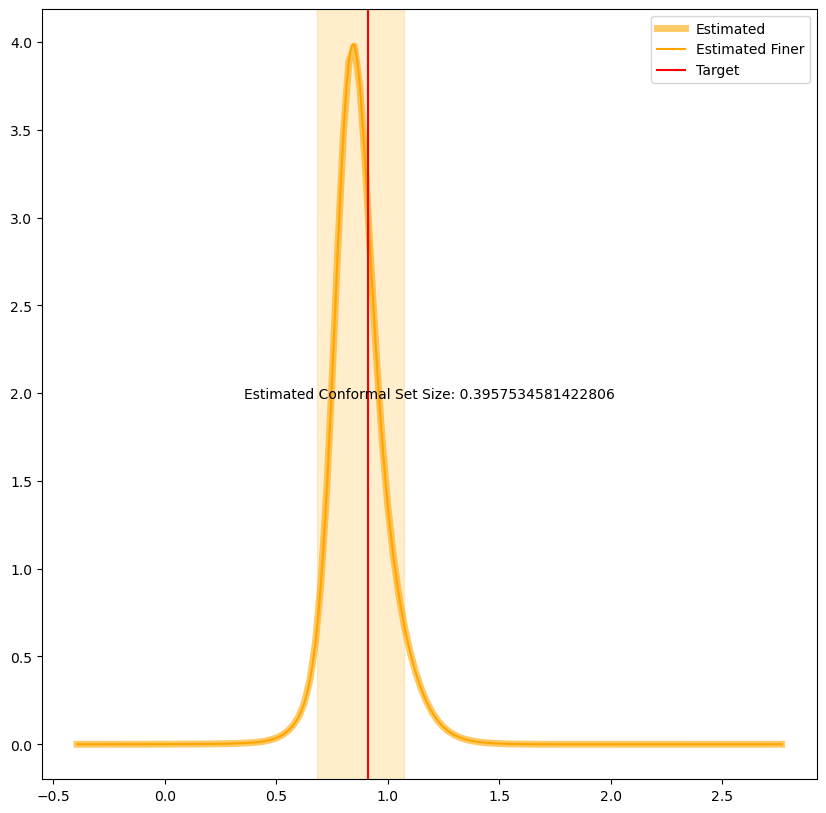

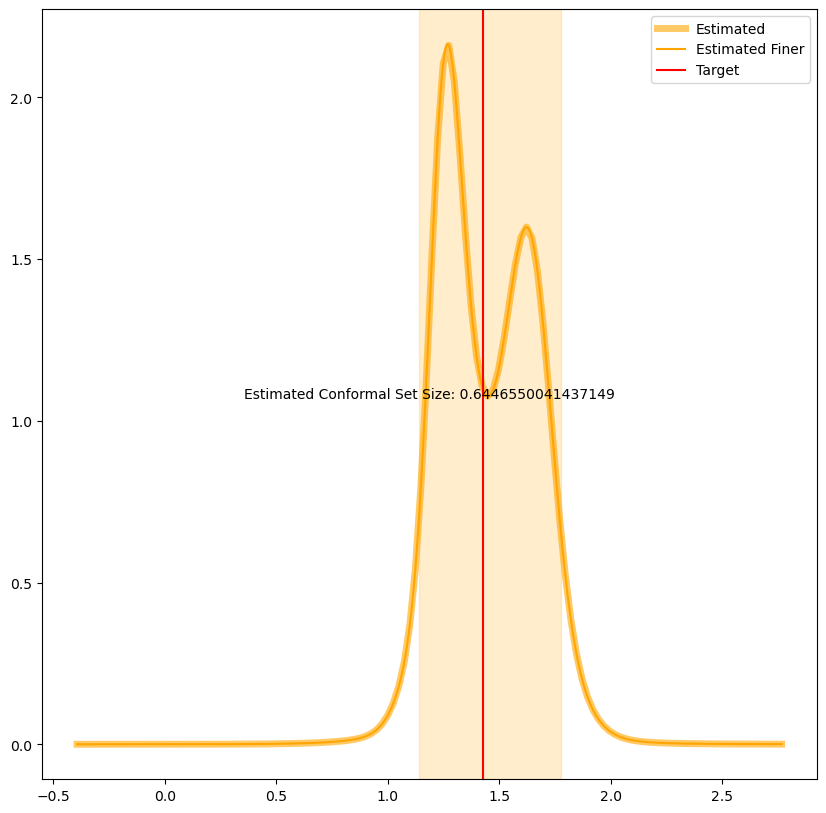

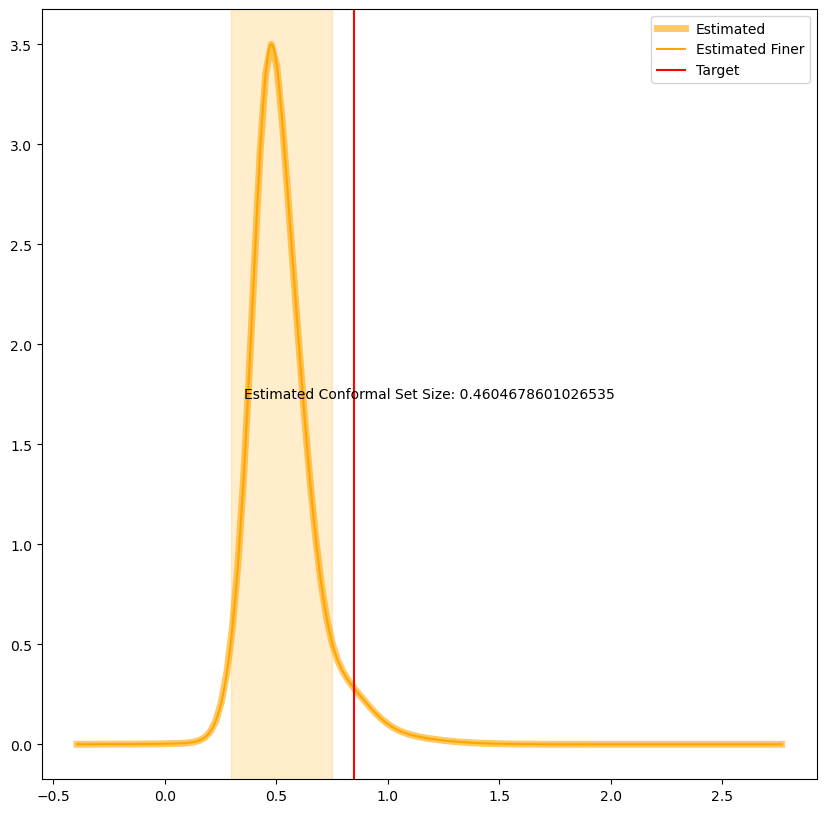

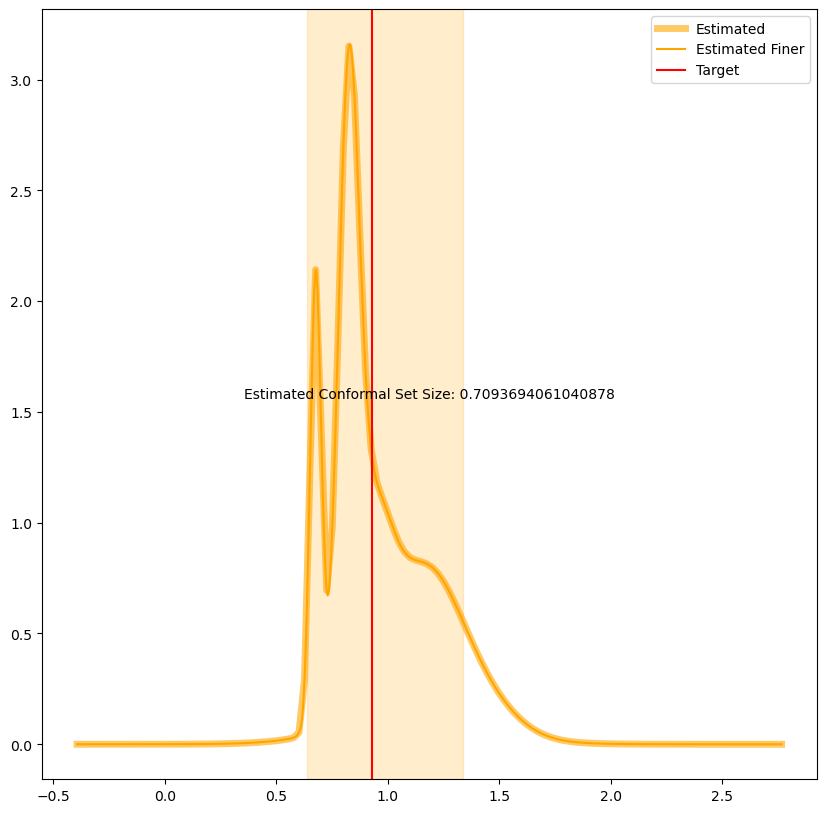

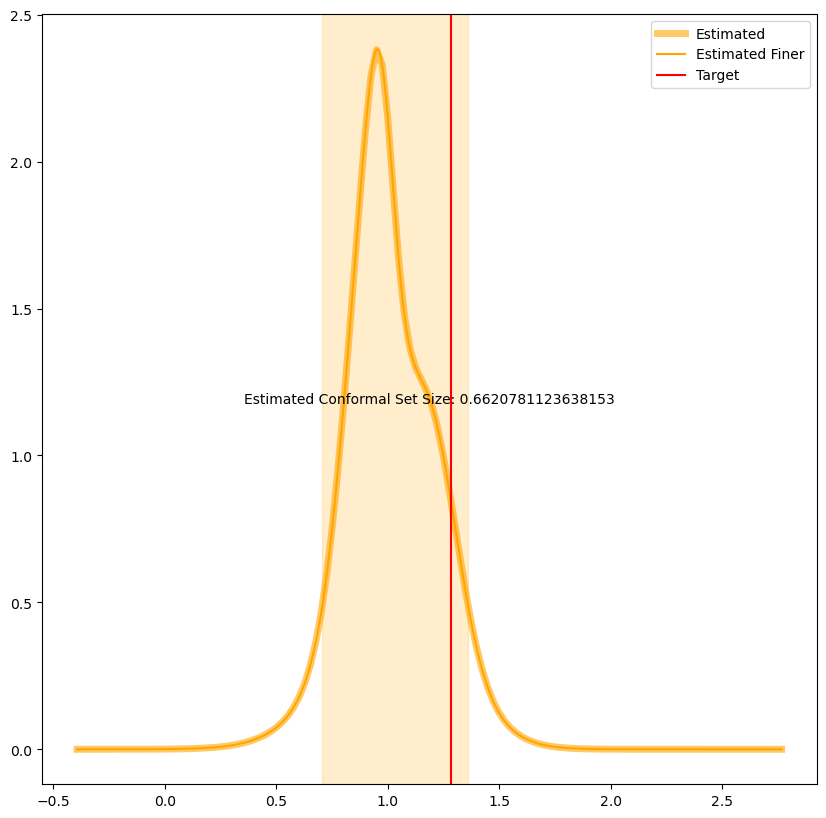

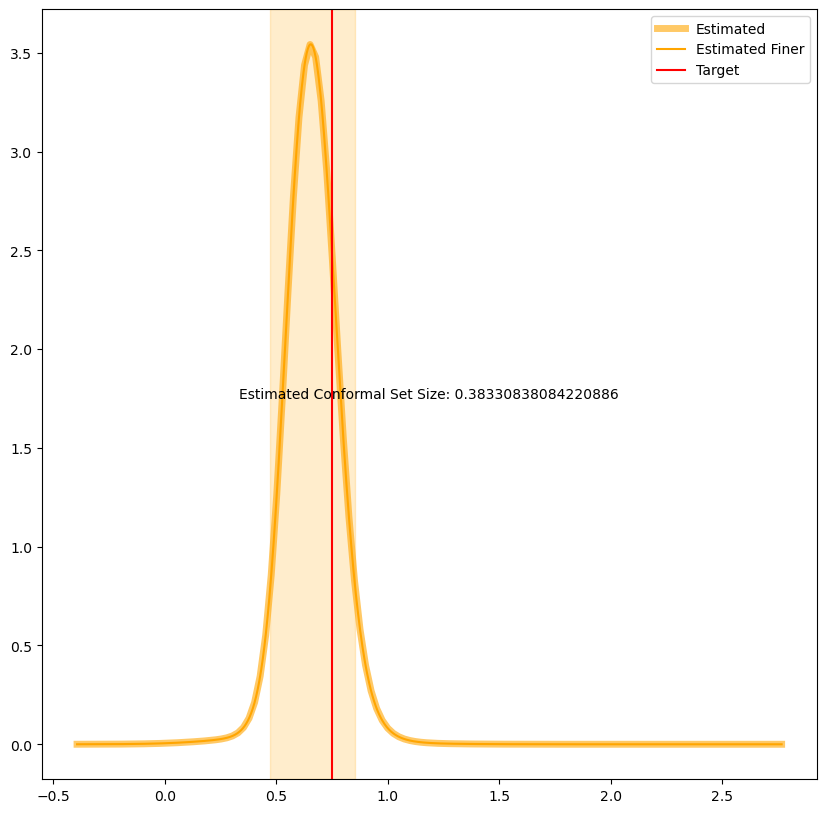

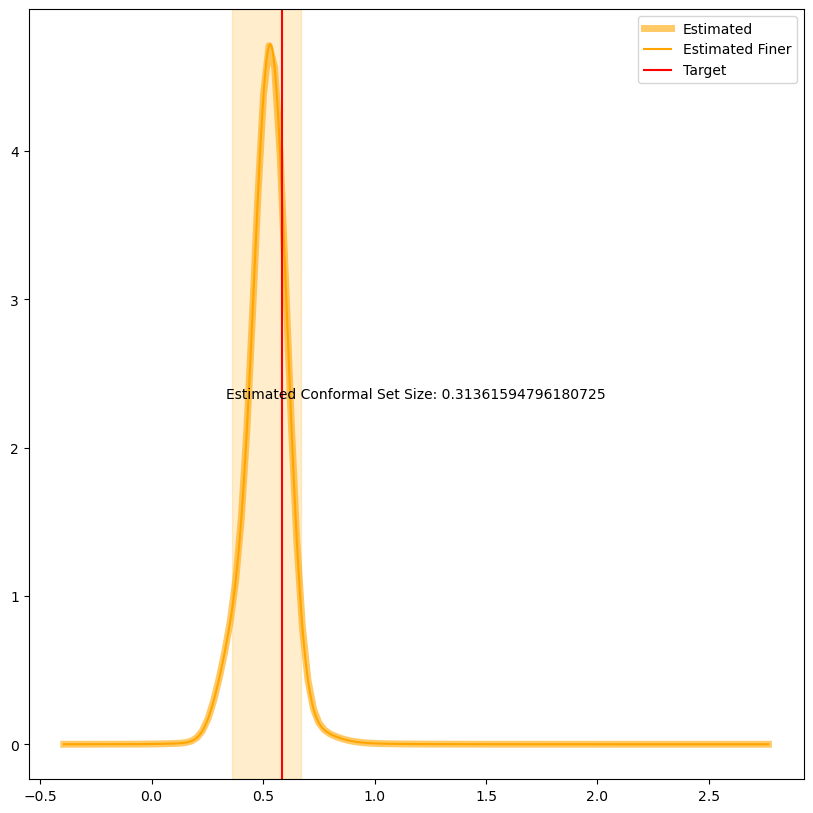

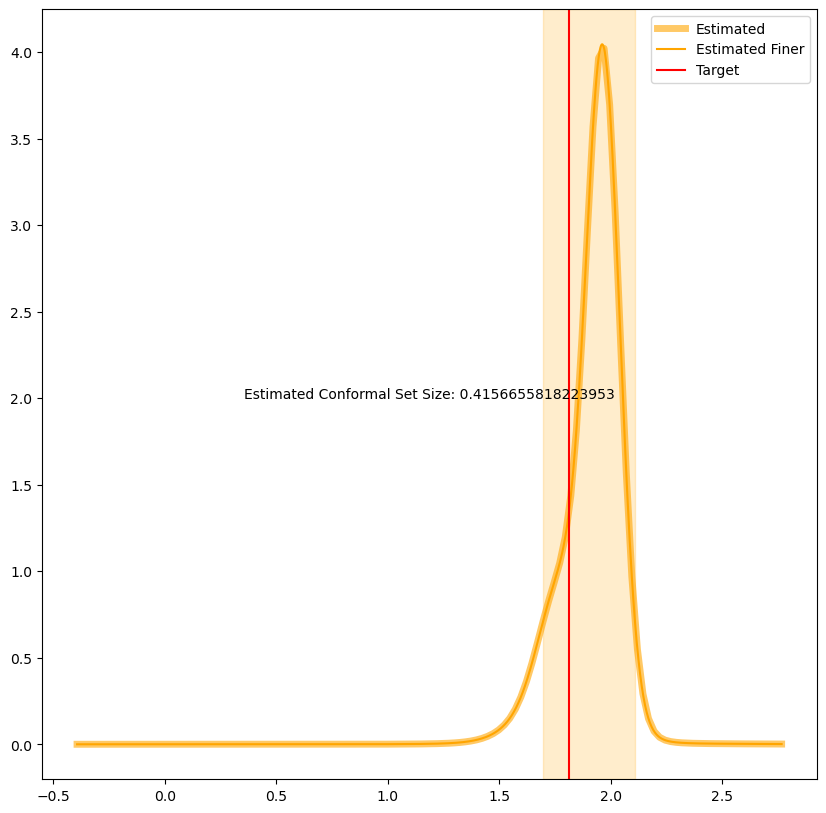

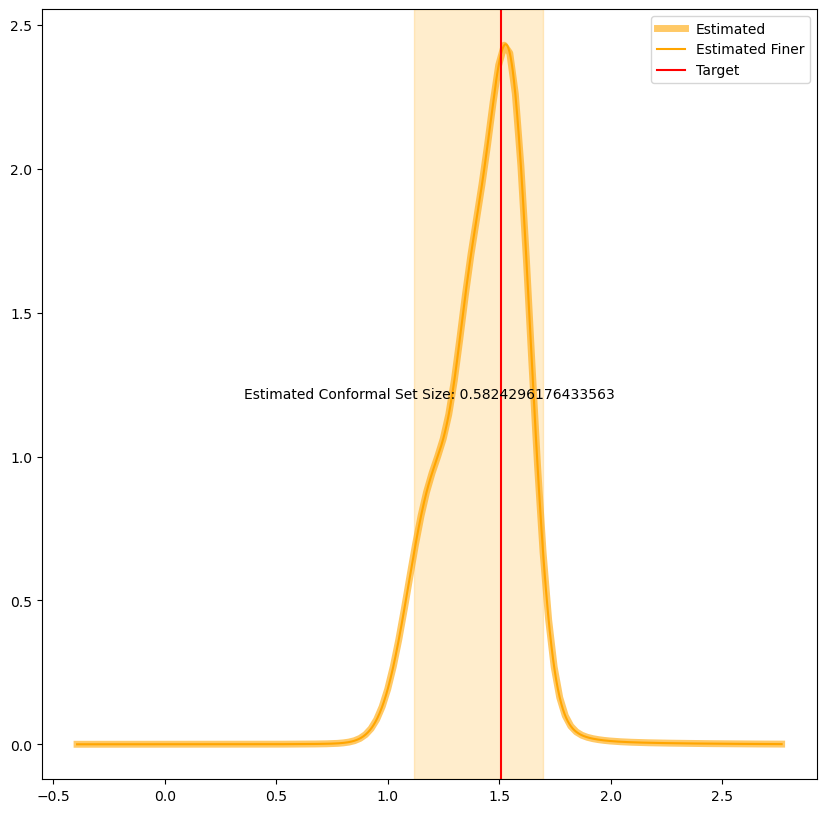

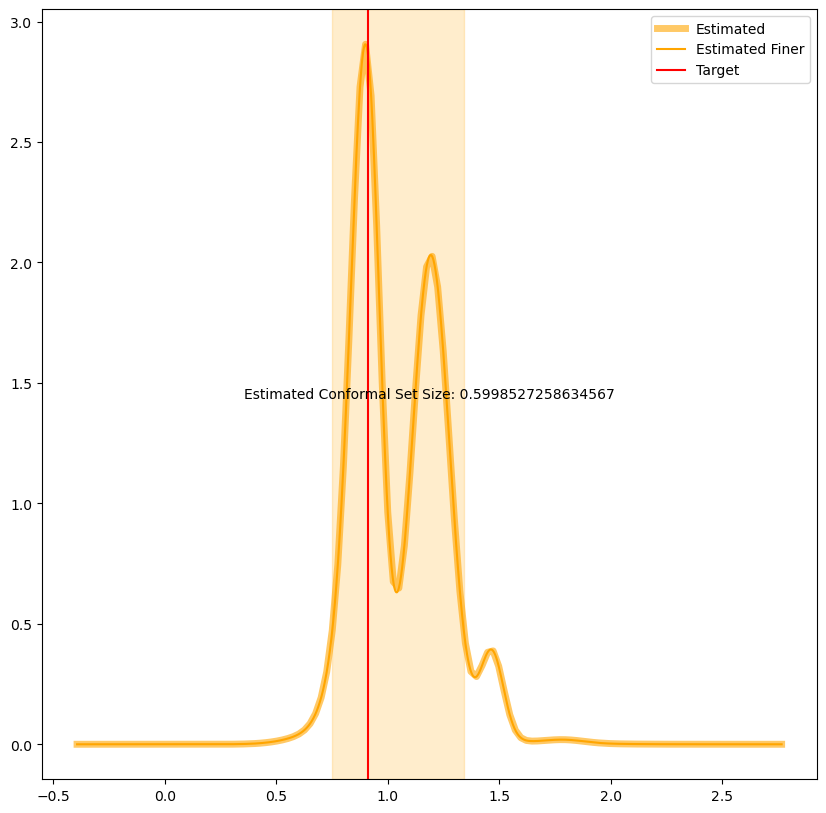

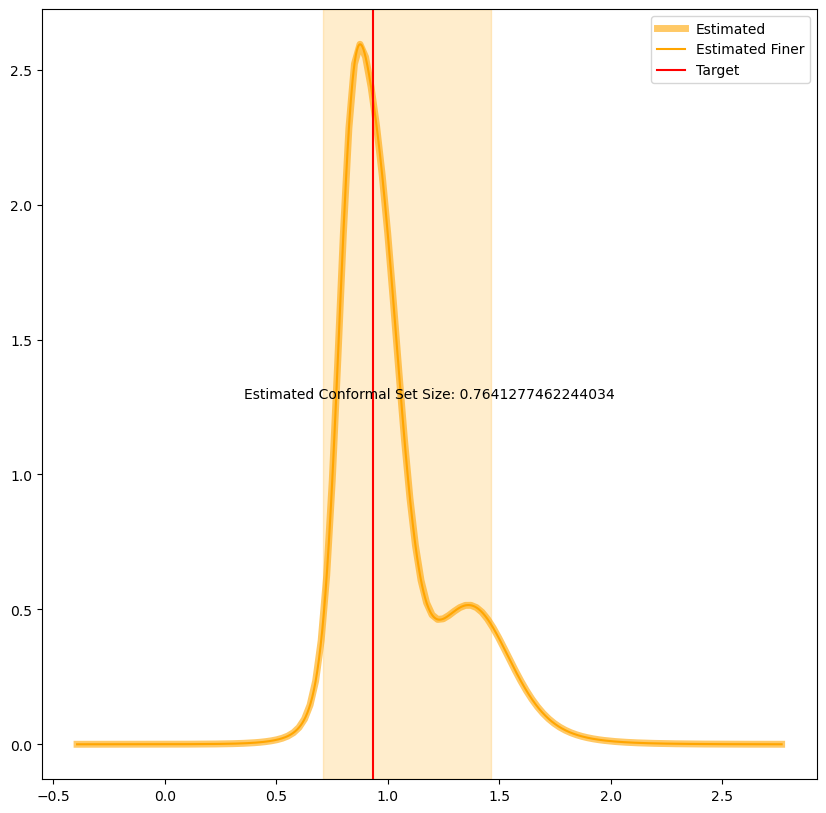

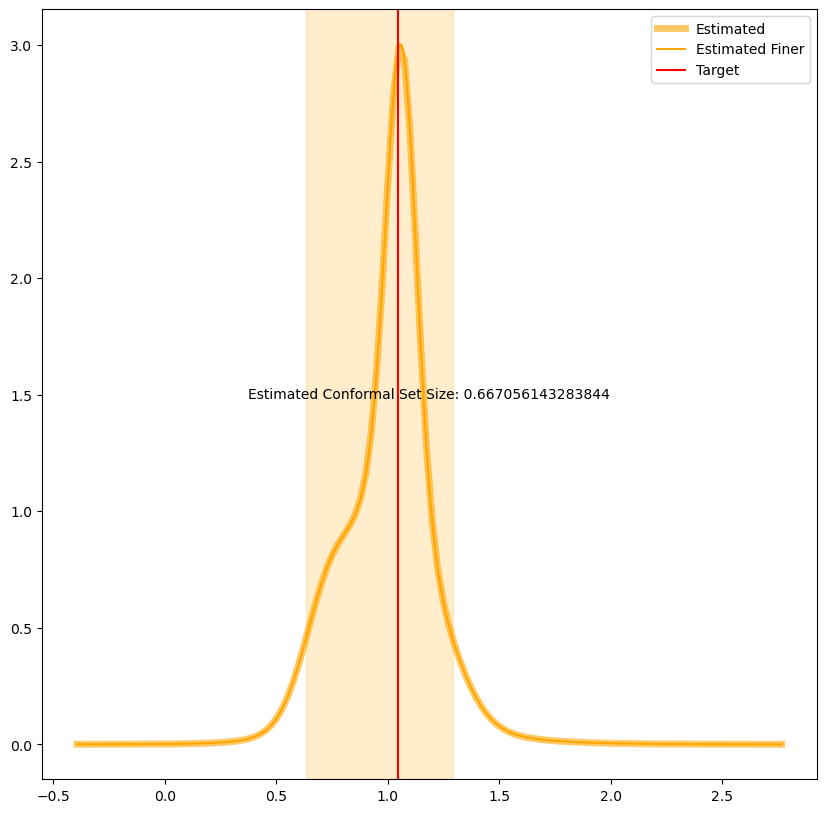

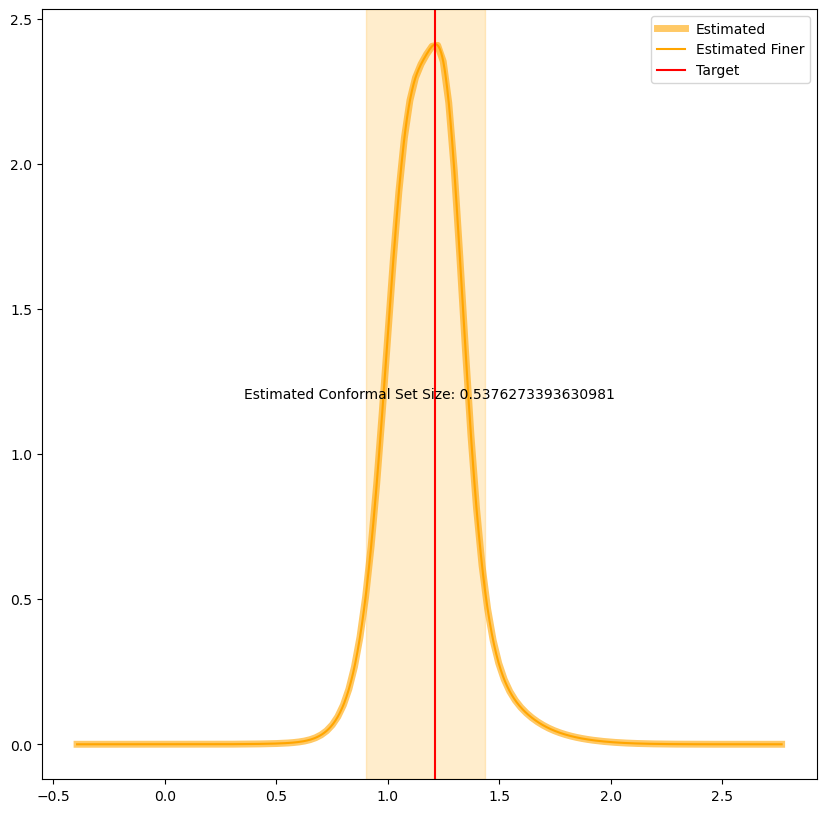

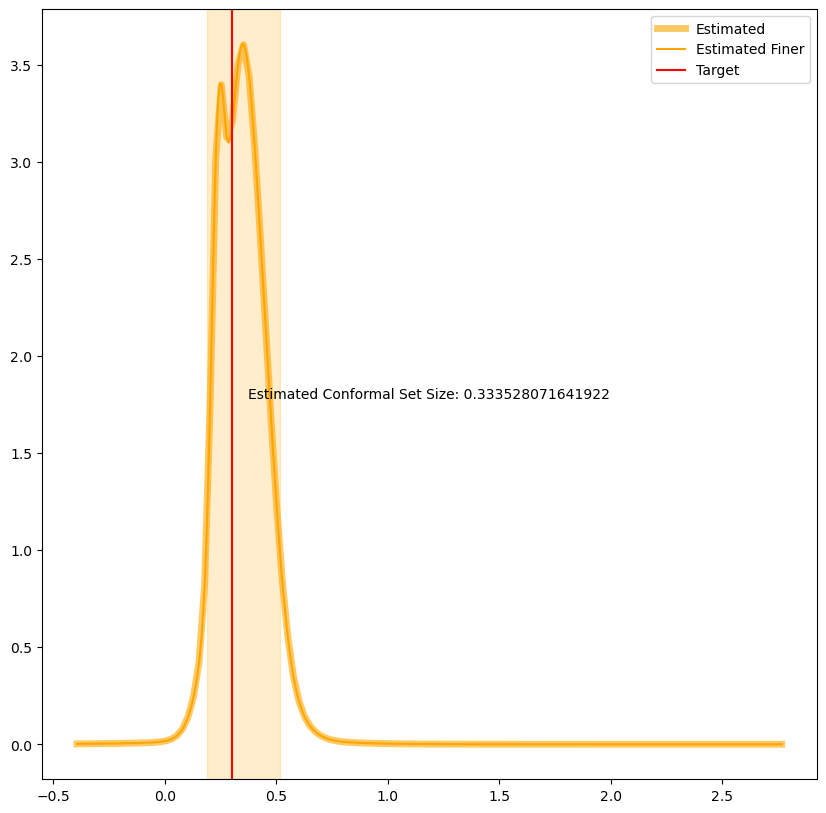

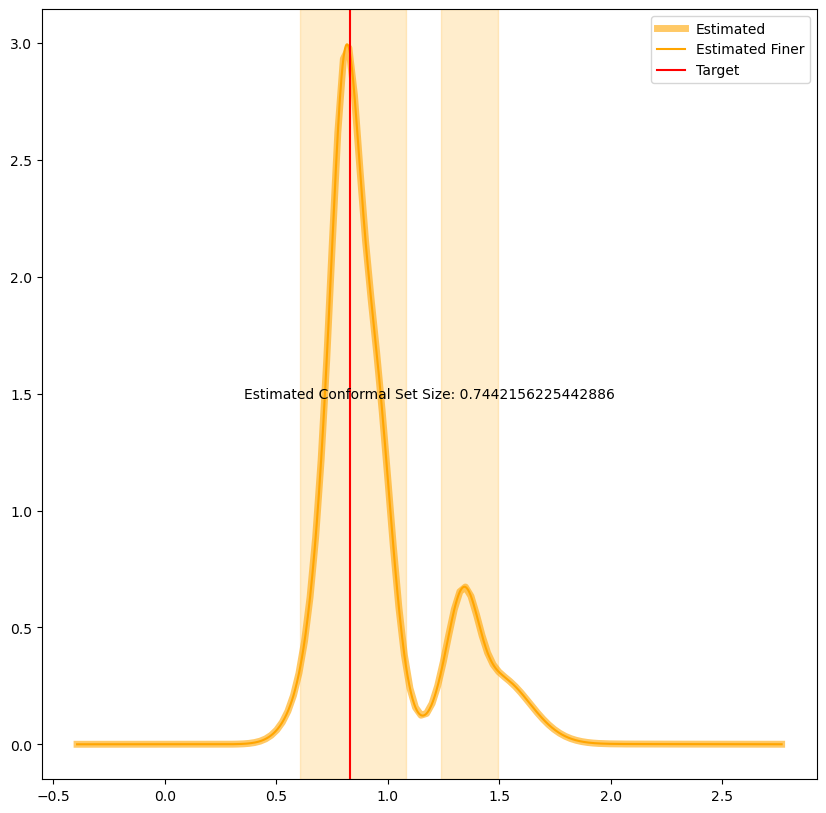

 33%|███▎      | 1/3 [00:11<00:23, 11.70s/it]

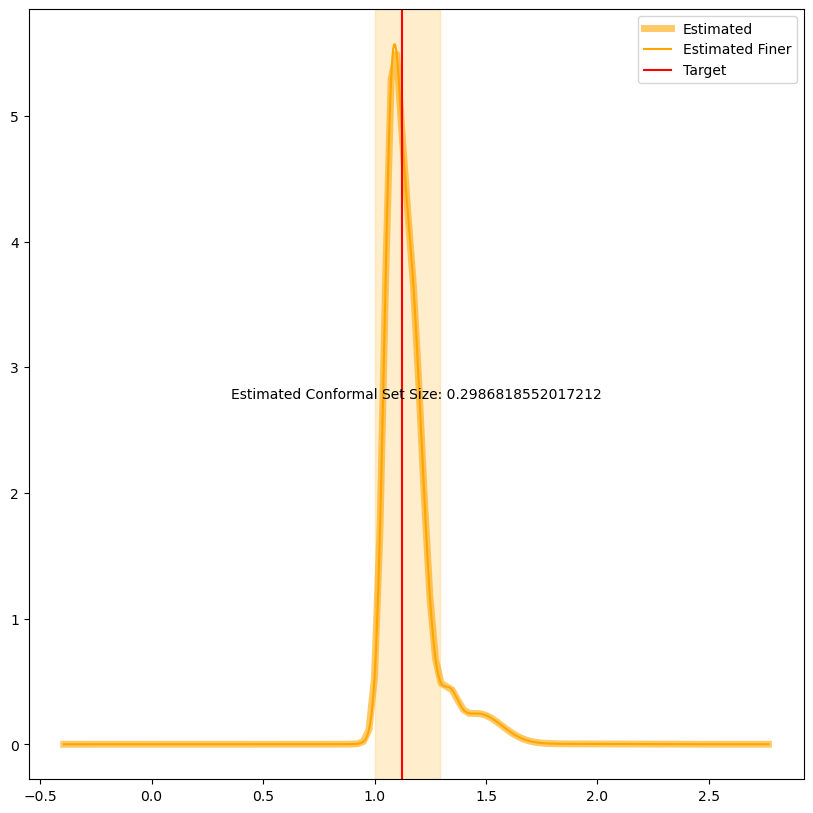

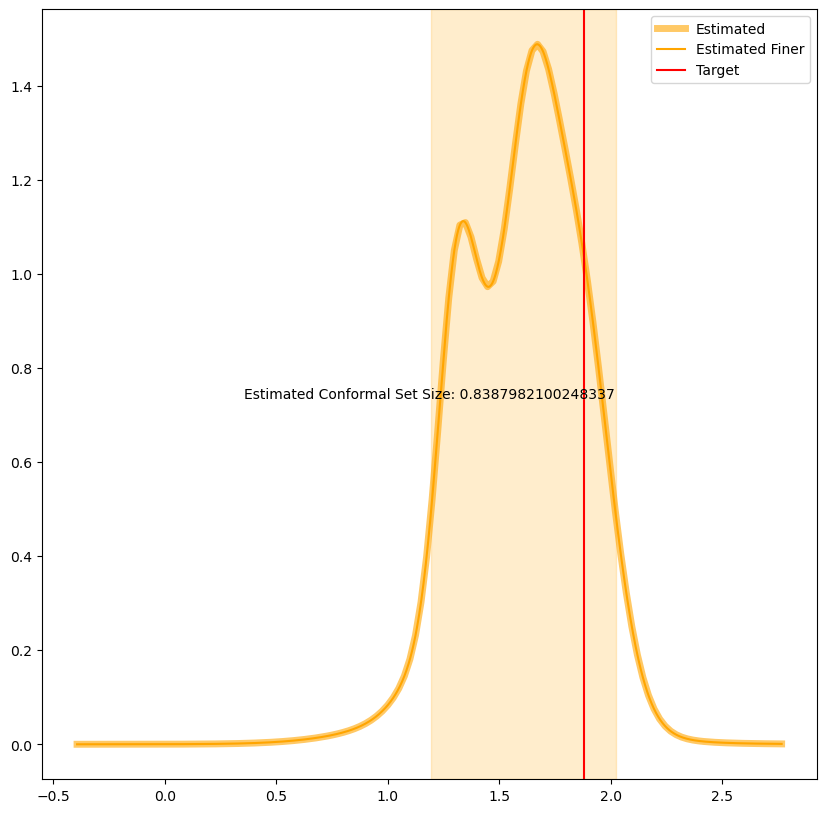

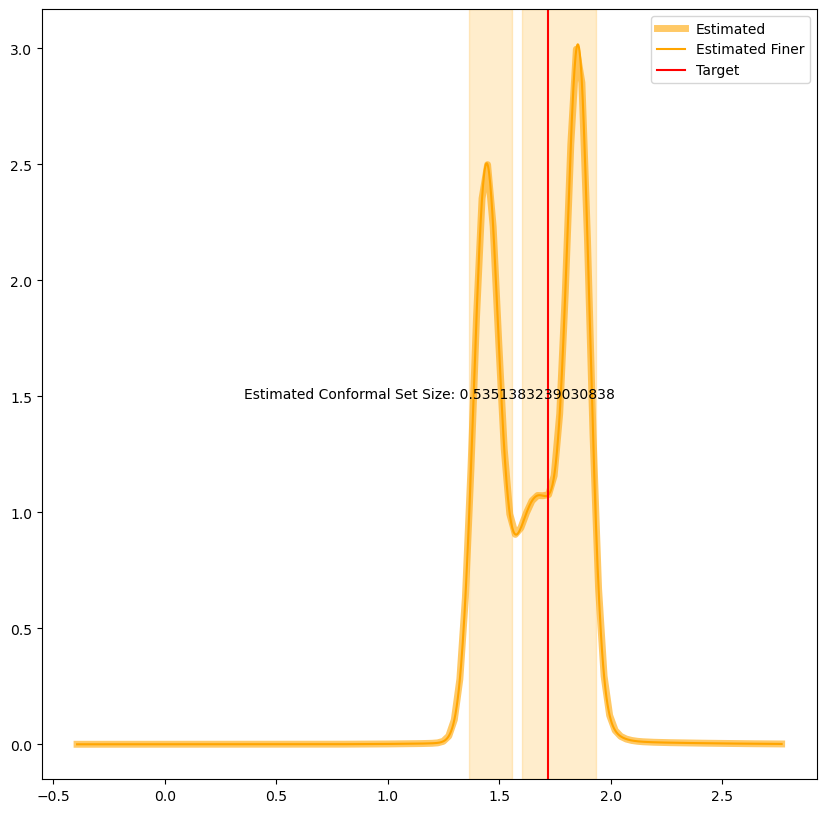

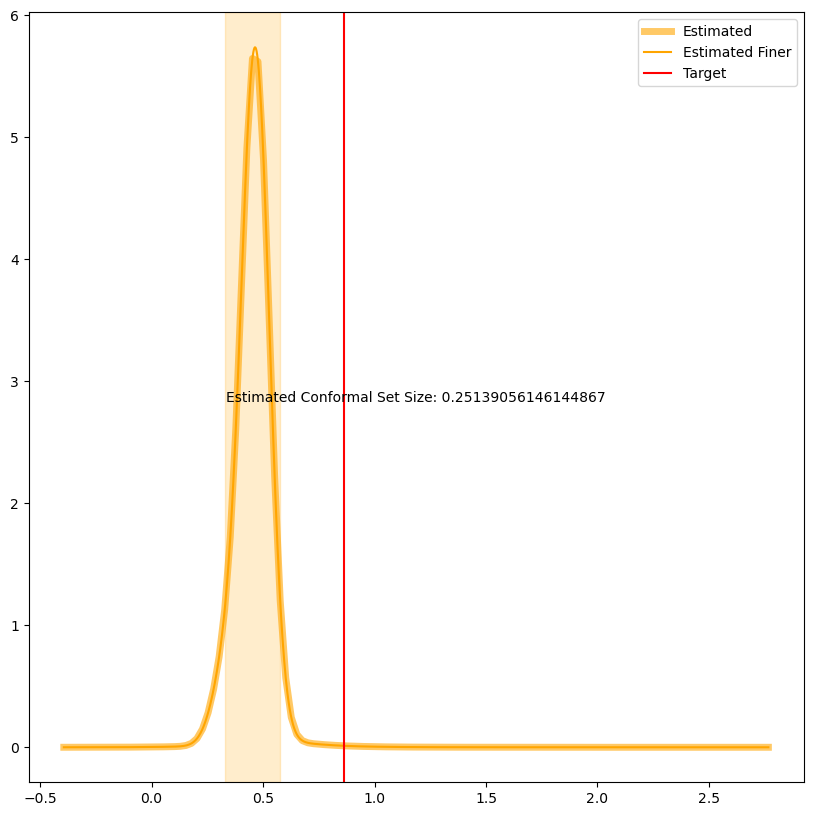

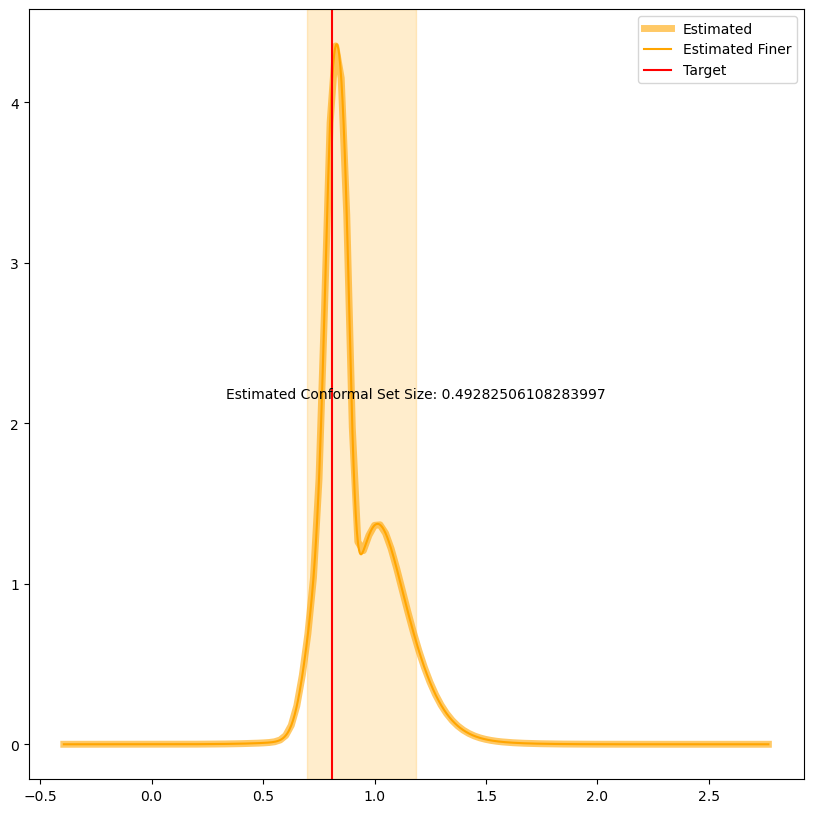

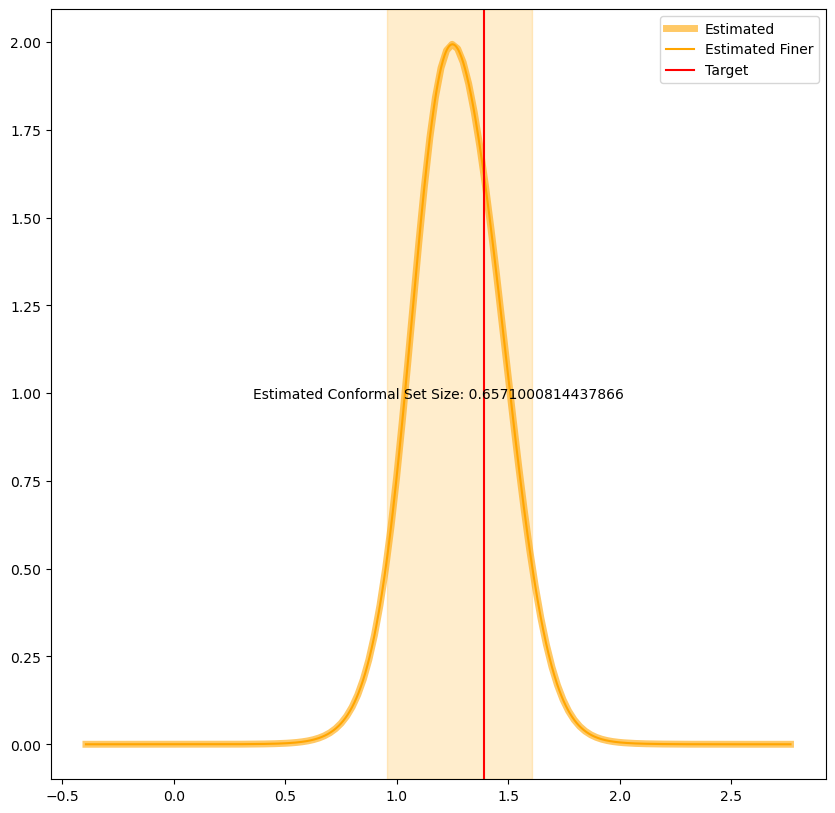

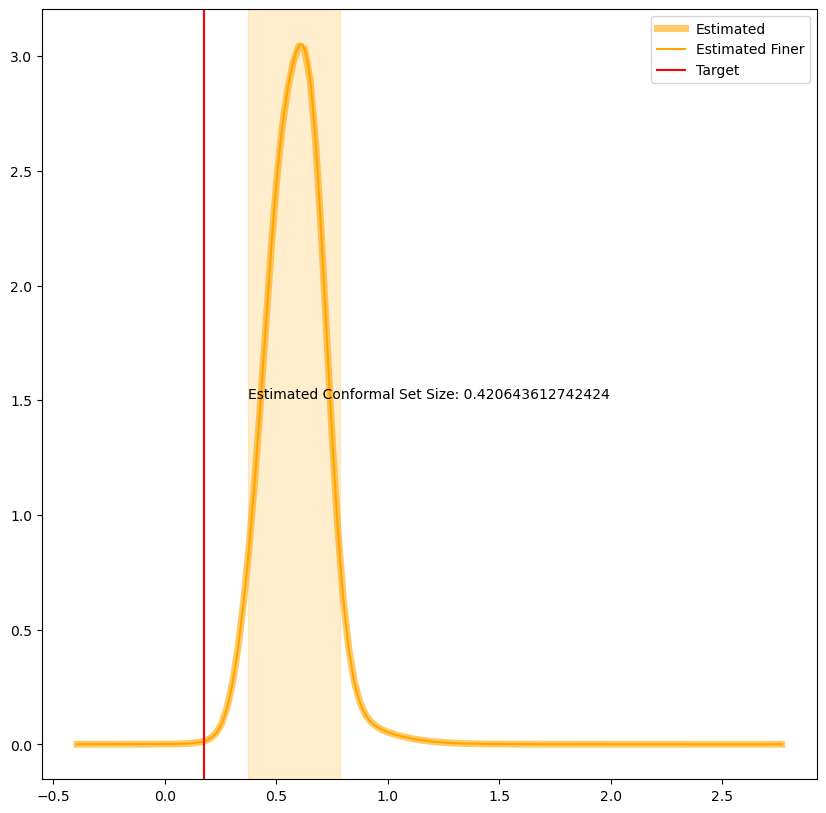

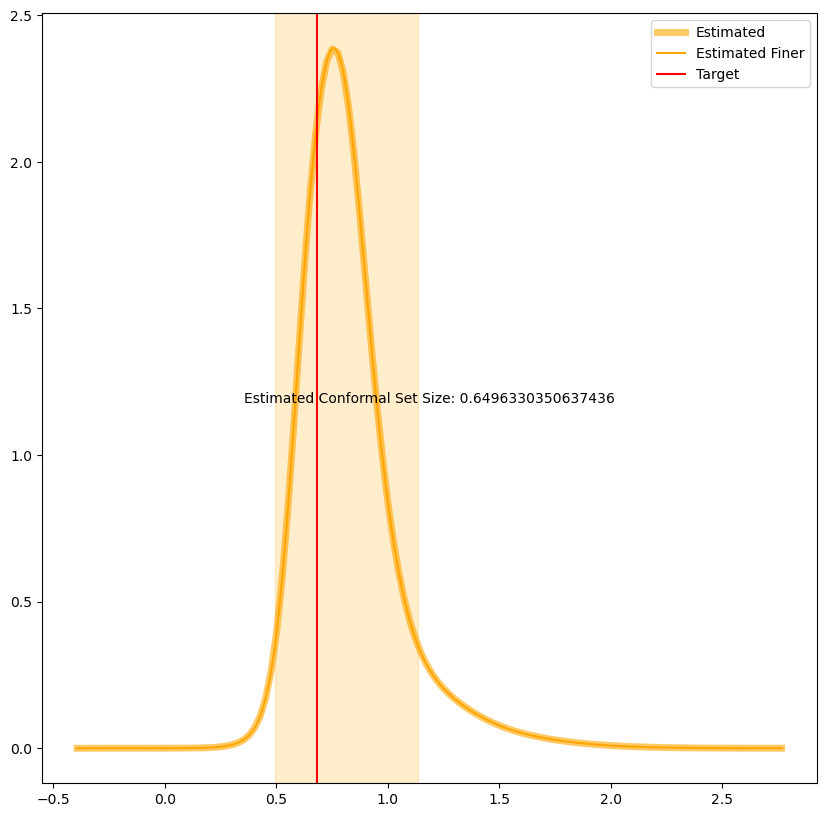

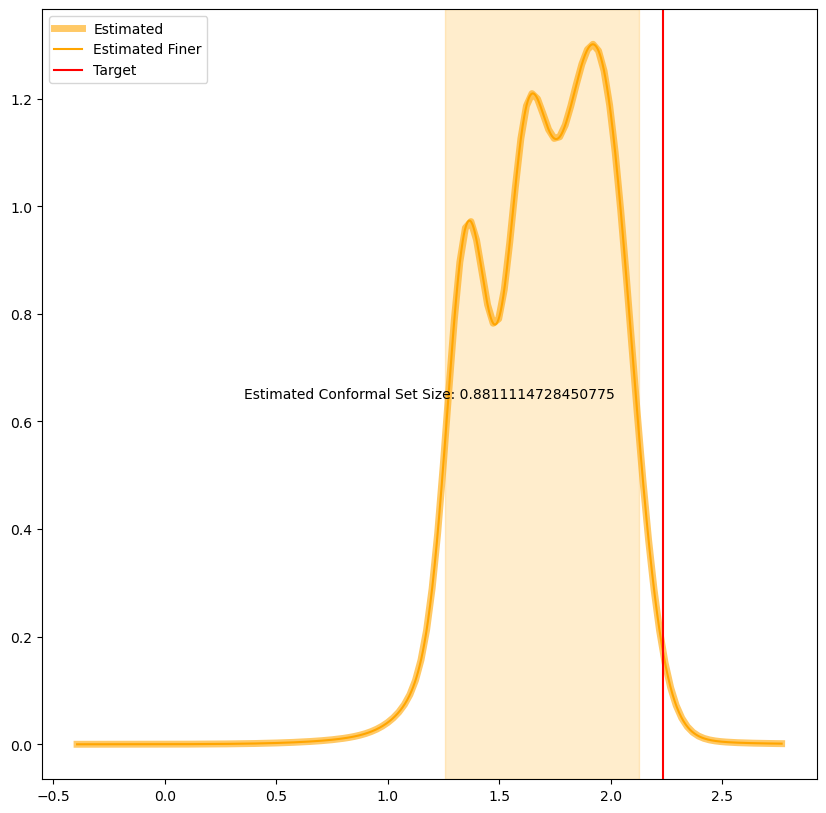

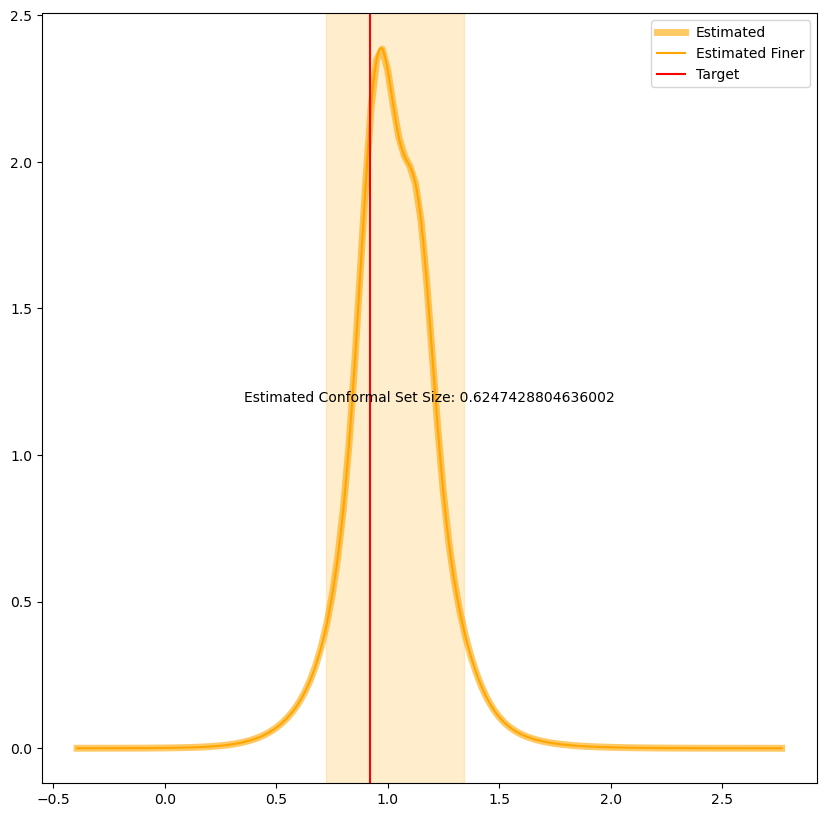

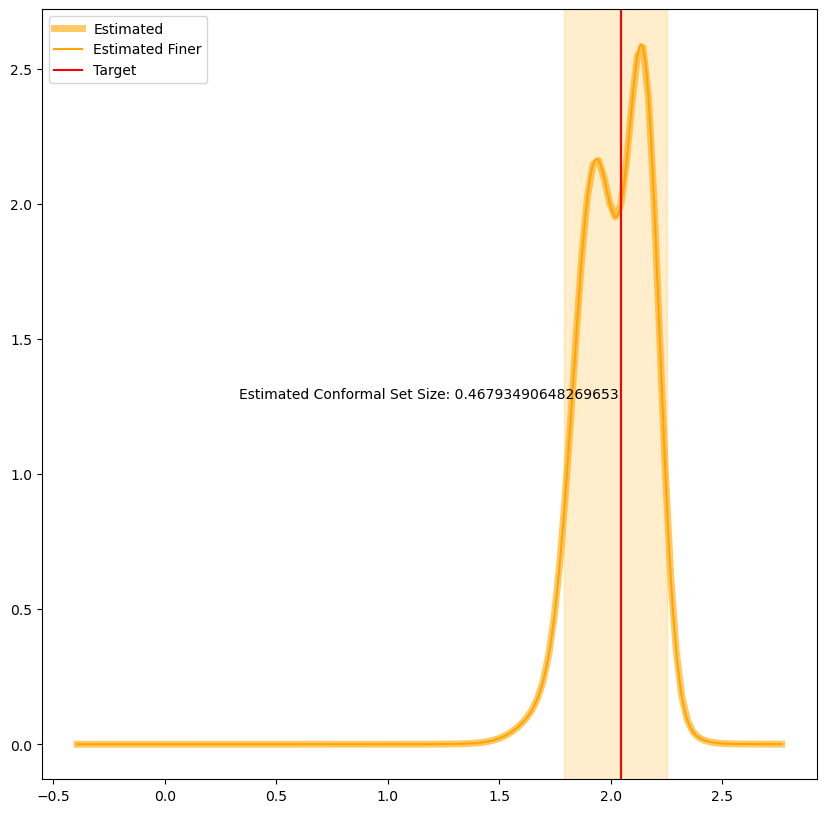

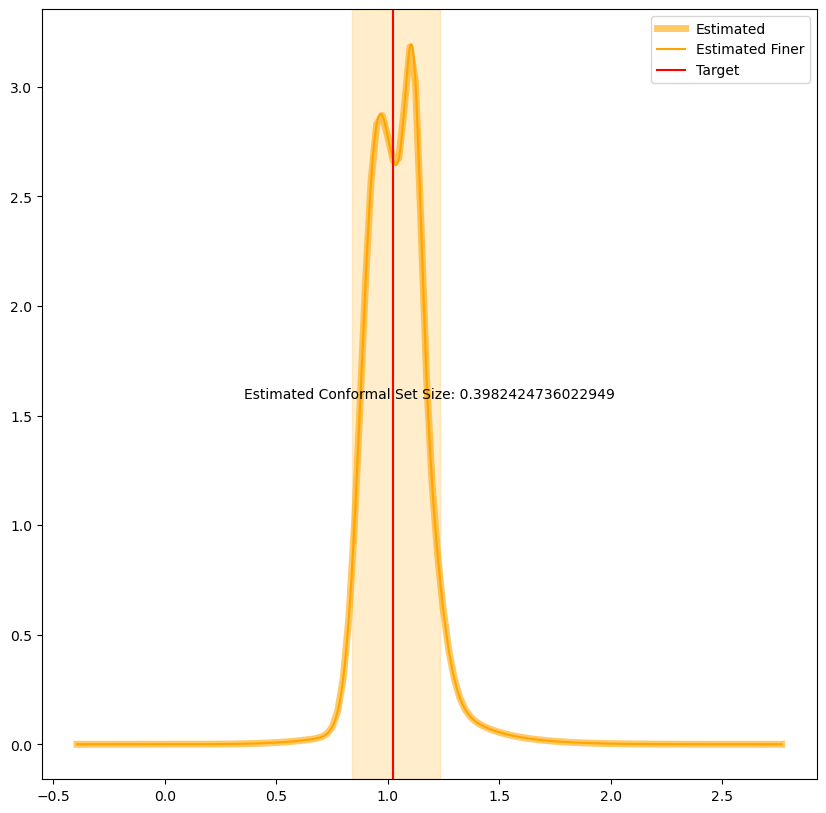

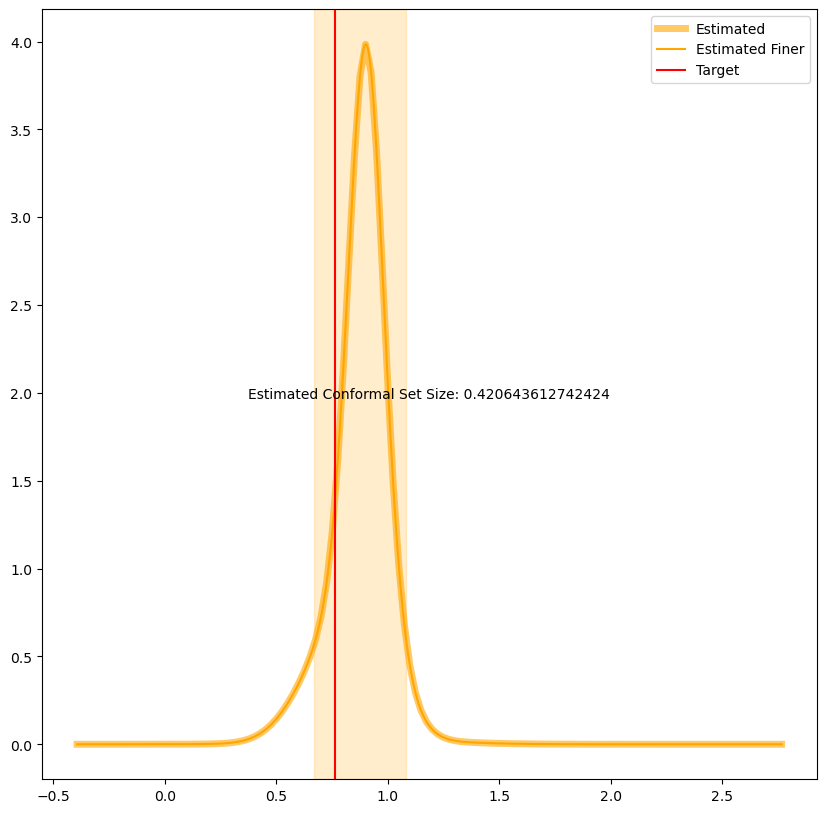

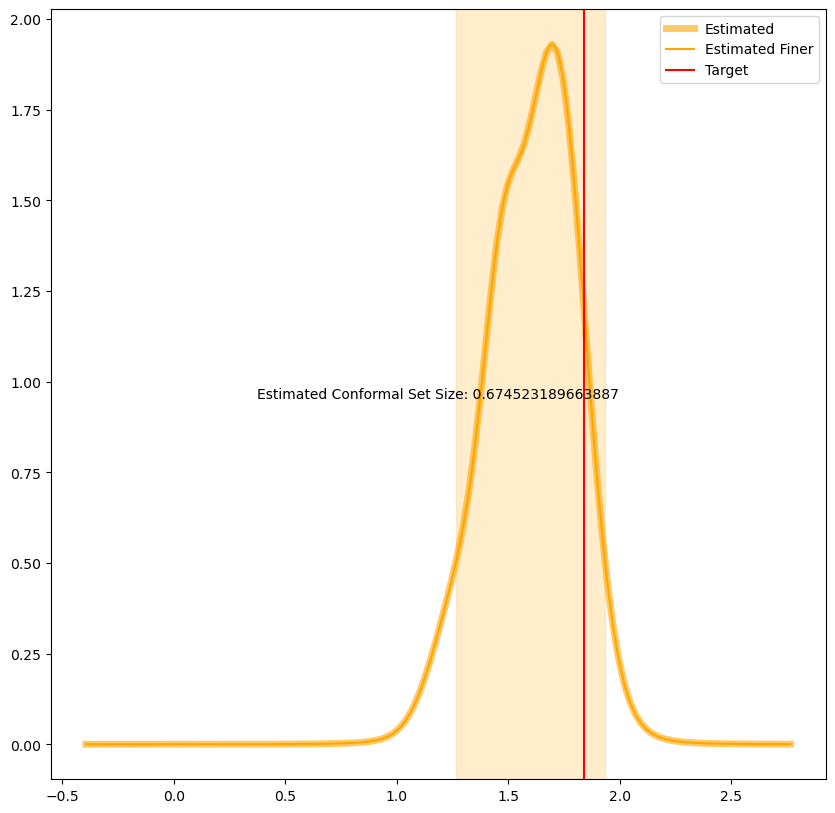

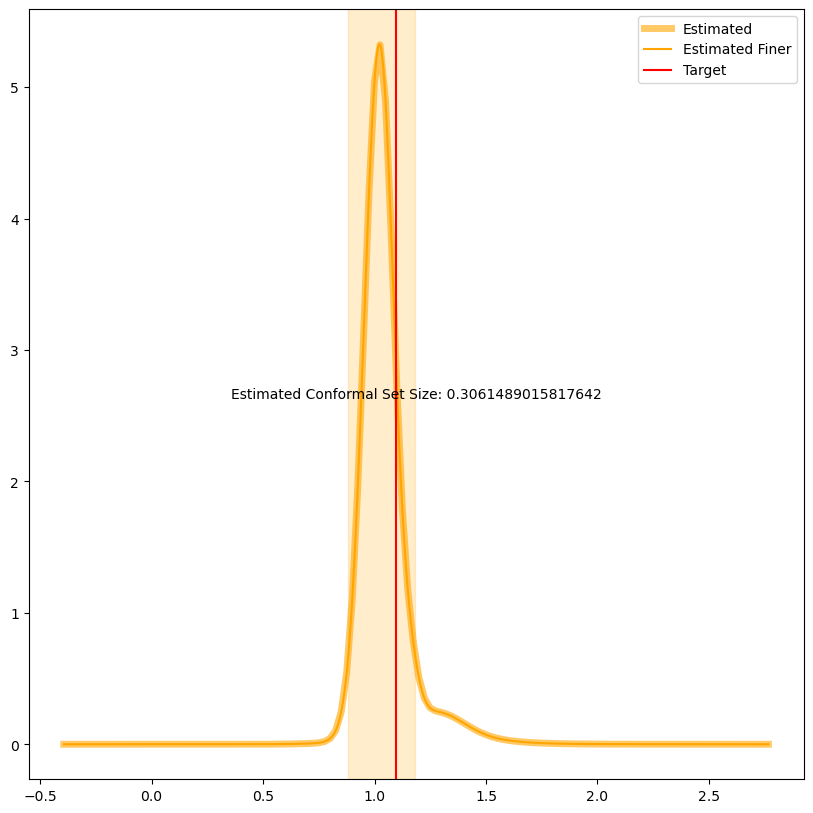

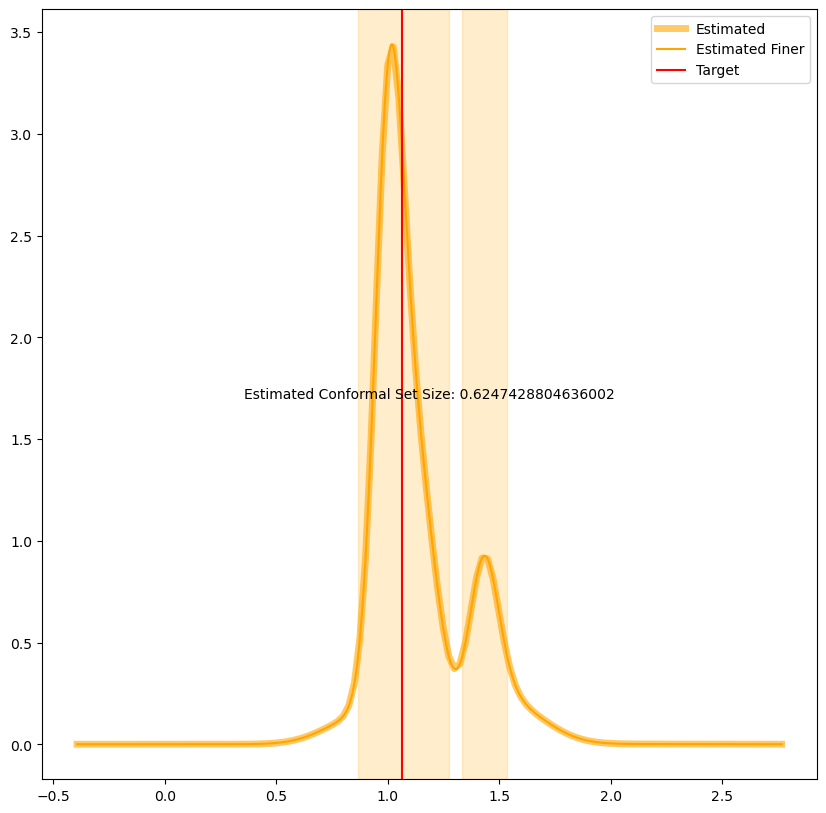

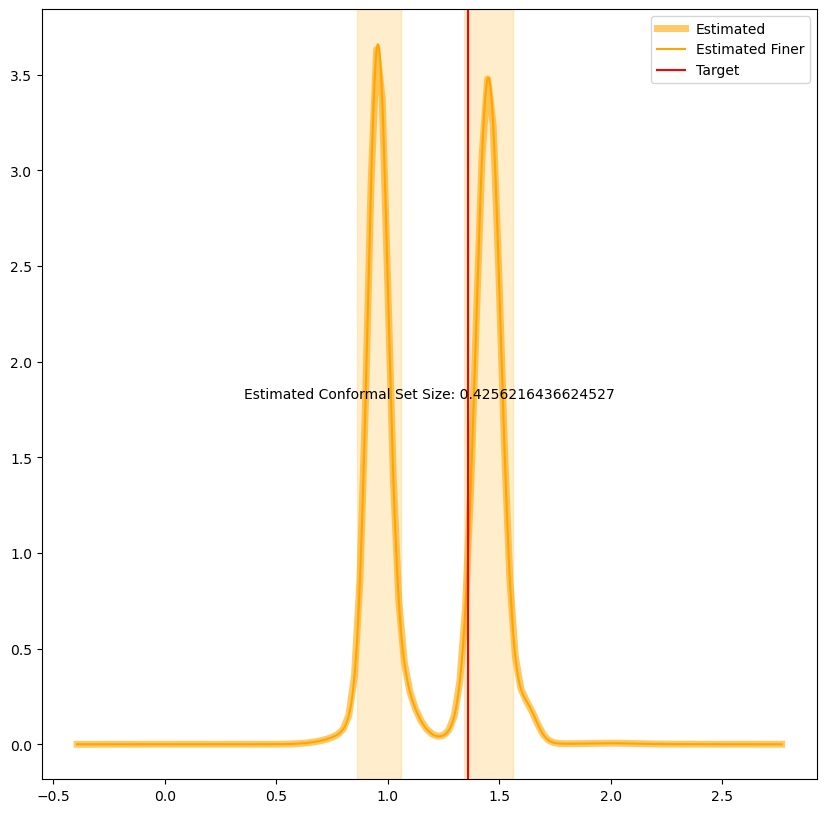

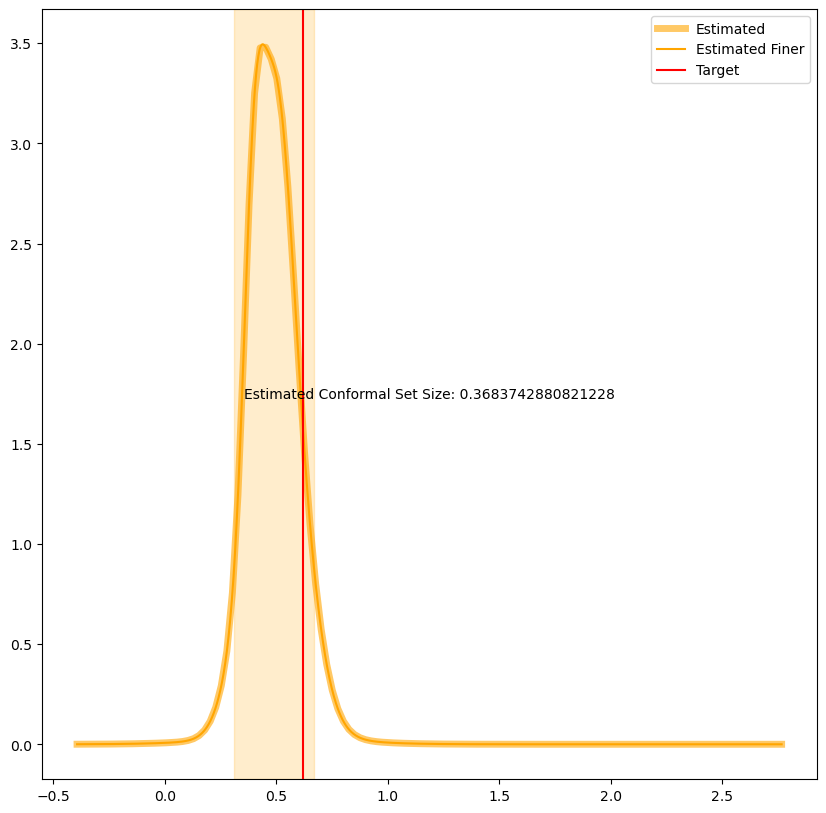

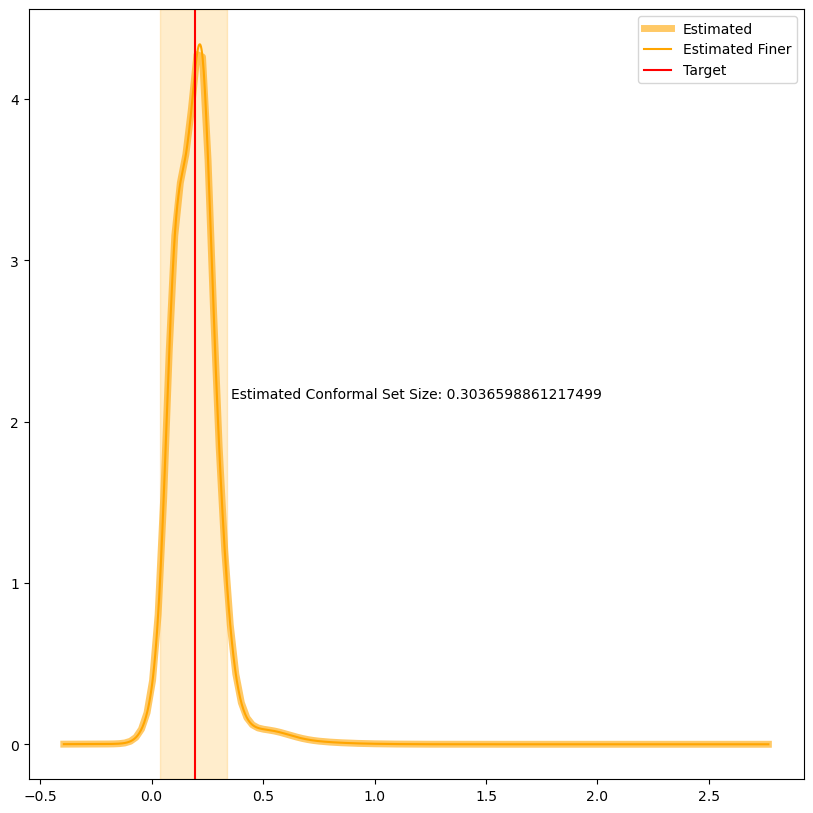

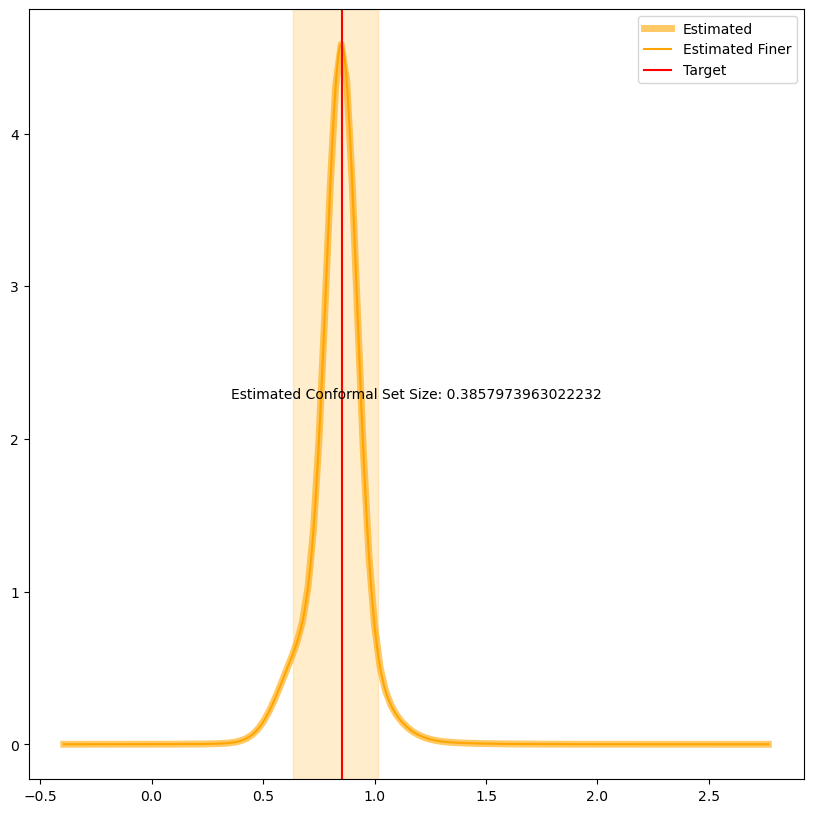

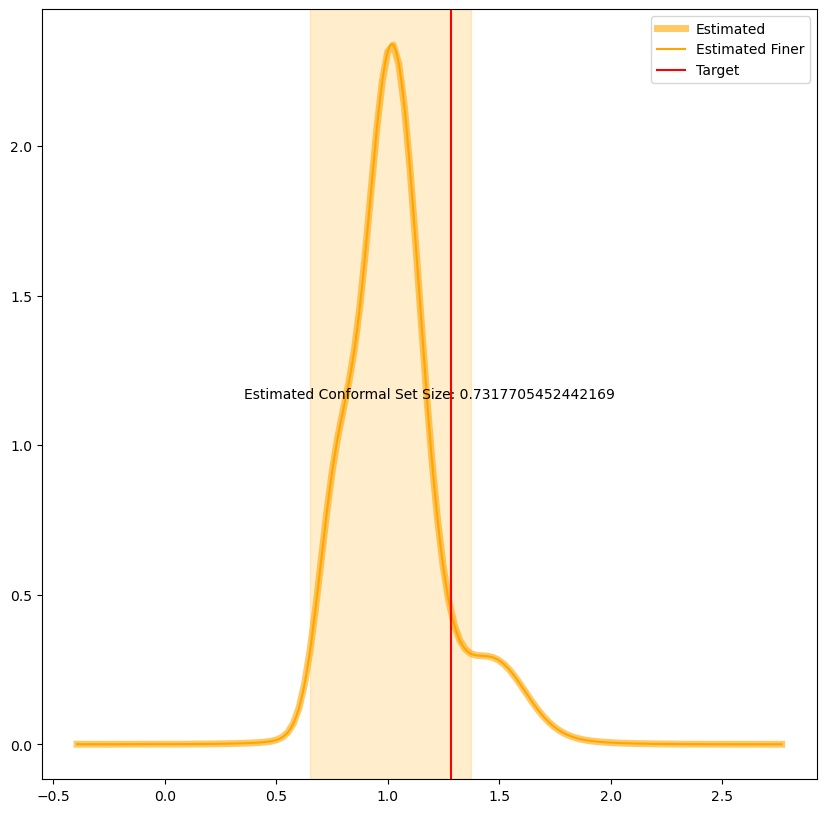

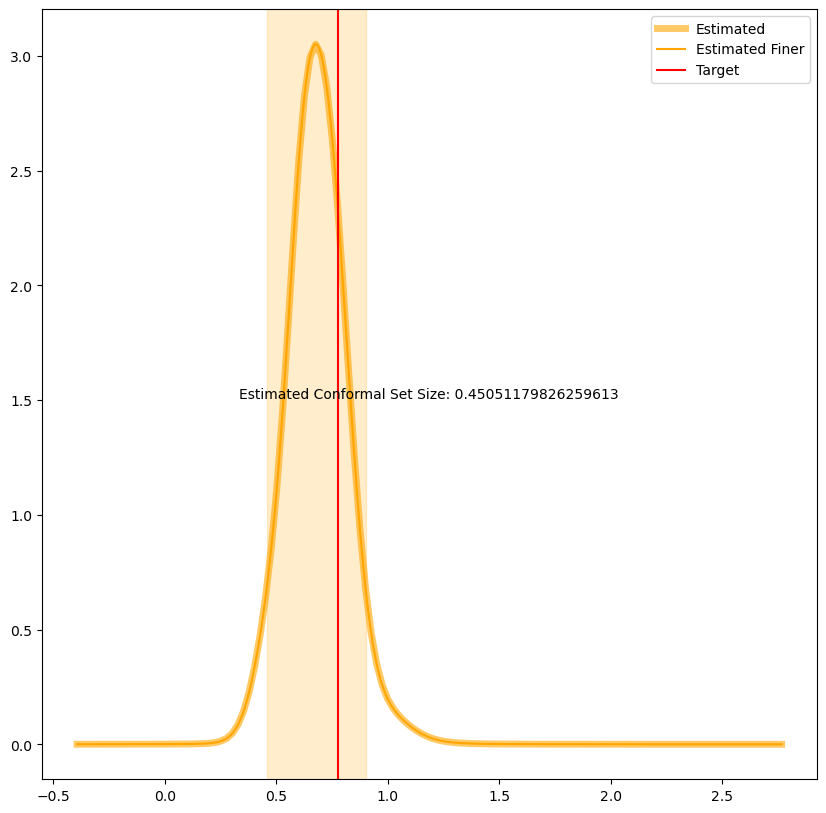

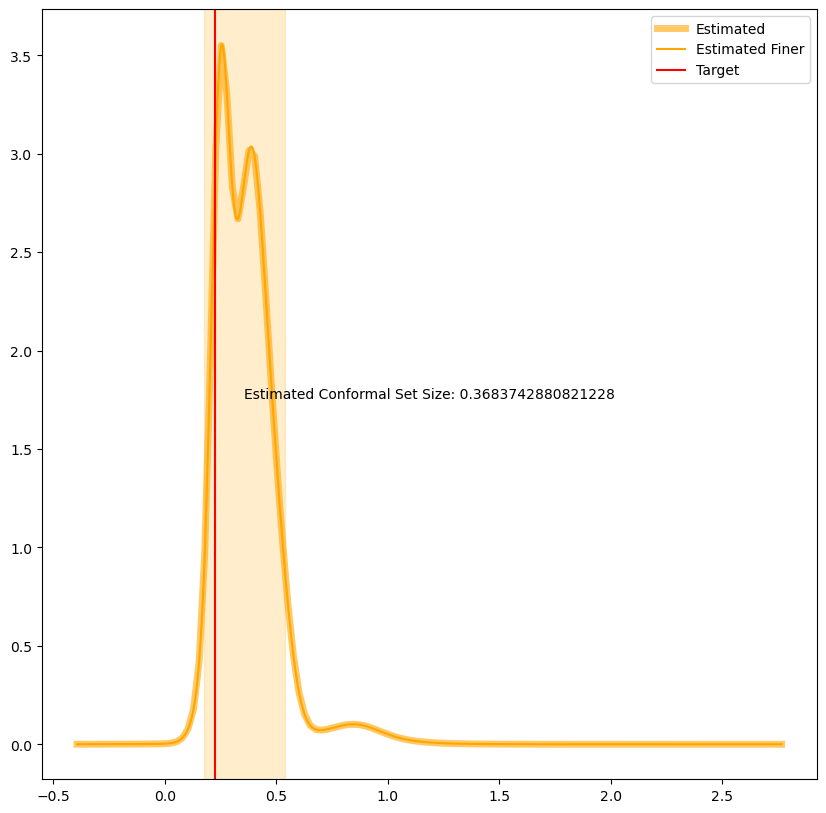

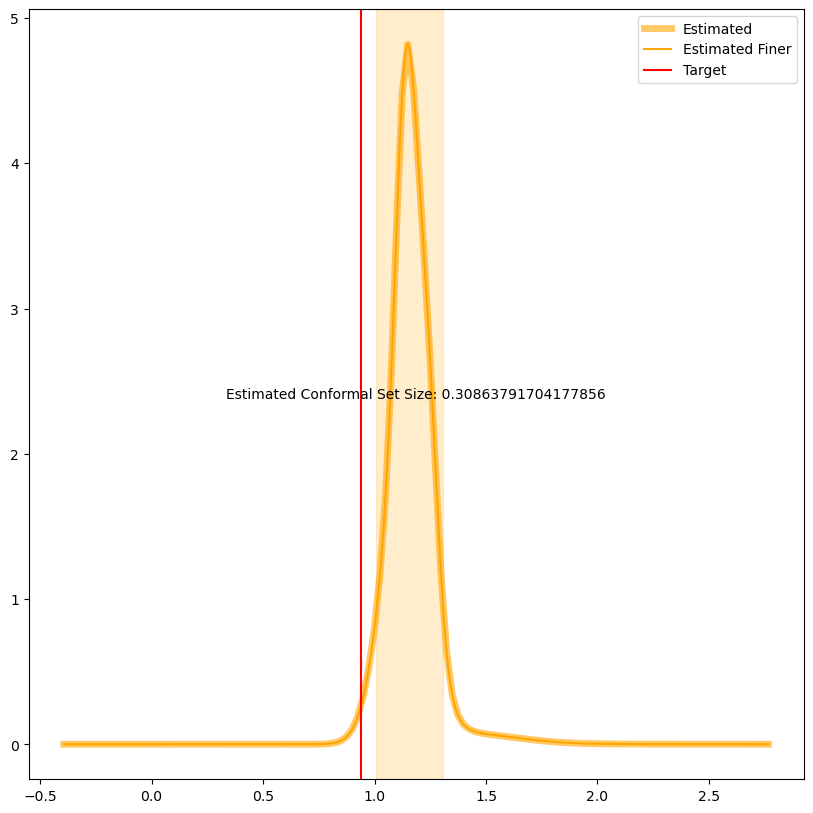

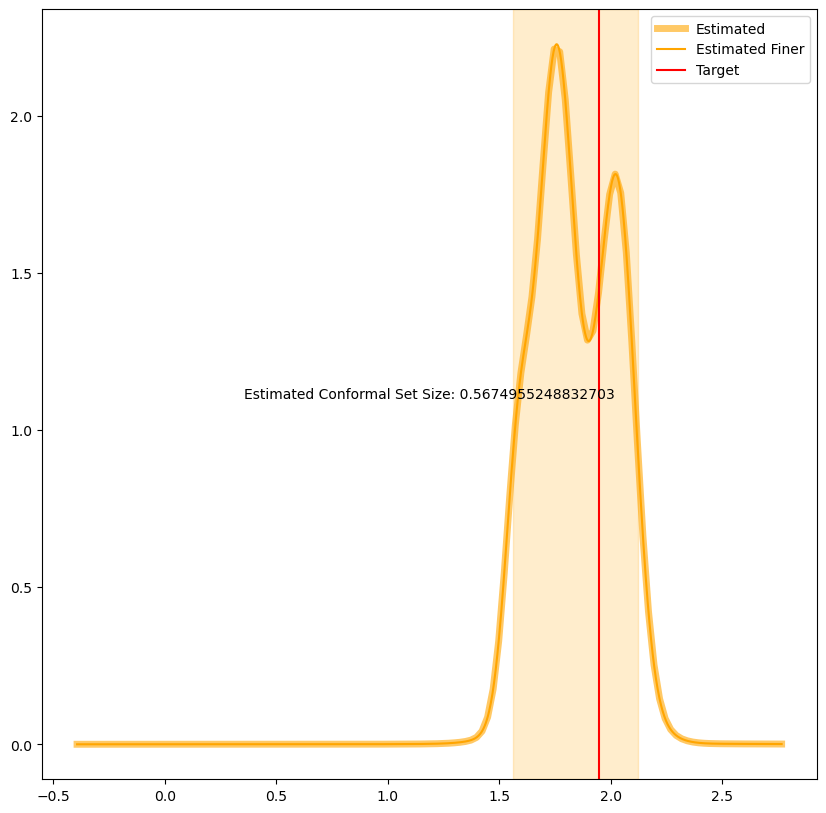

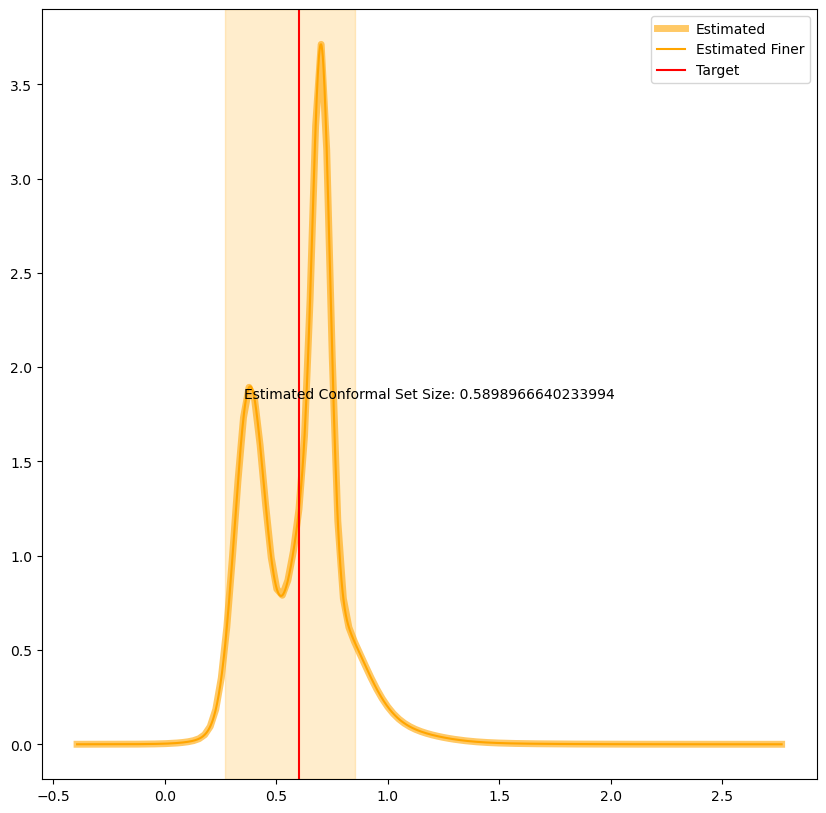

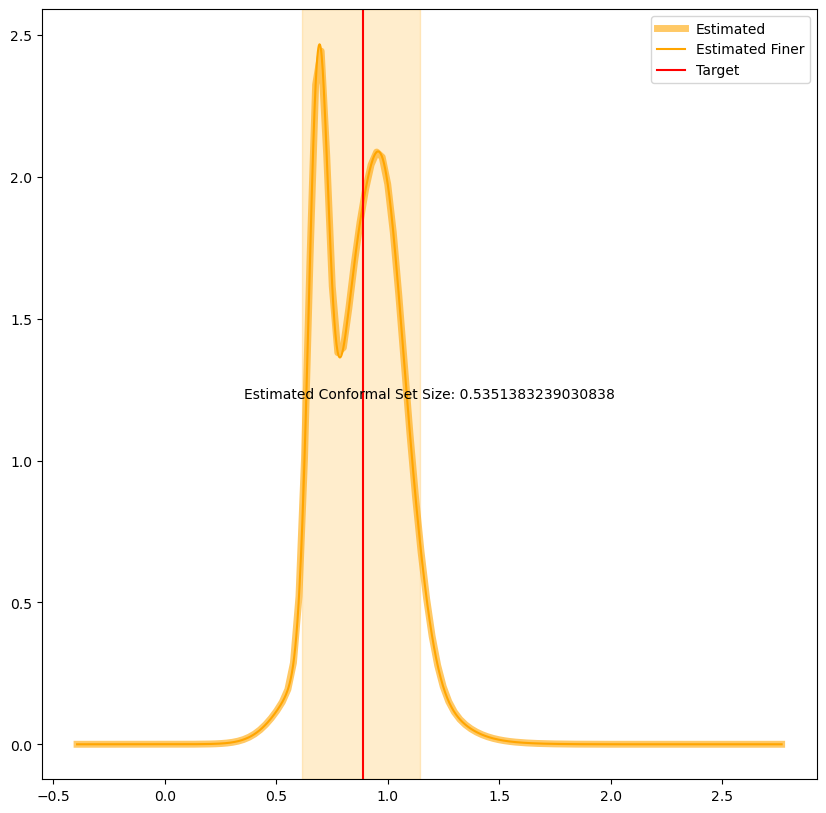

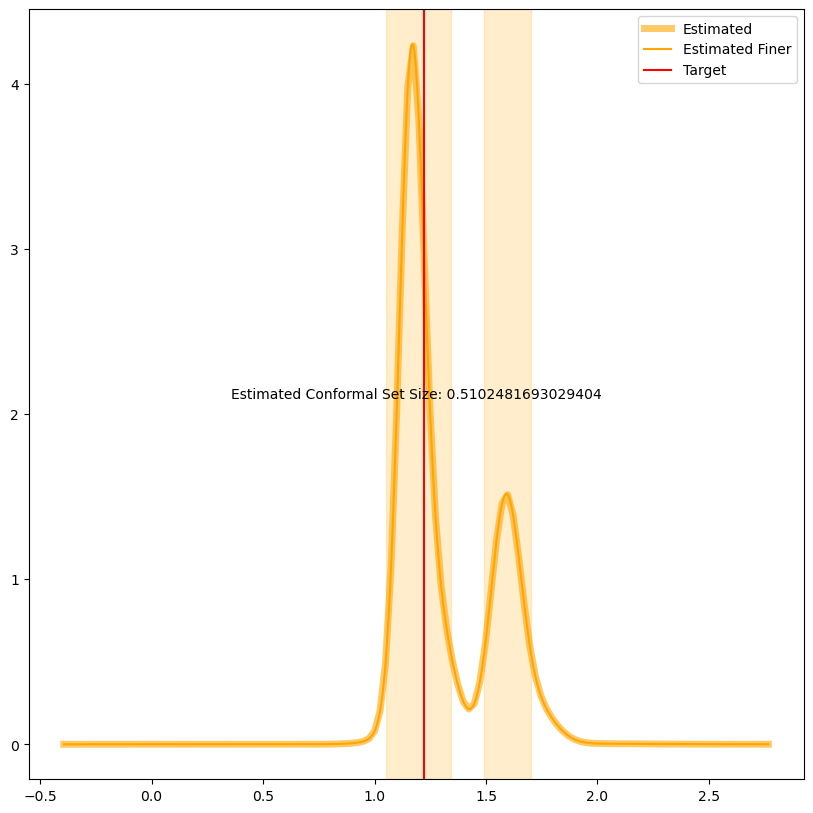

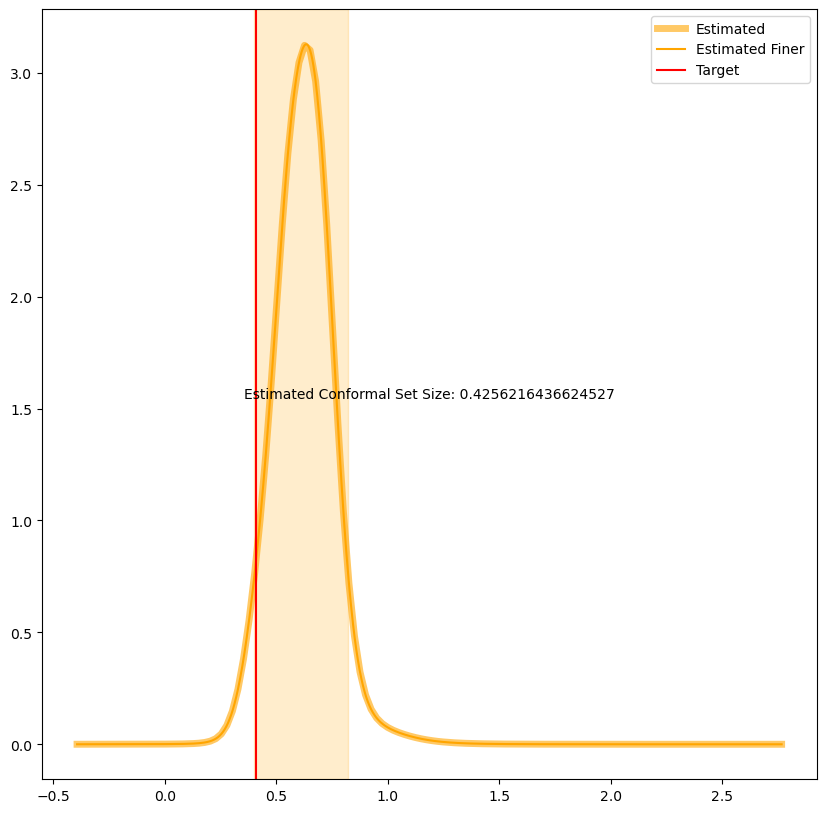

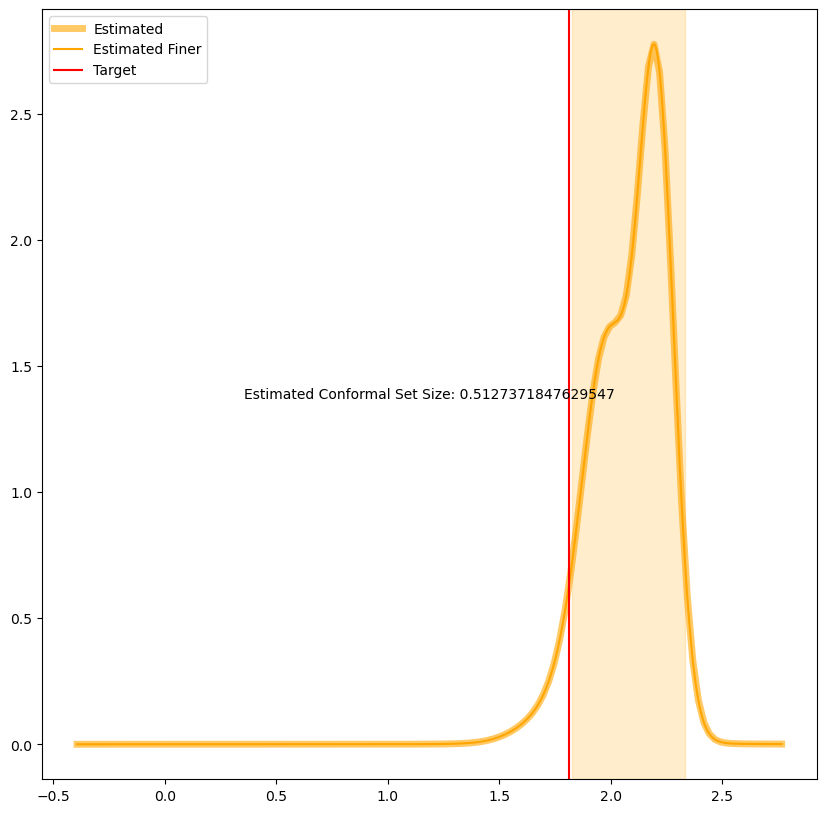

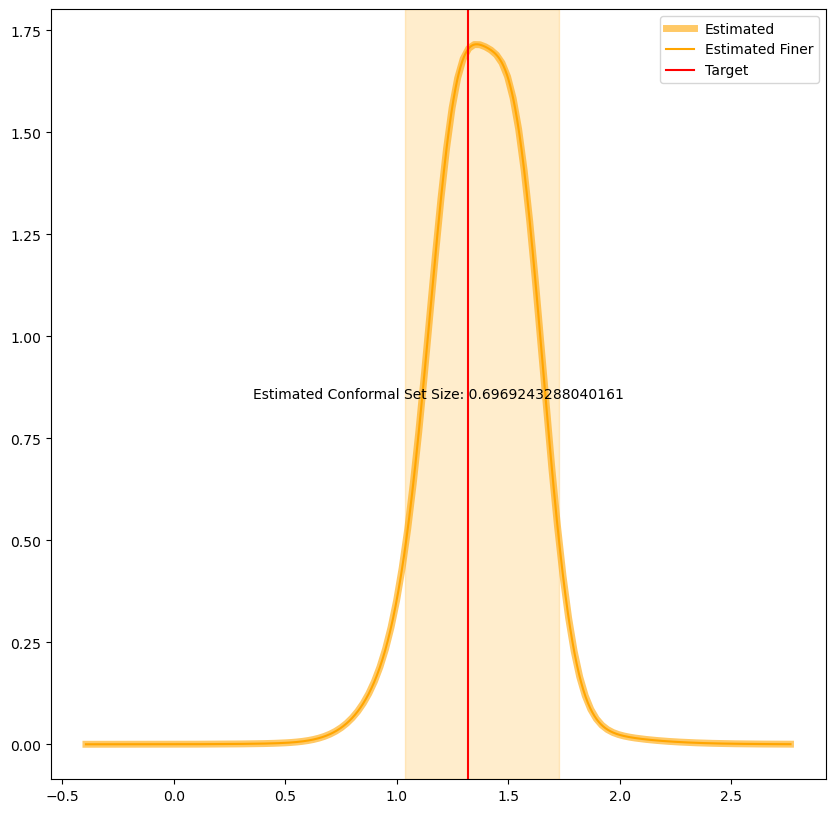

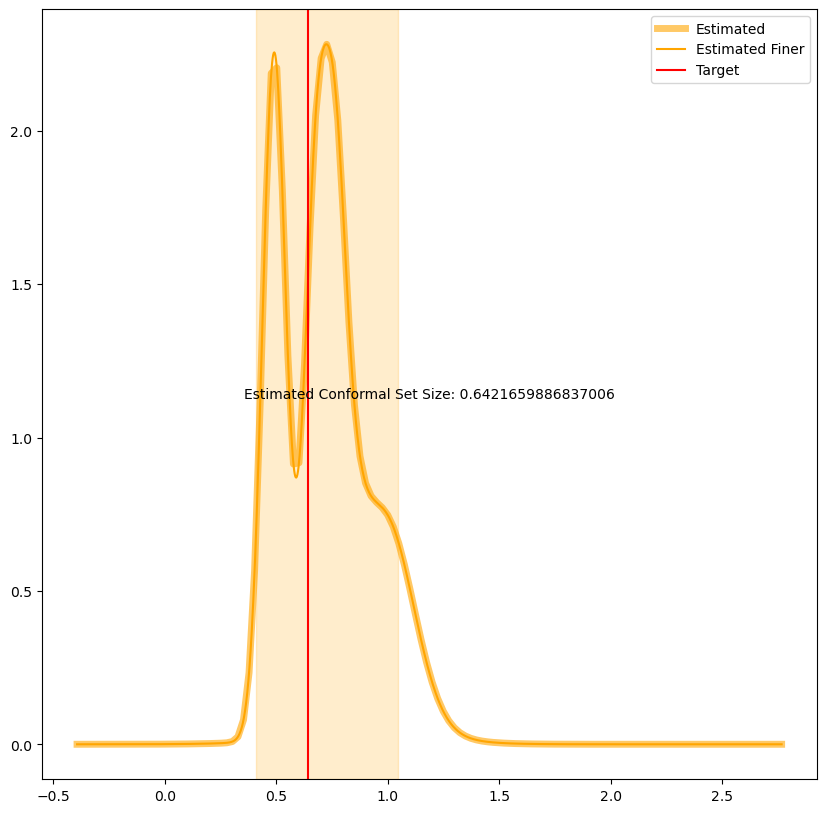

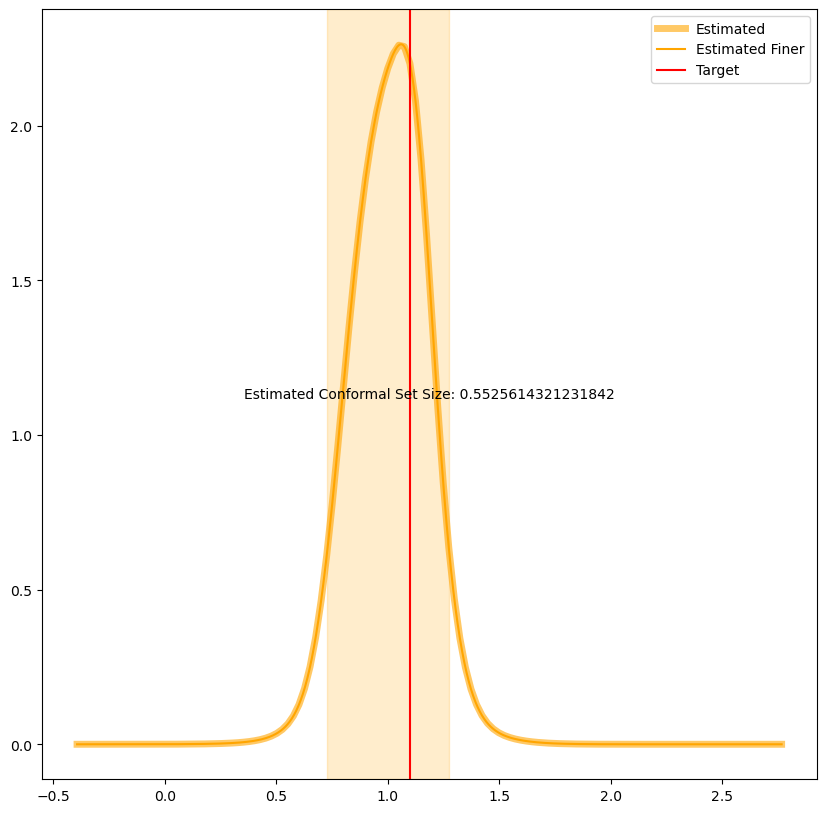

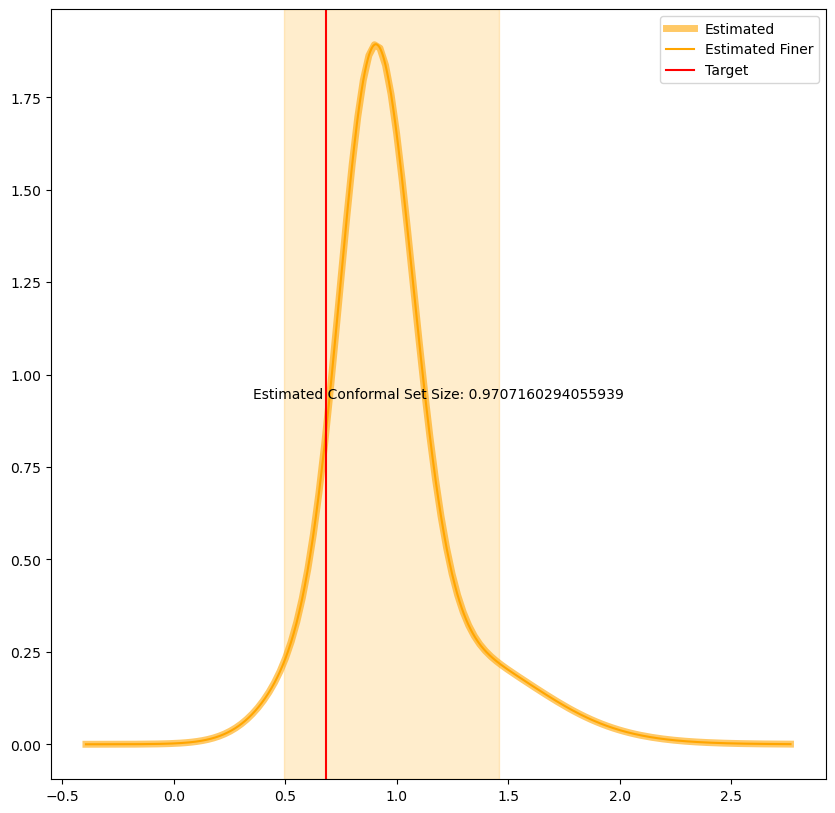

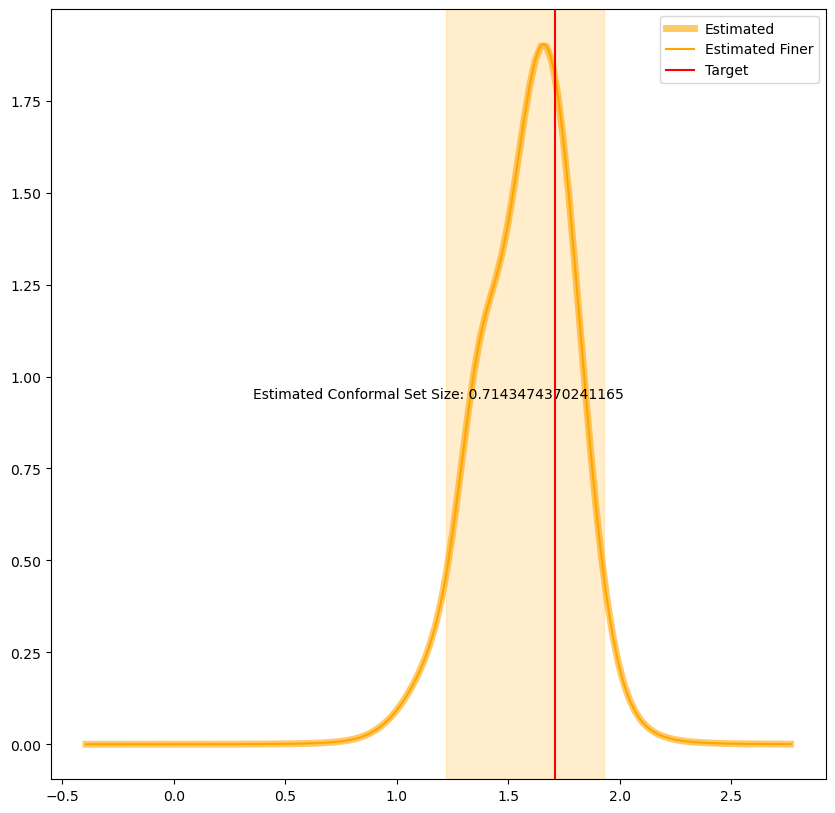

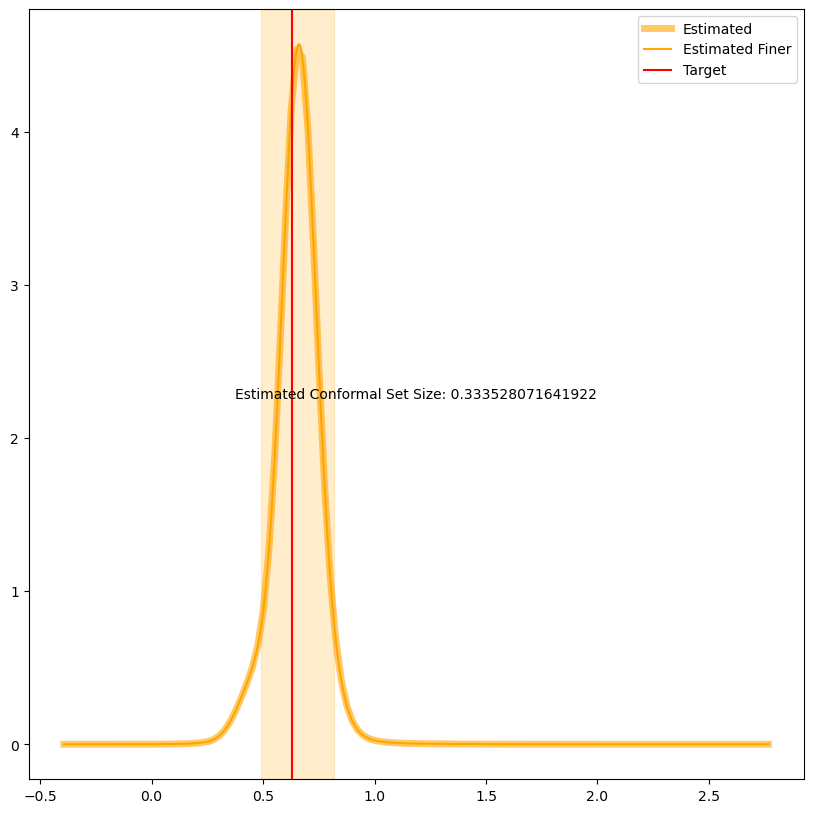

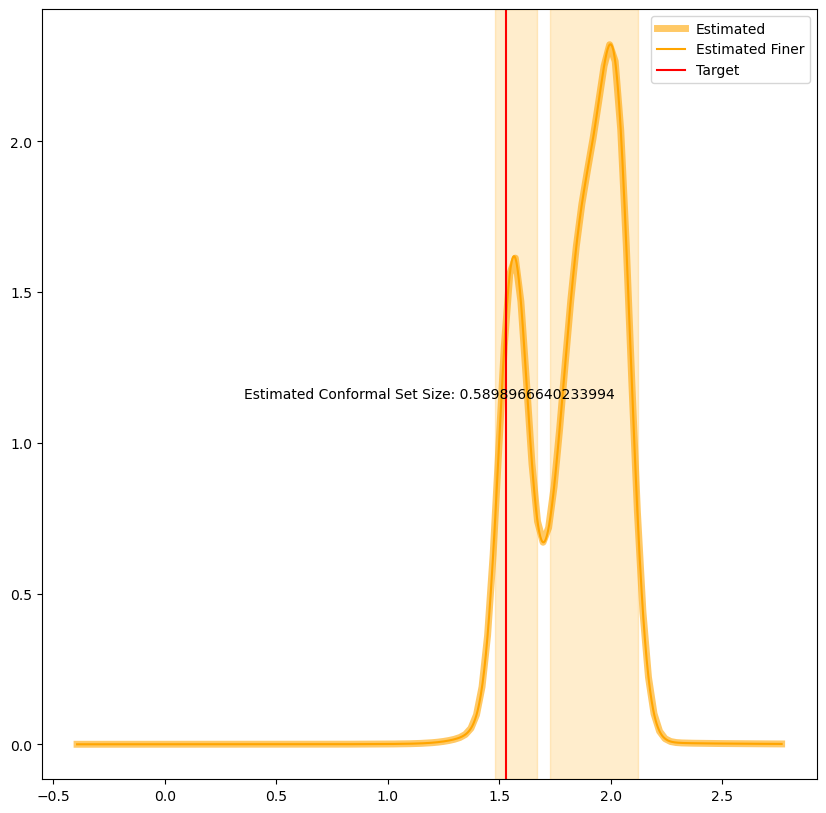

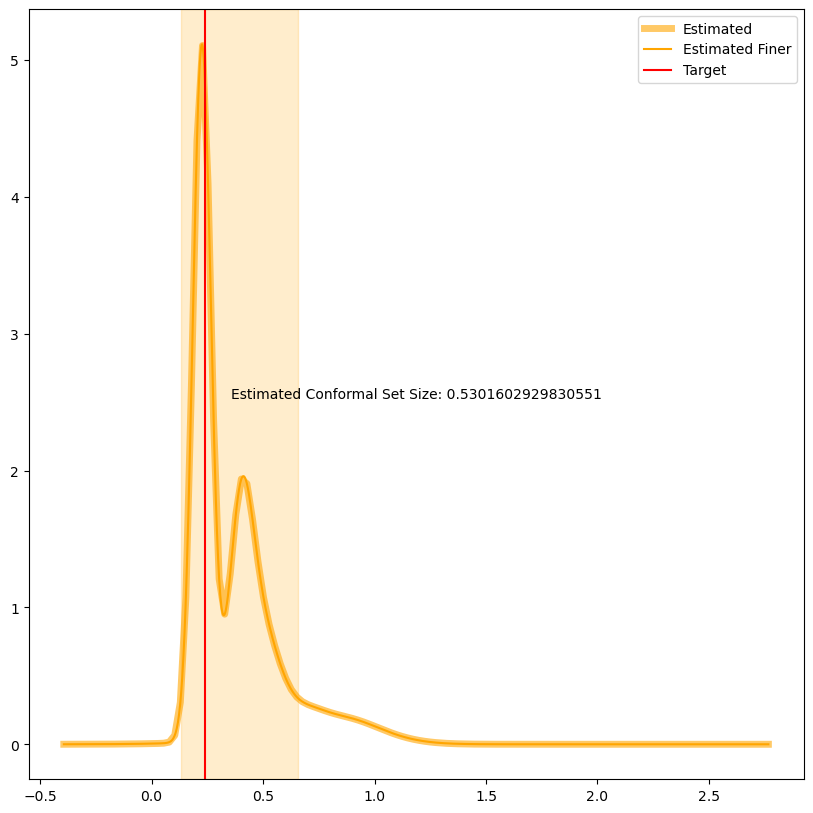

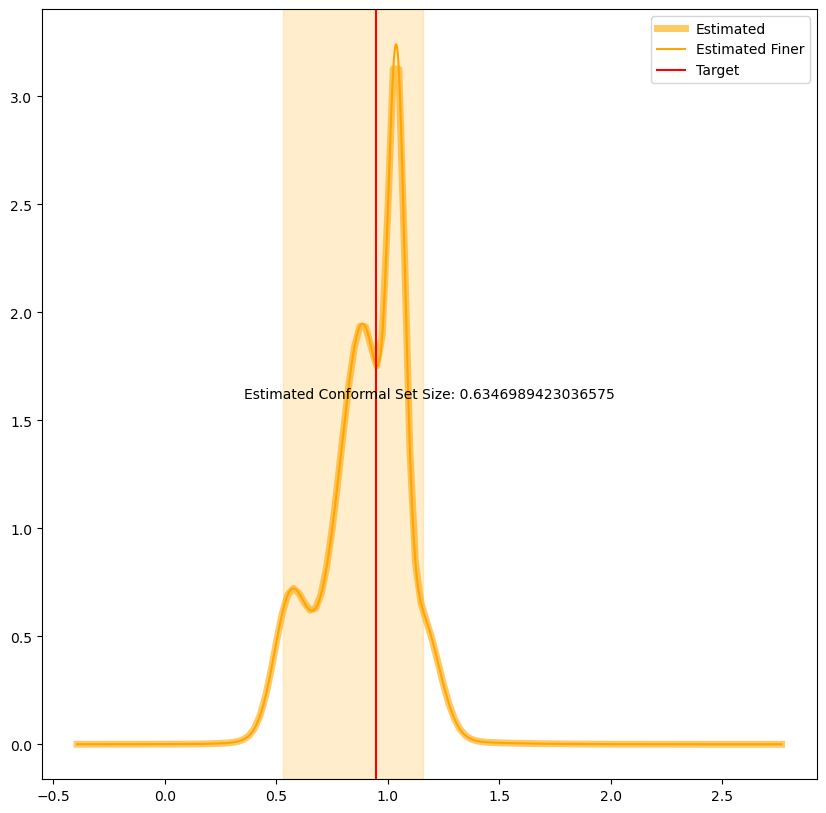

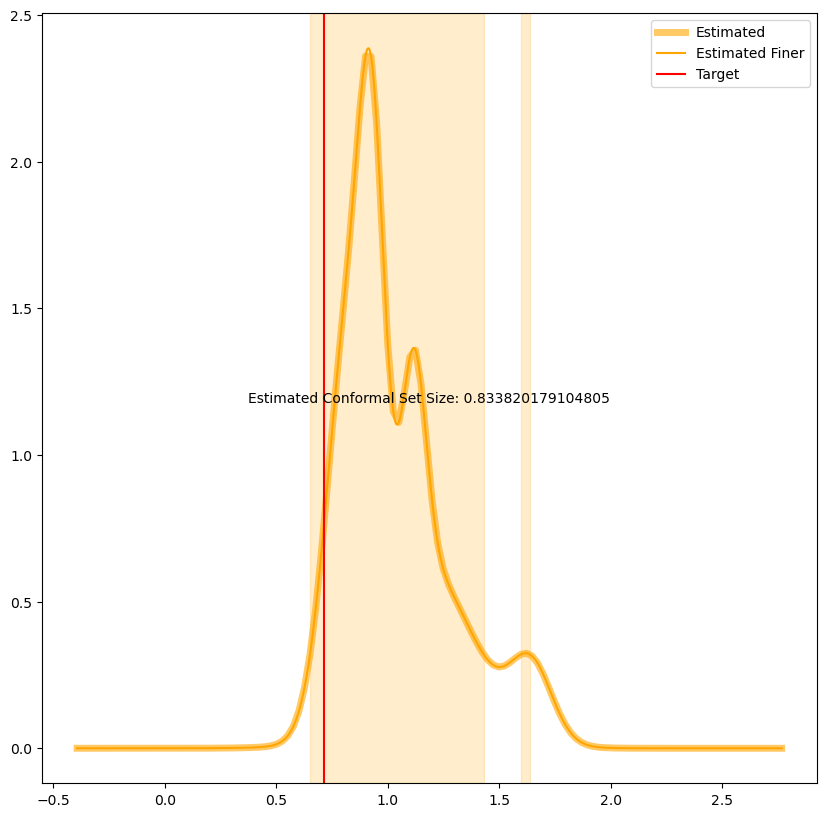

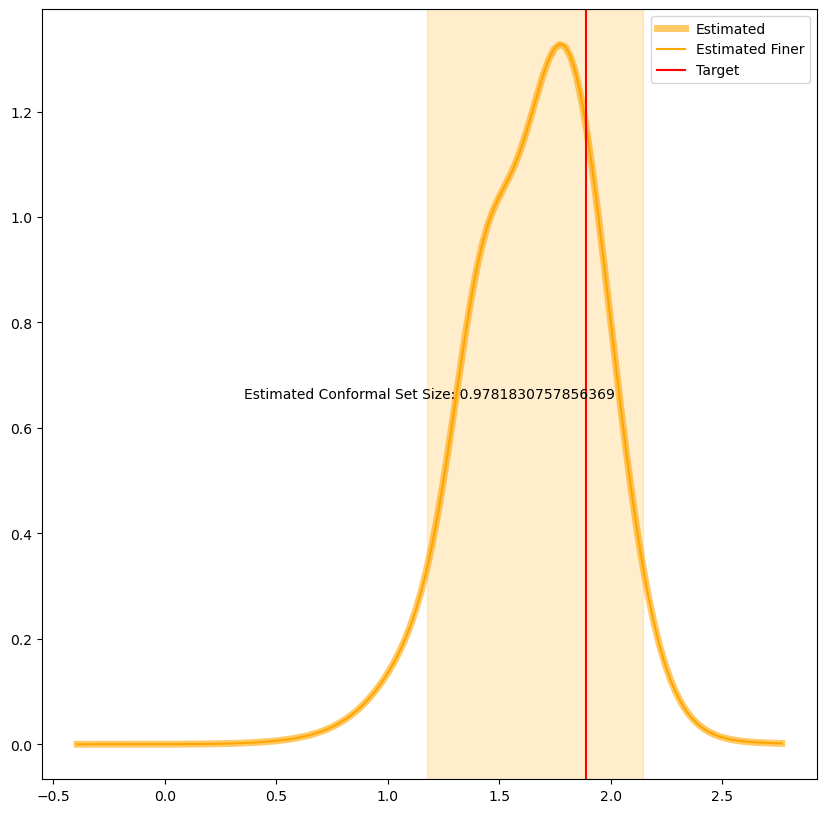

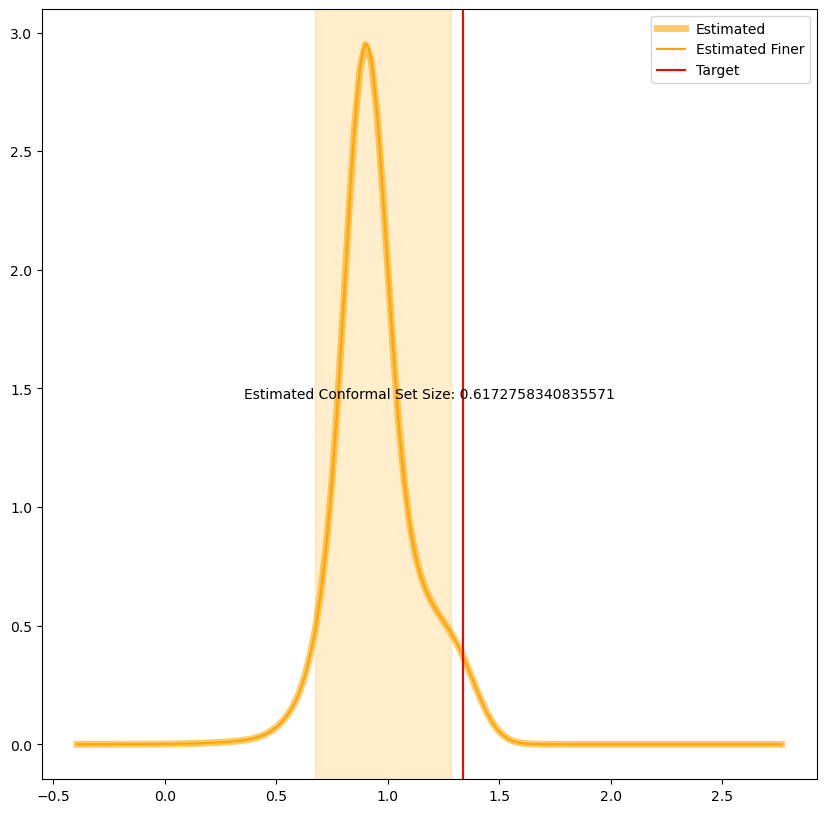

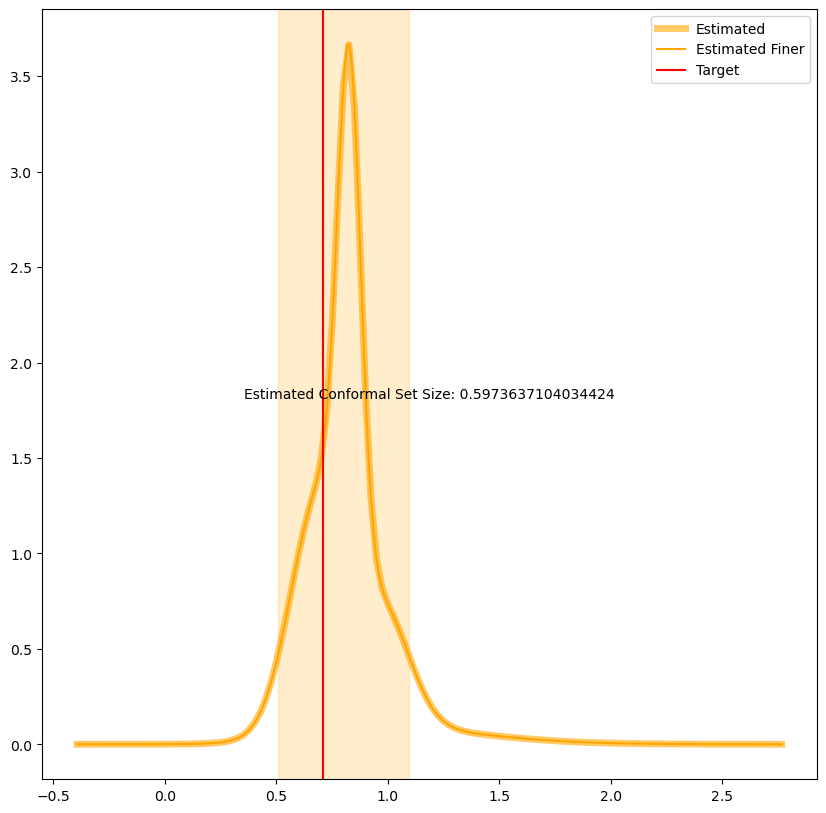

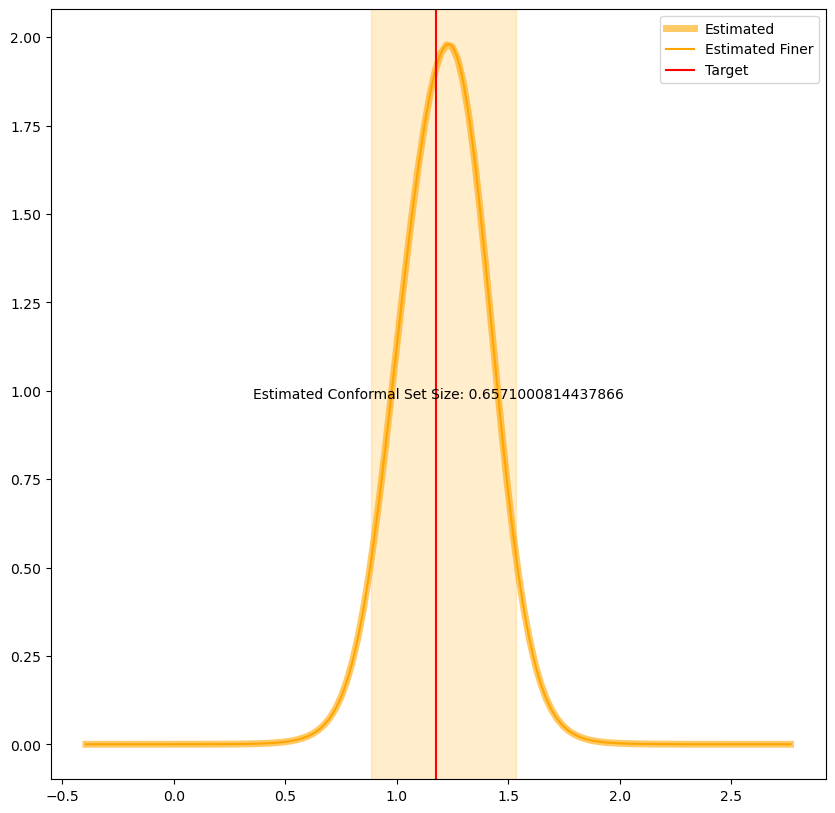

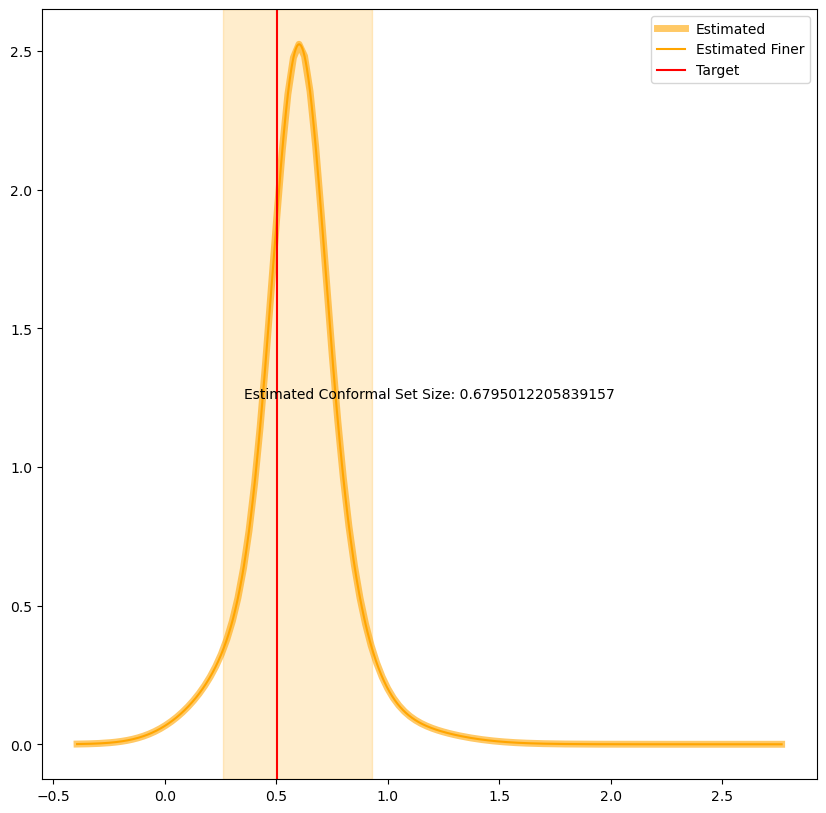

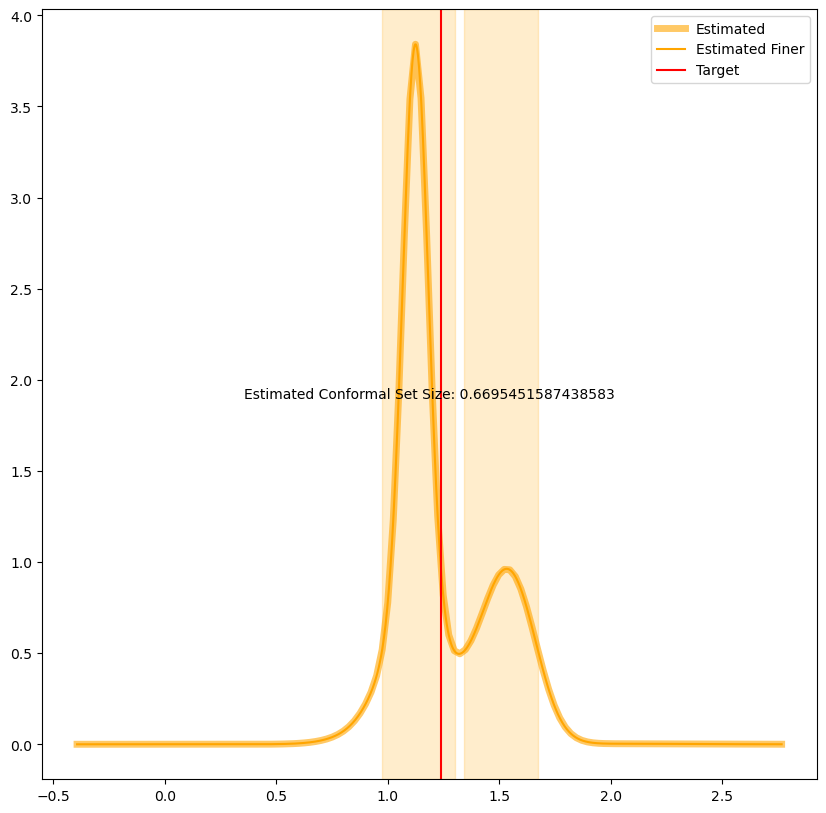

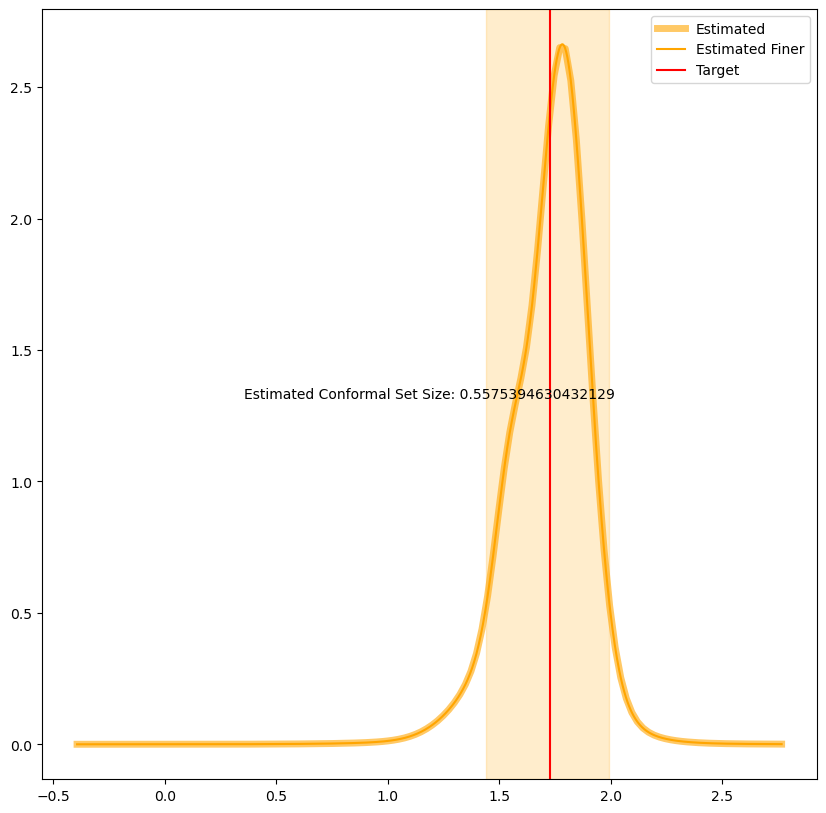

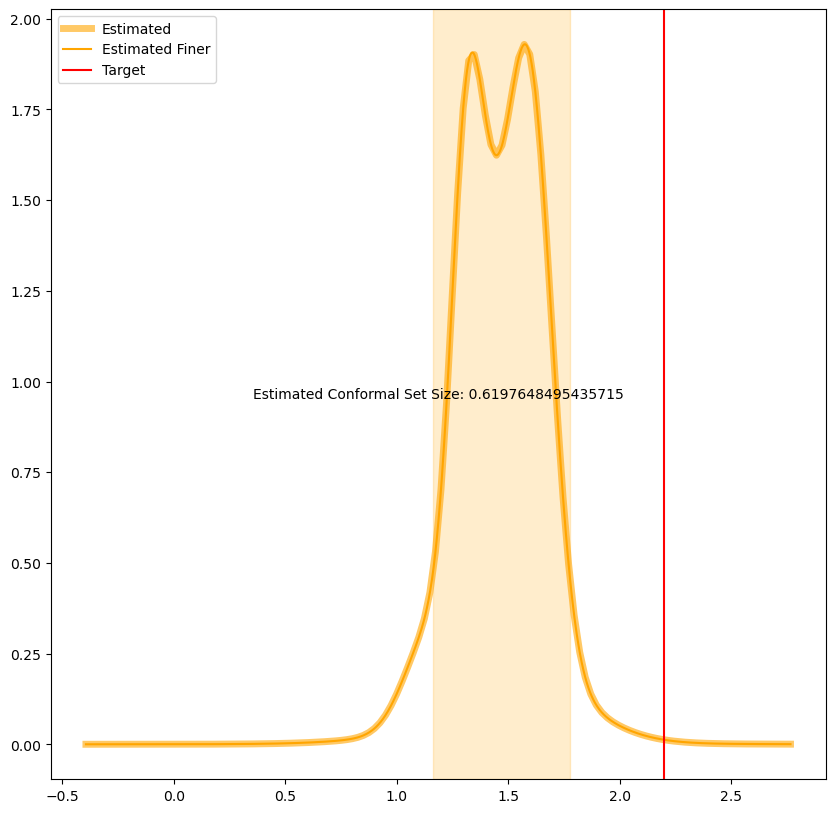

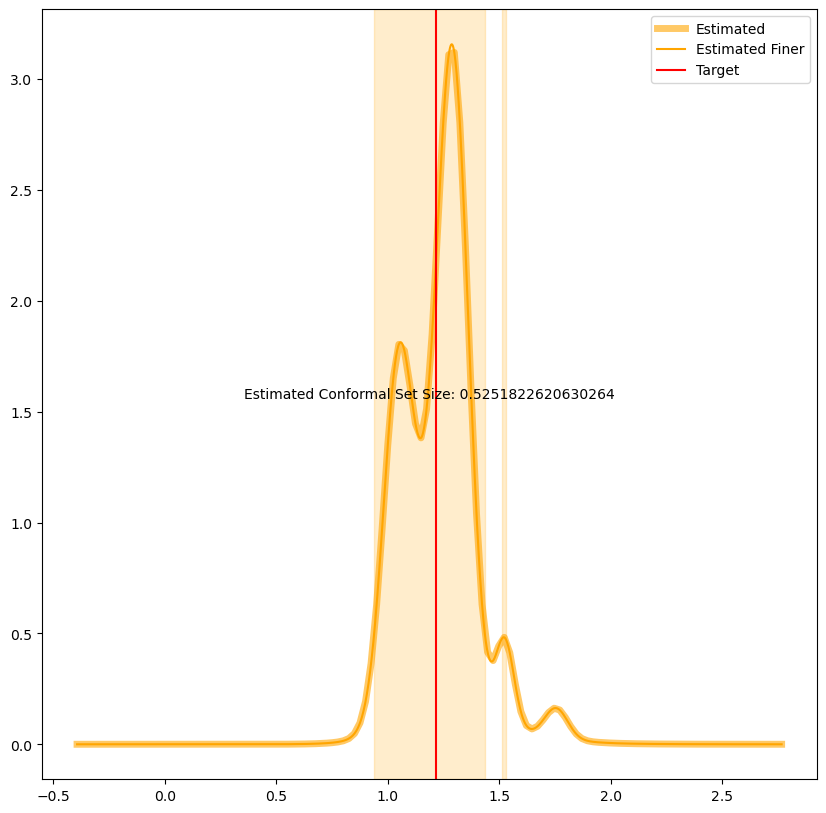

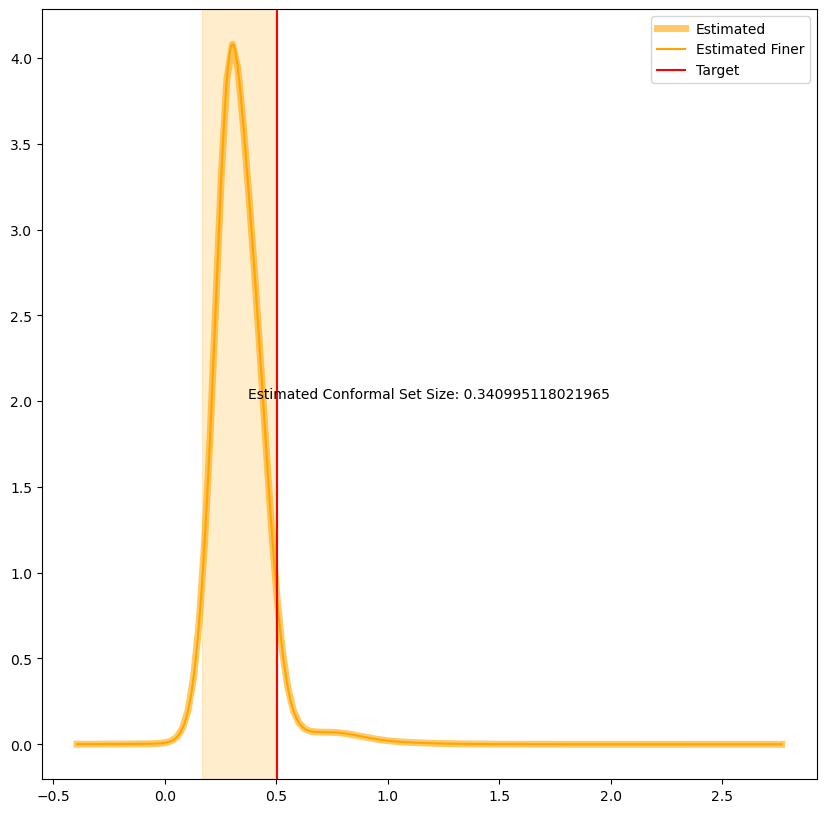

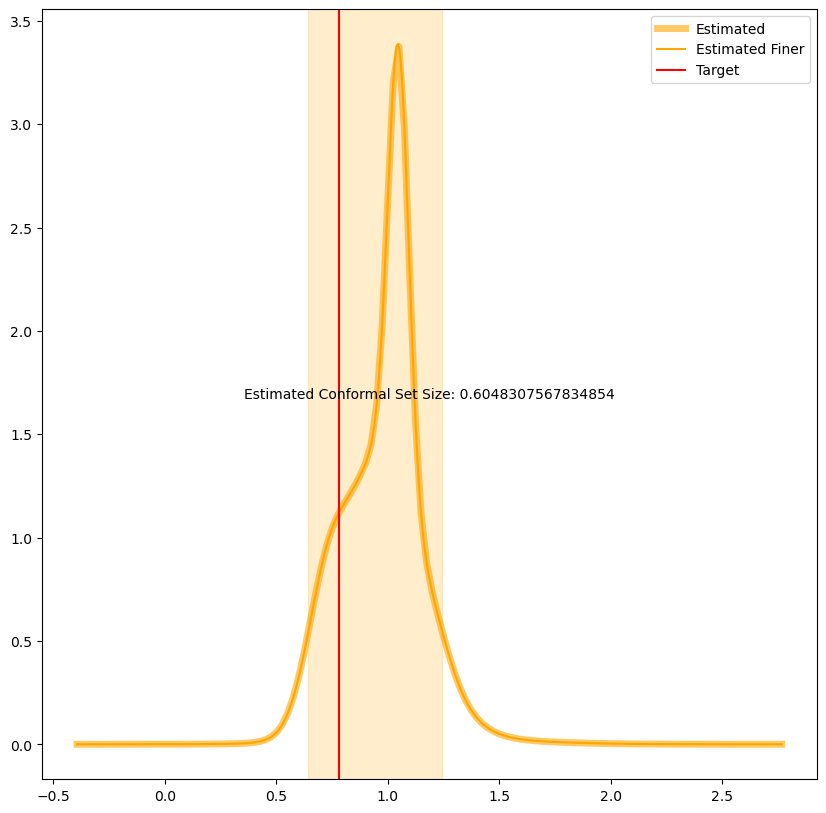

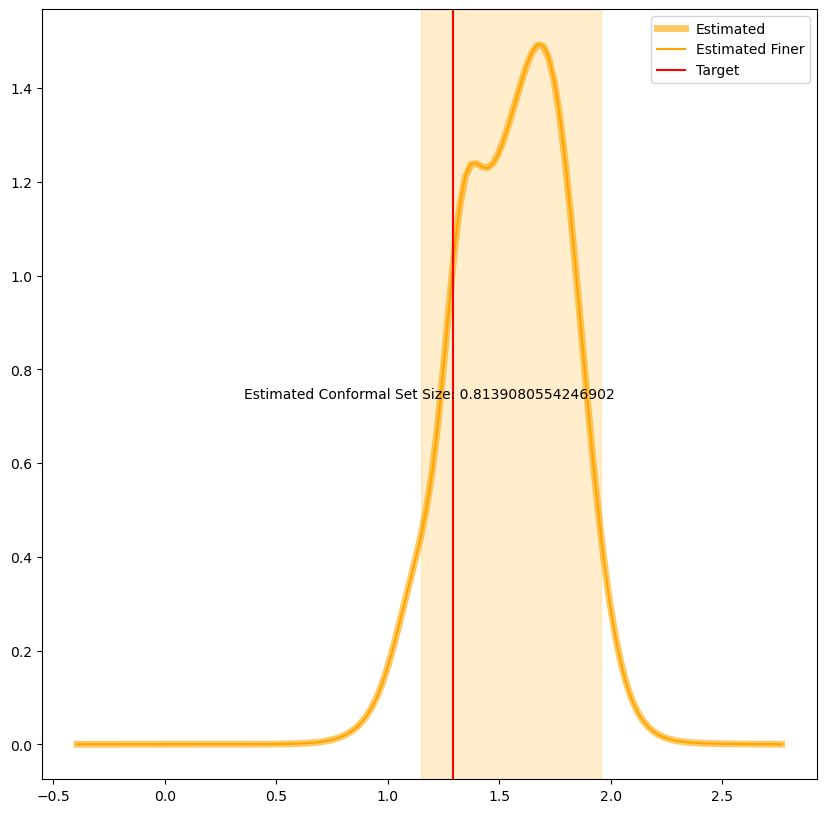

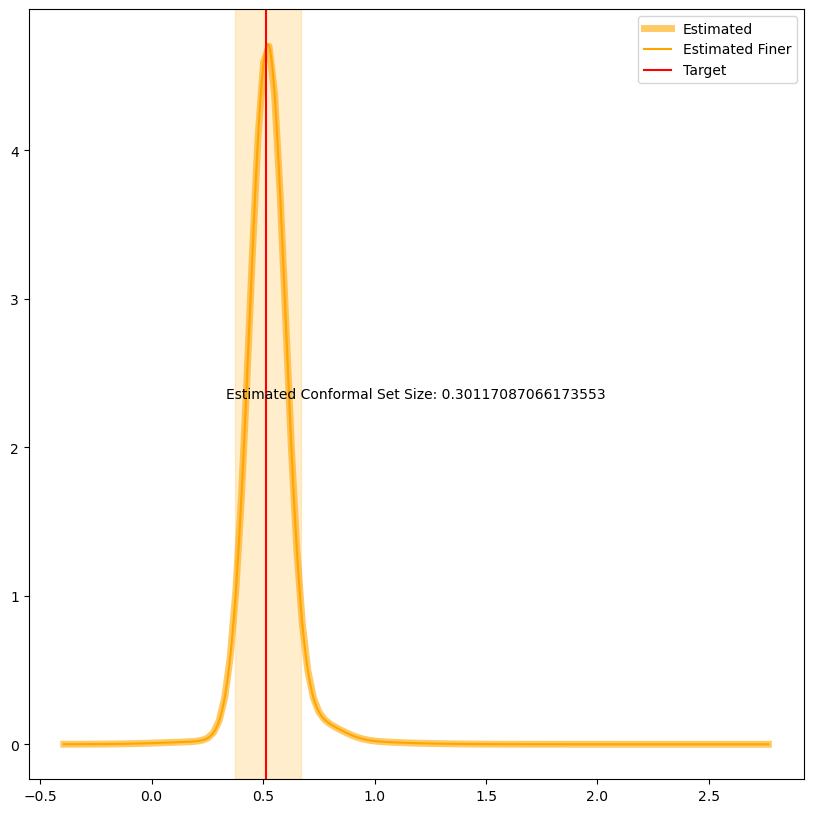

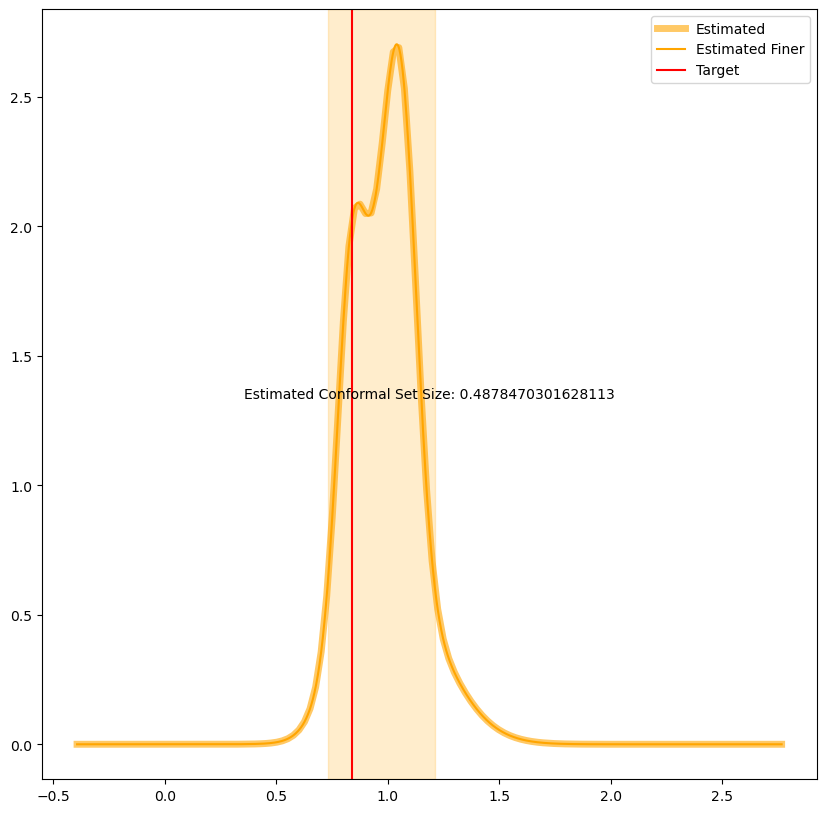

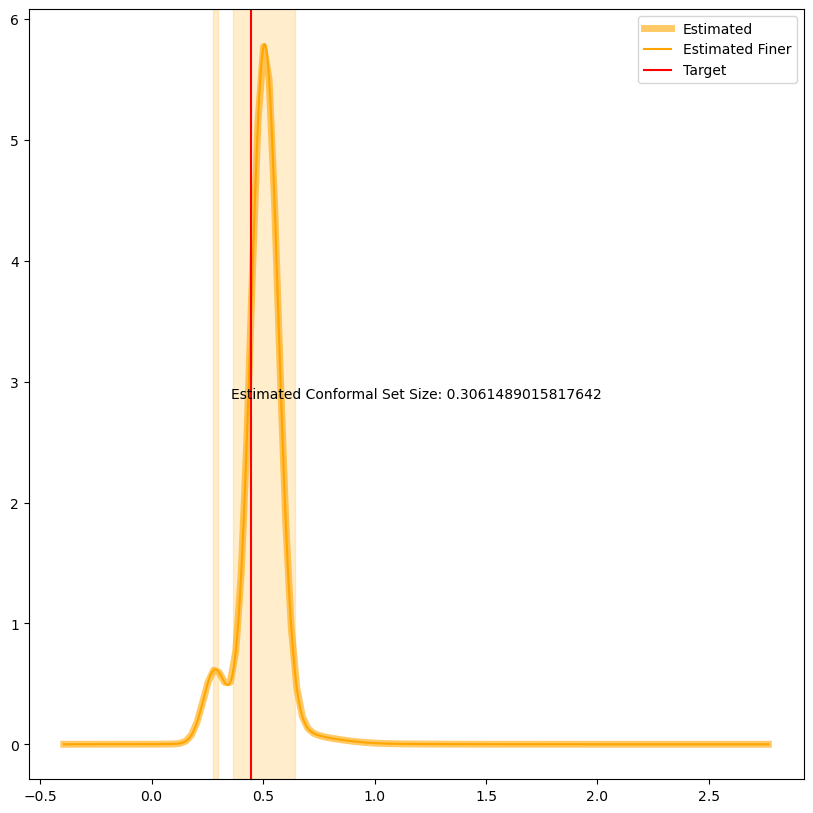

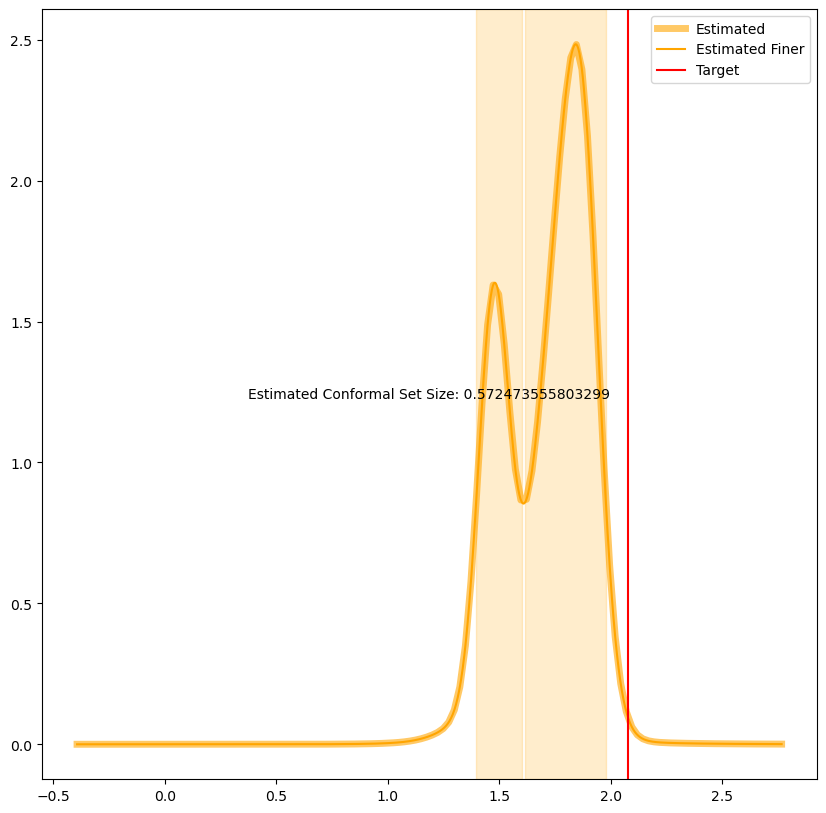

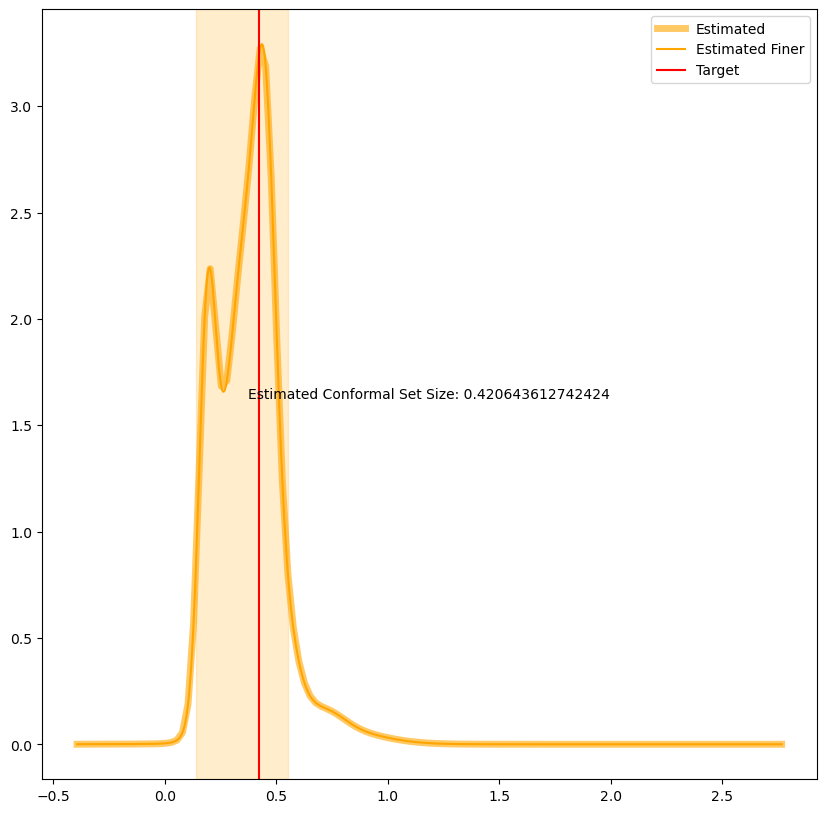

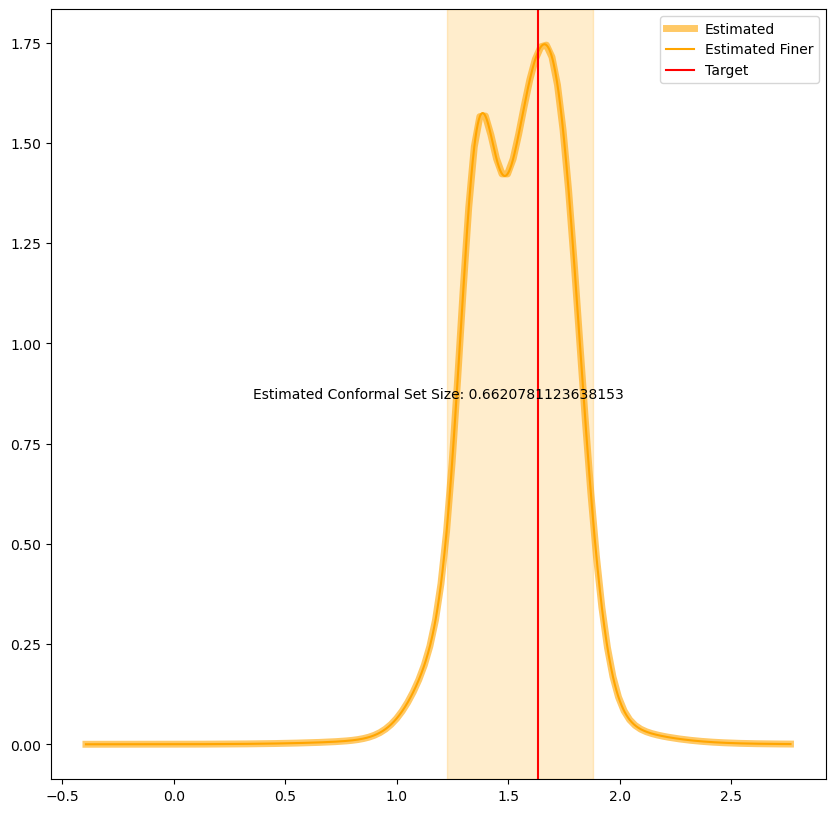

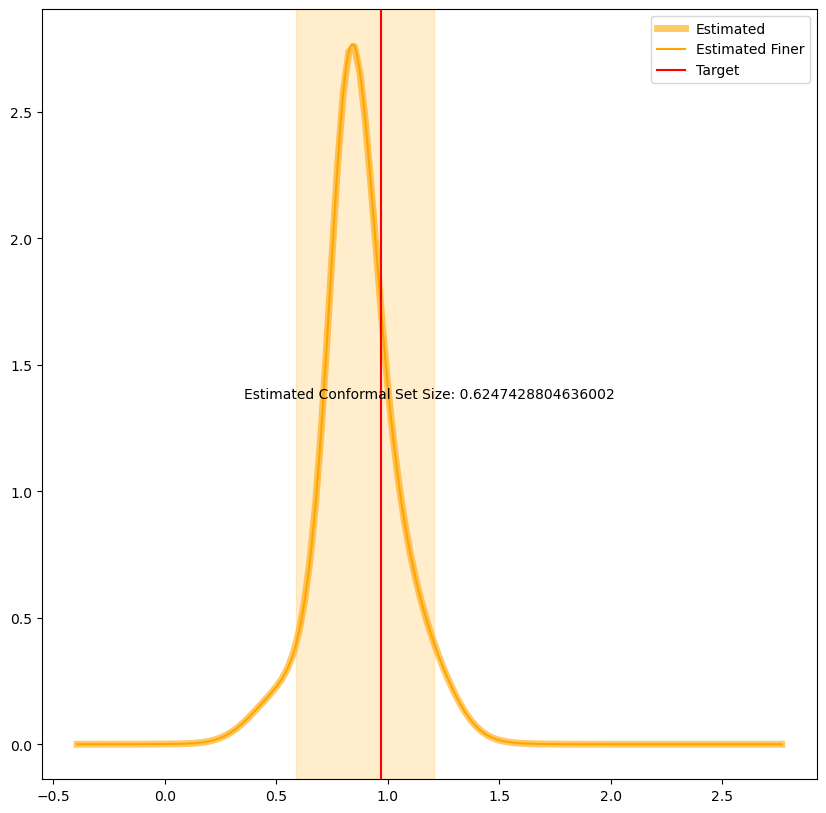

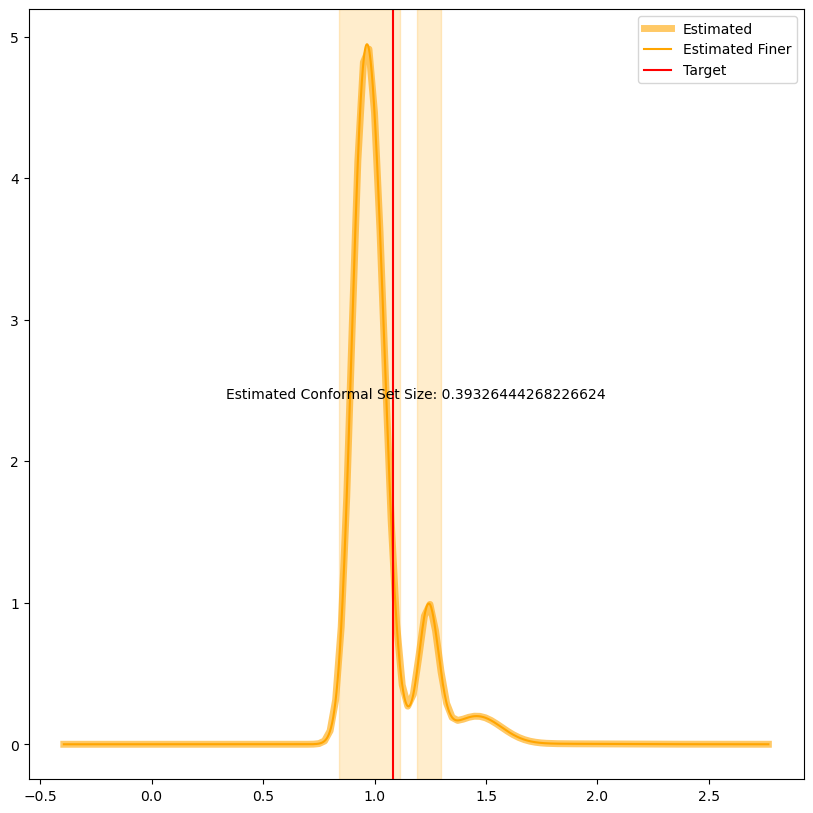

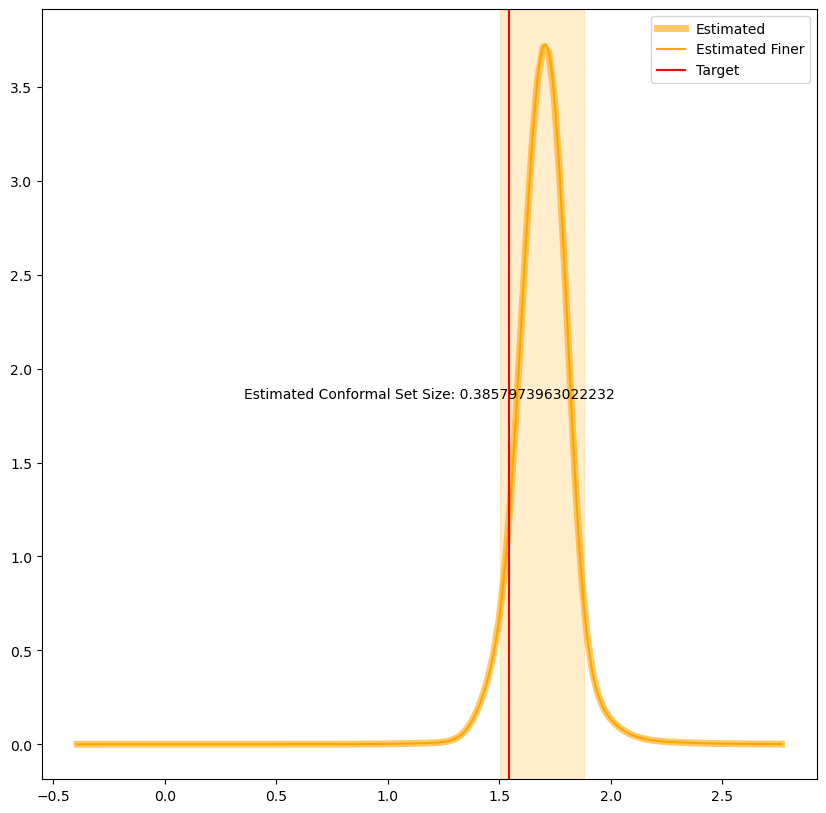

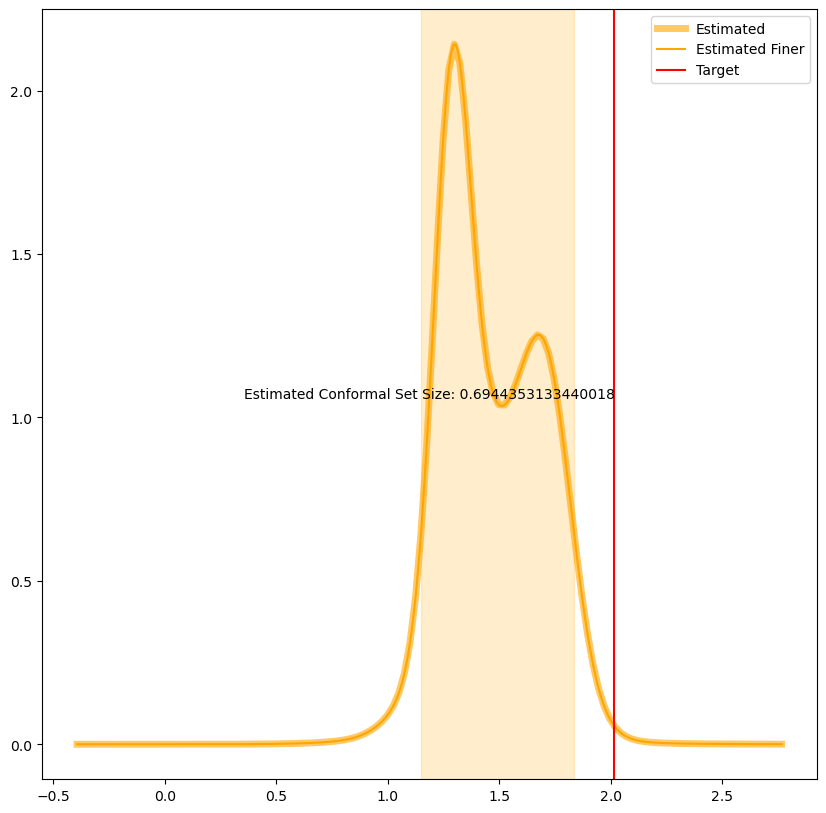

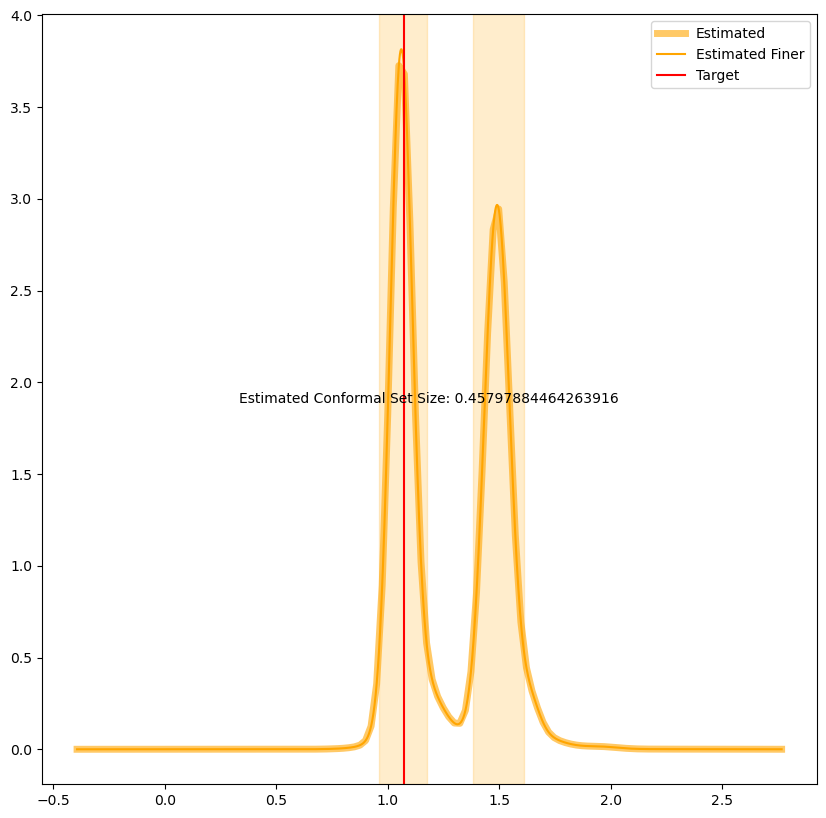

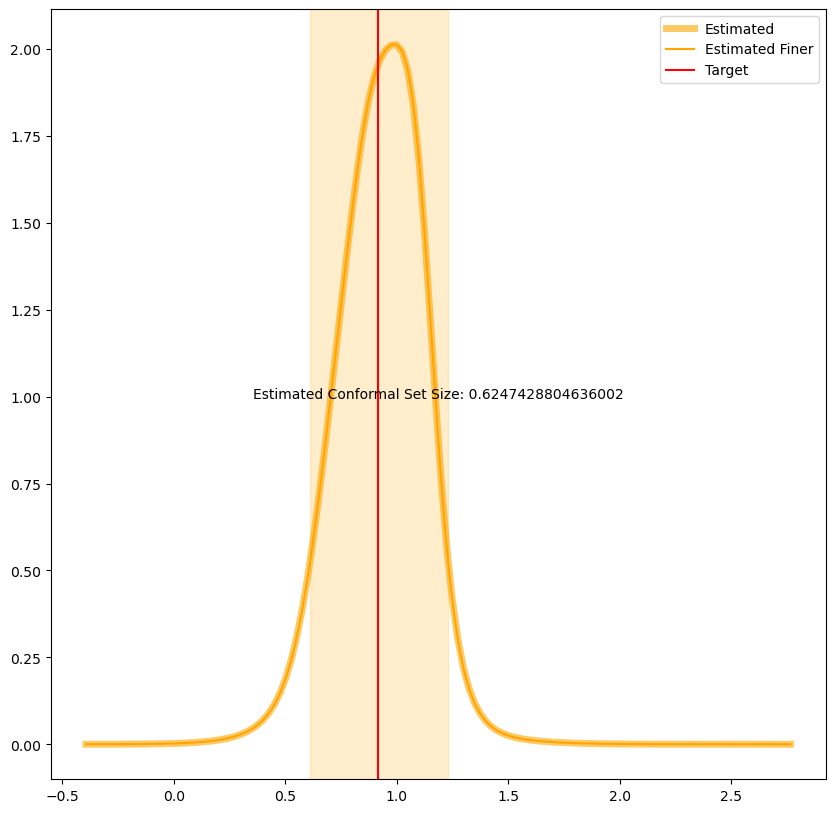

 67%|██████▋   | 2/3 [00:24<00:12, 12.39s/it]

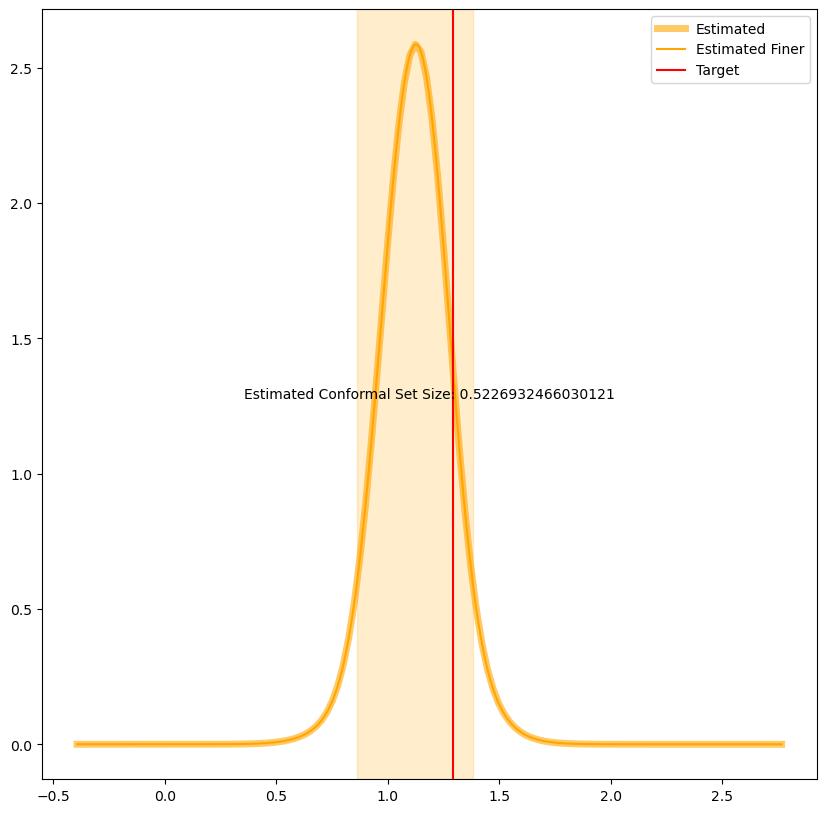

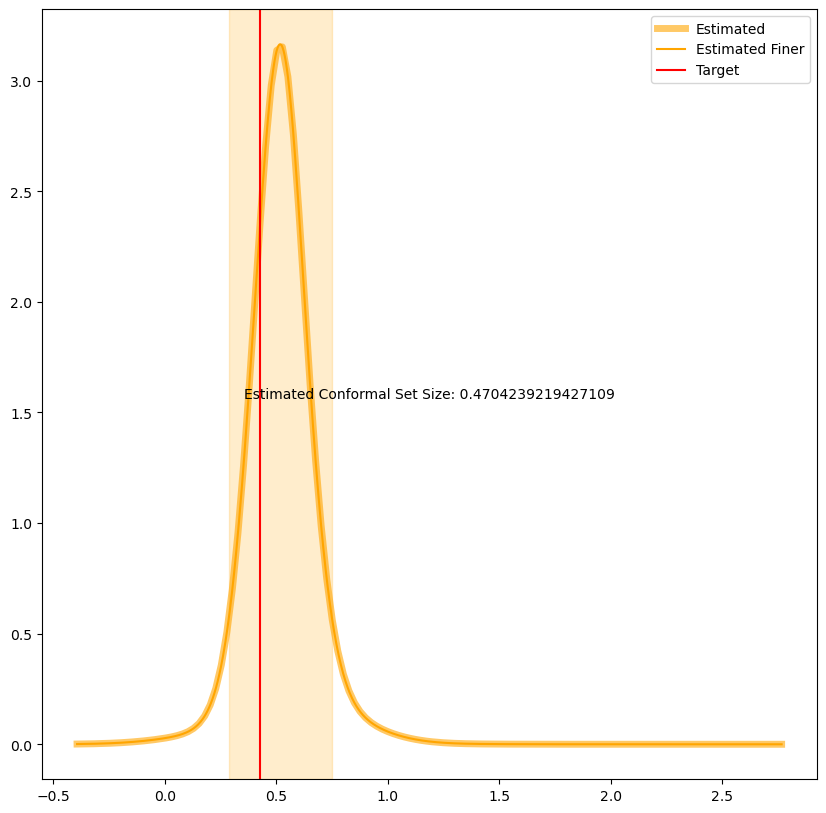

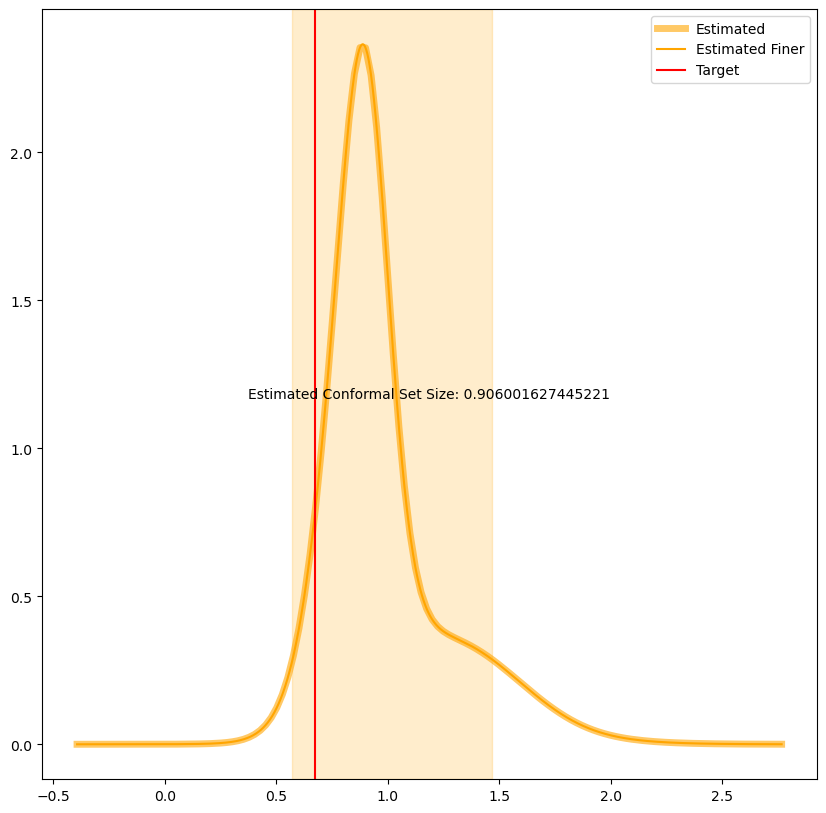

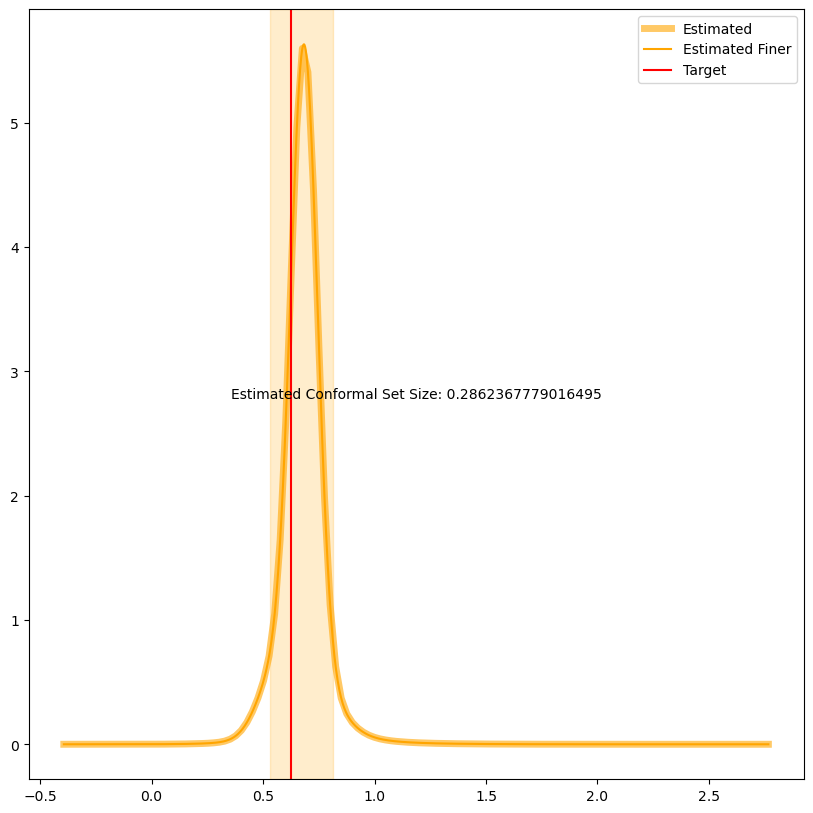

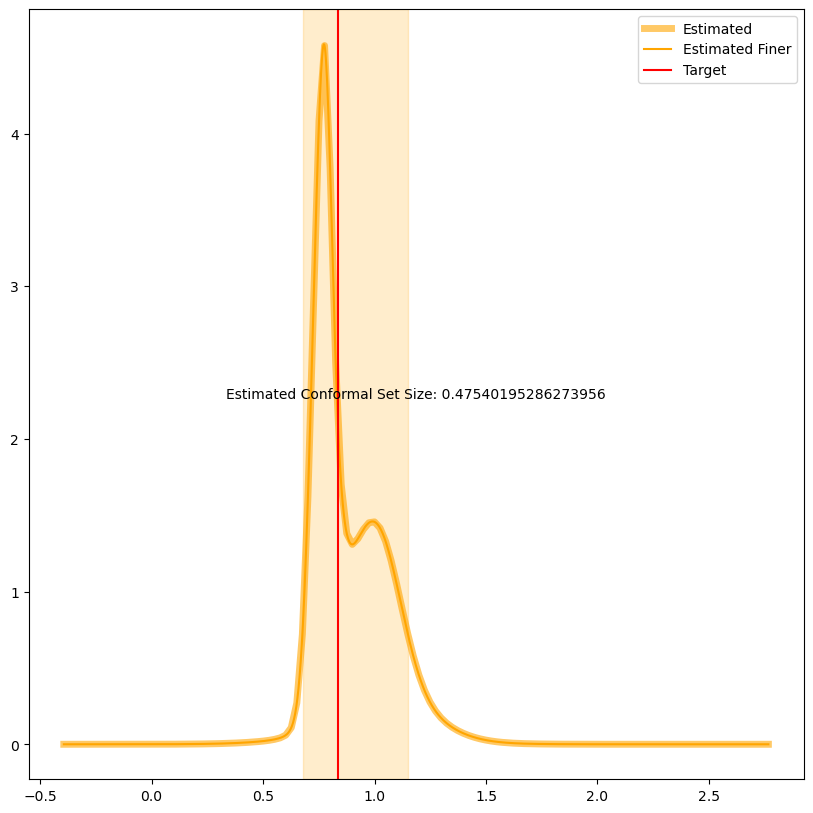

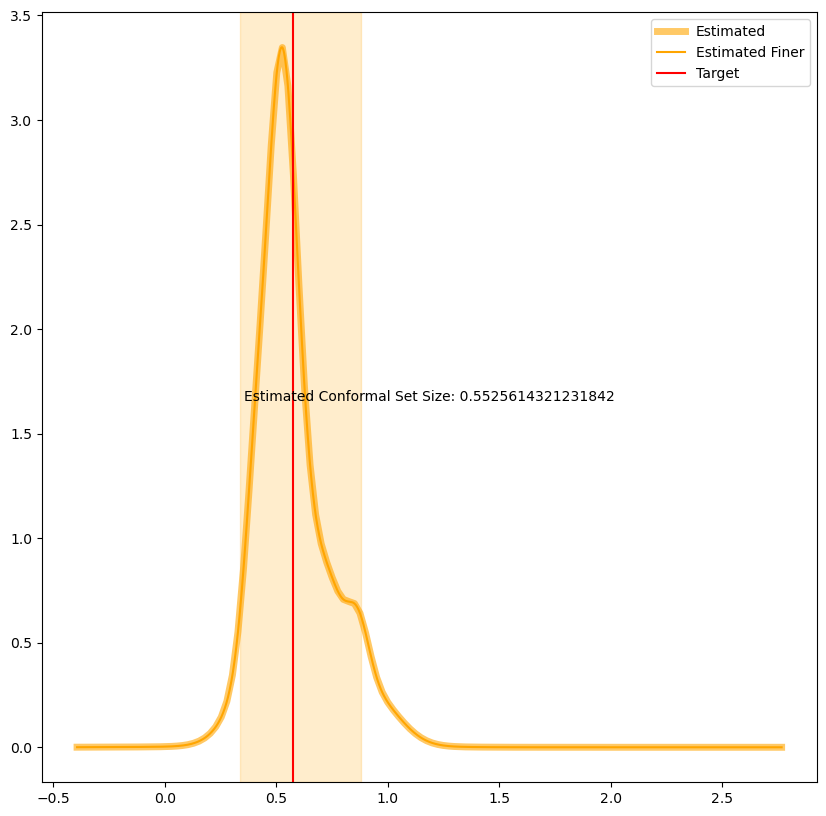

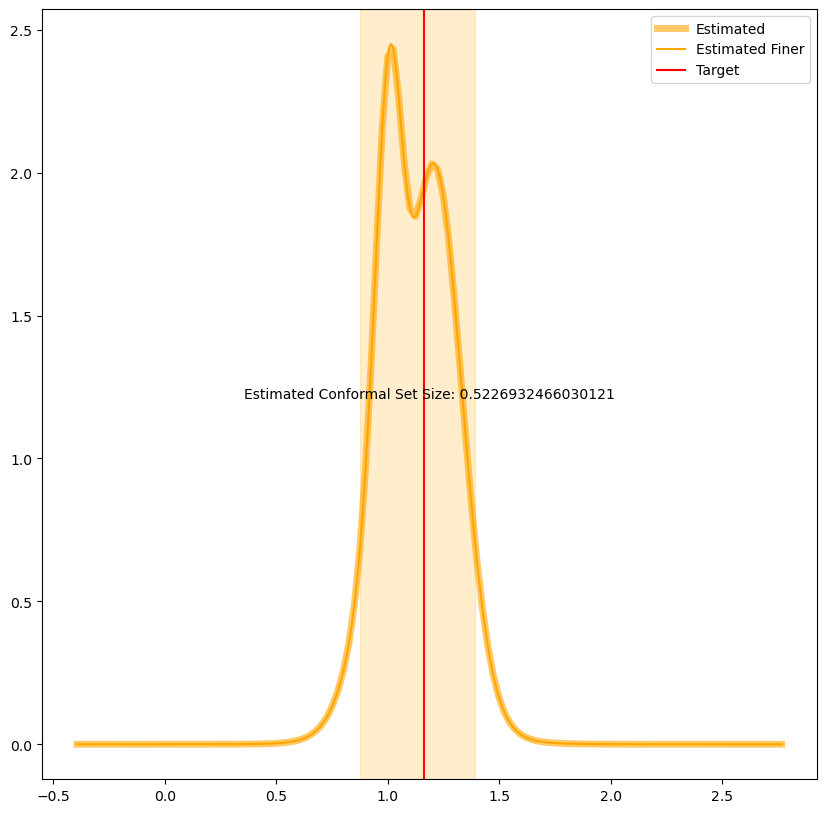

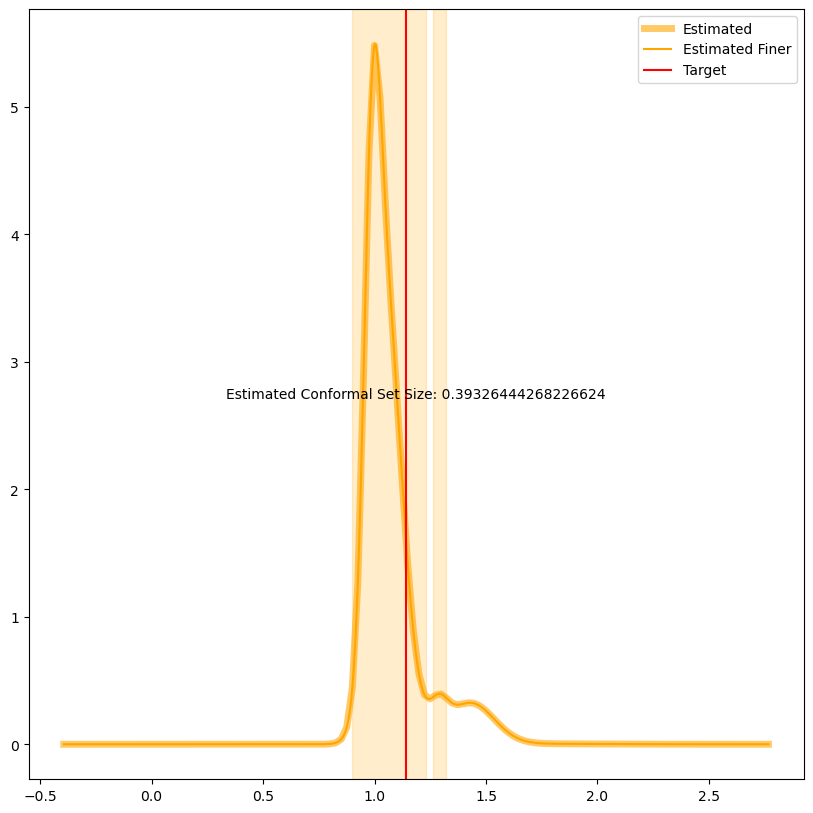

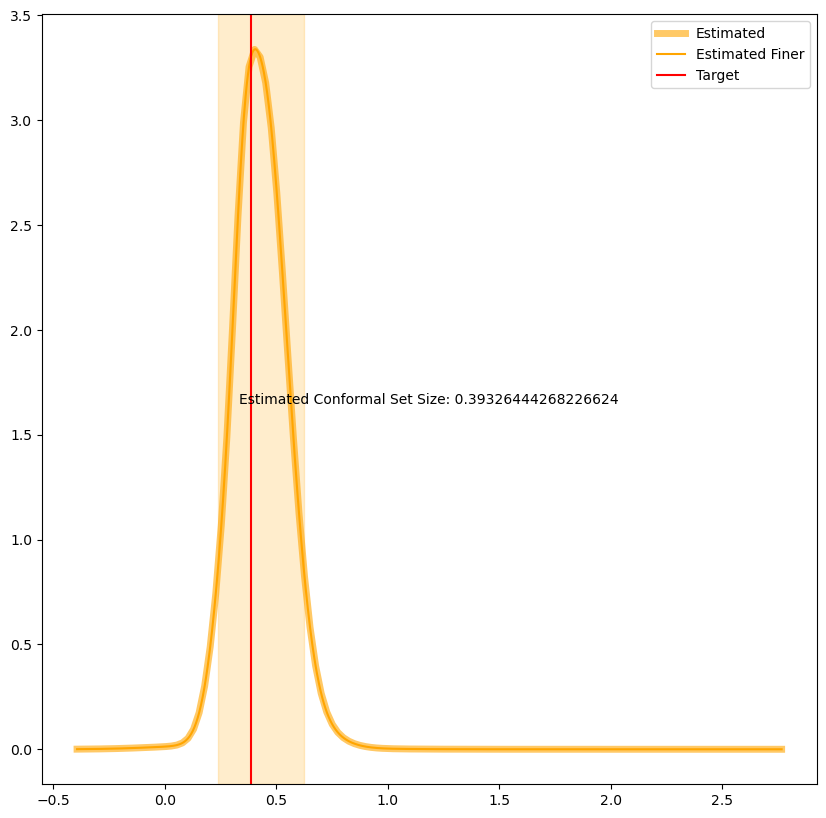

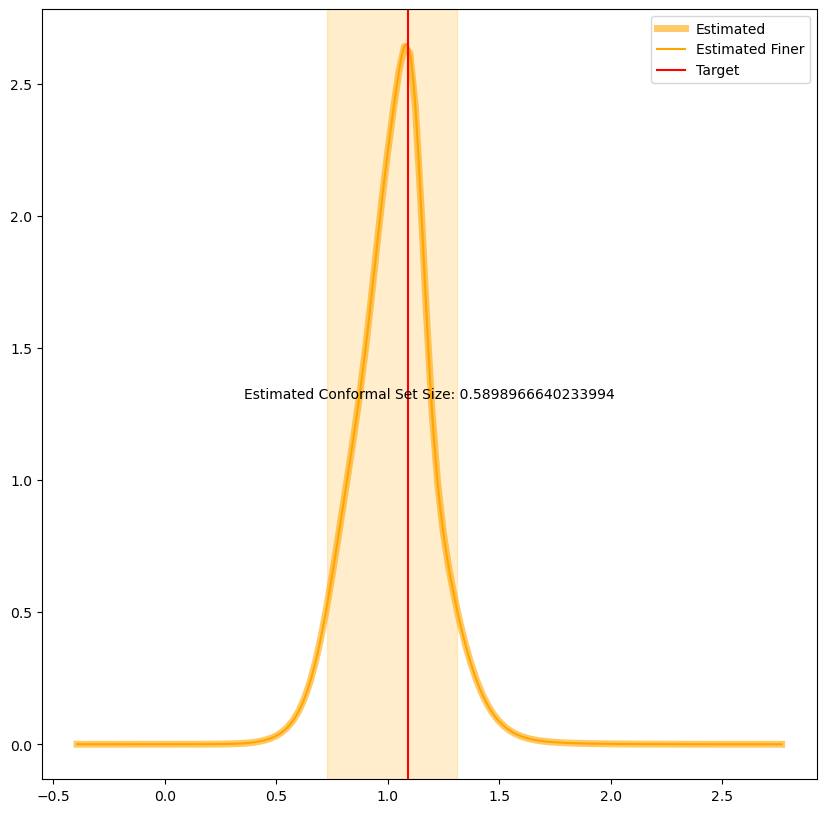

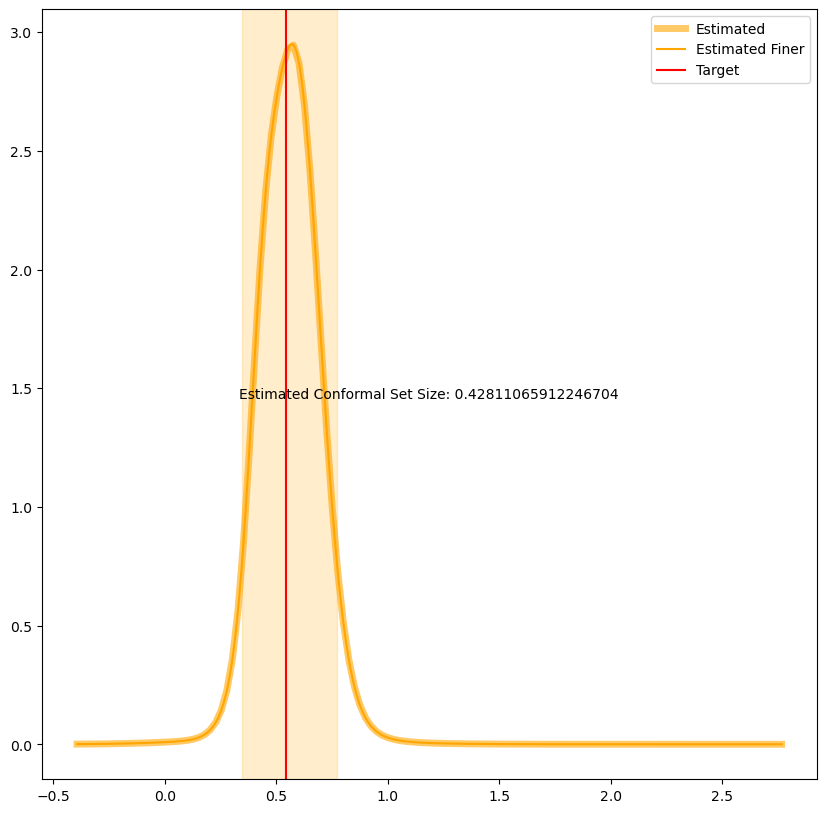

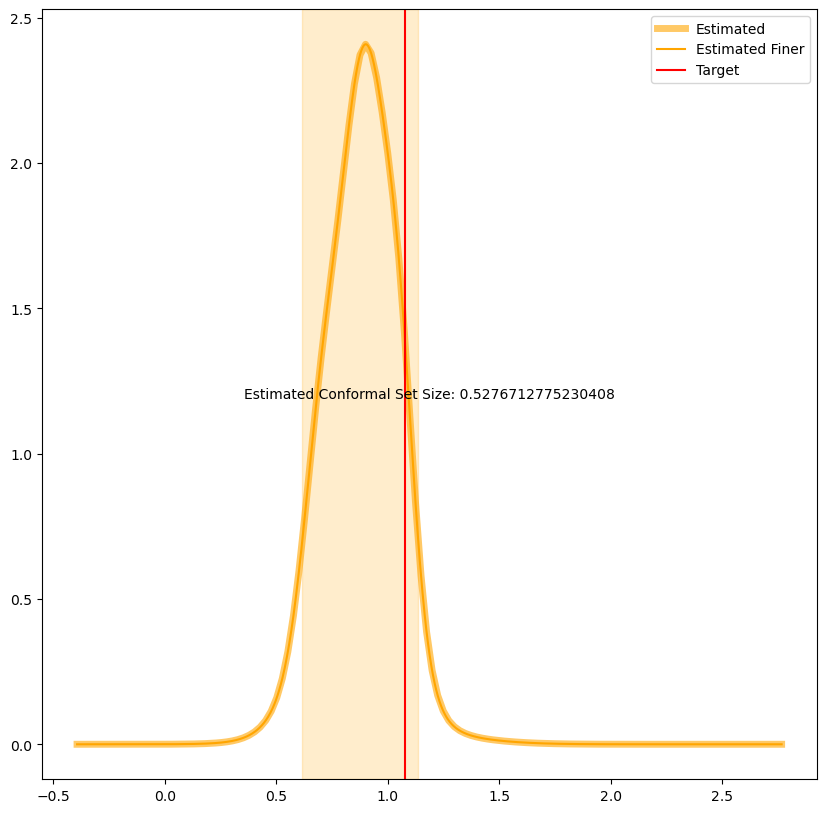

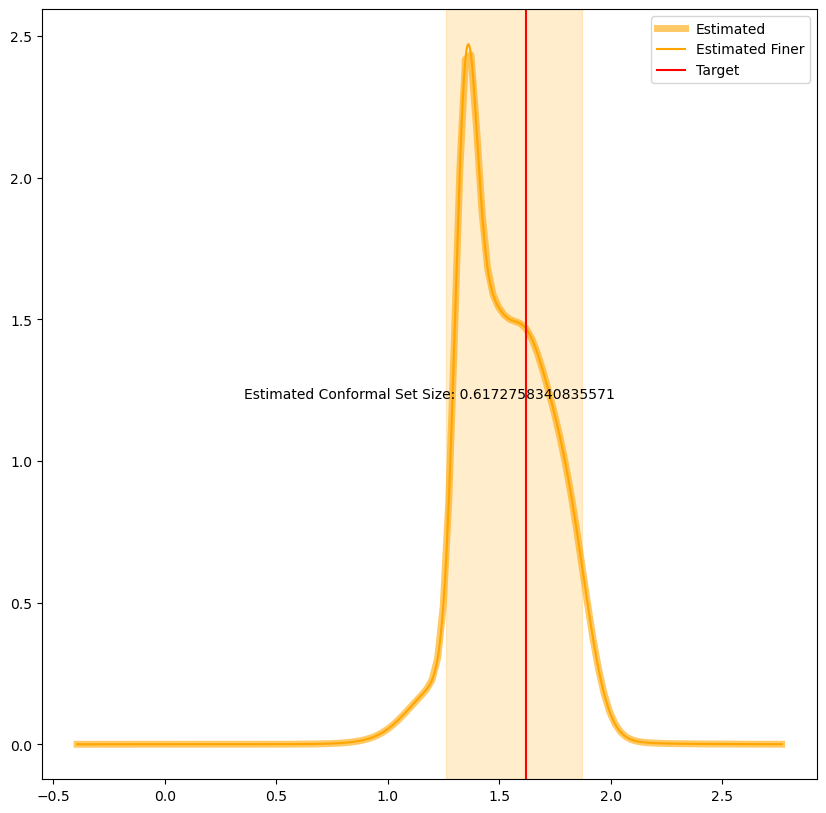

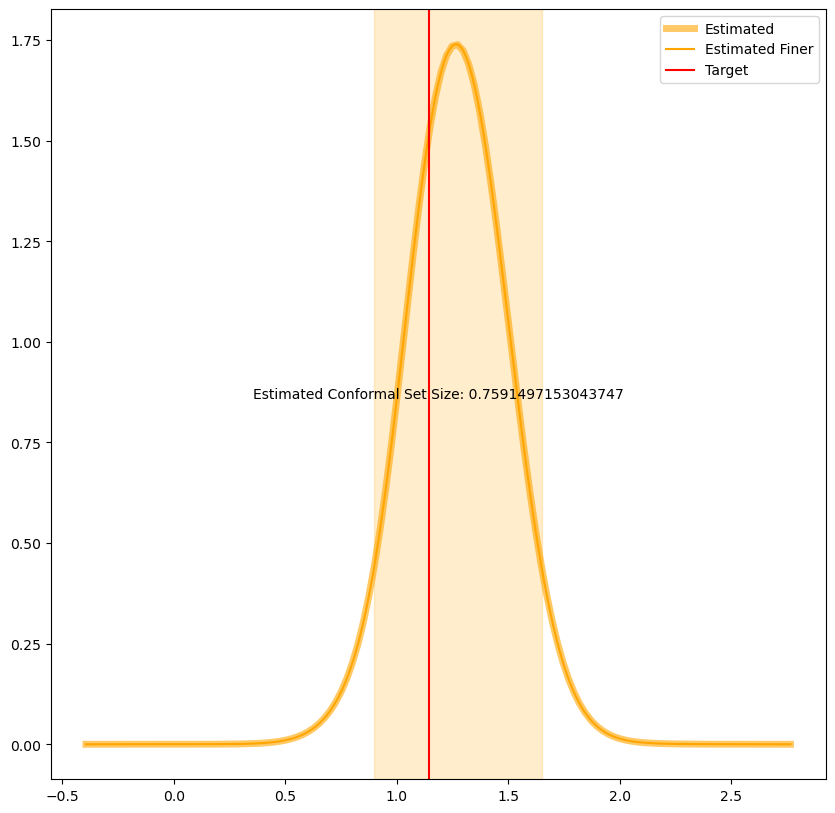

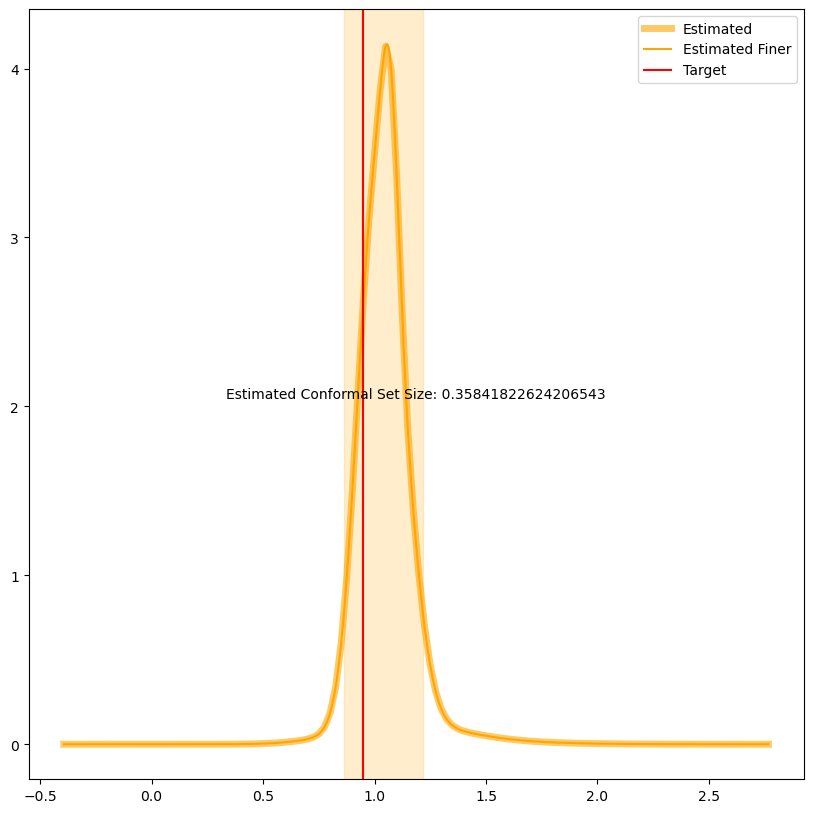

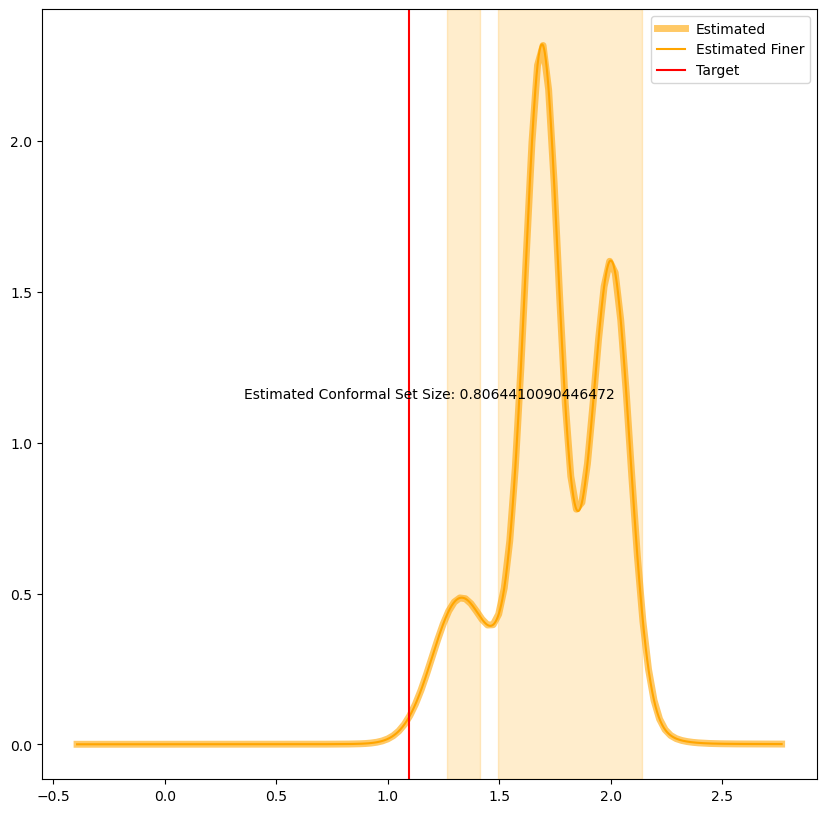

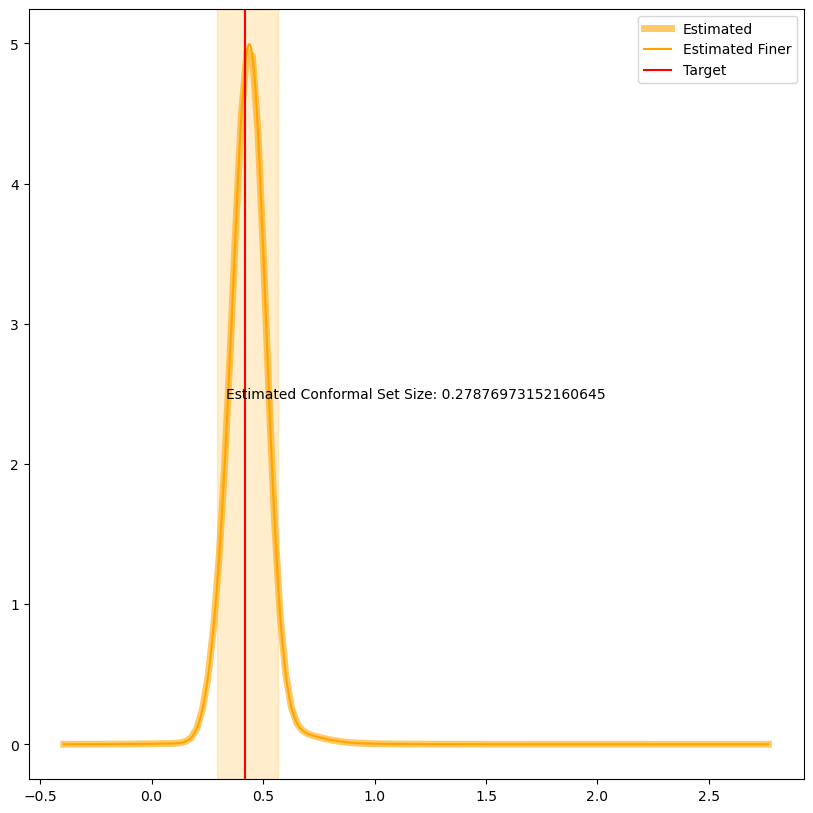

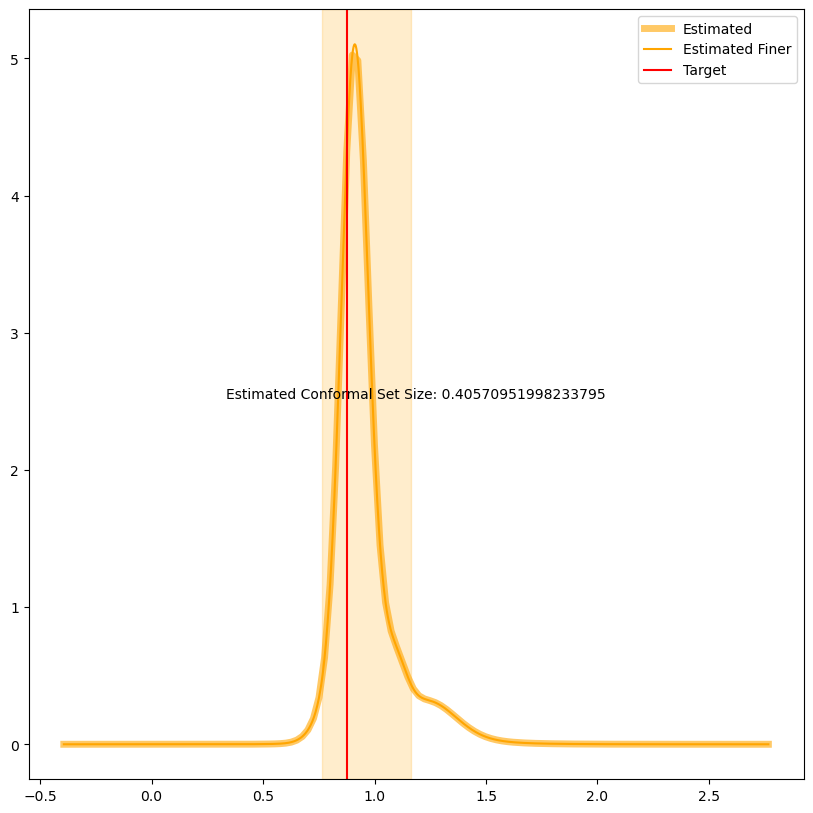

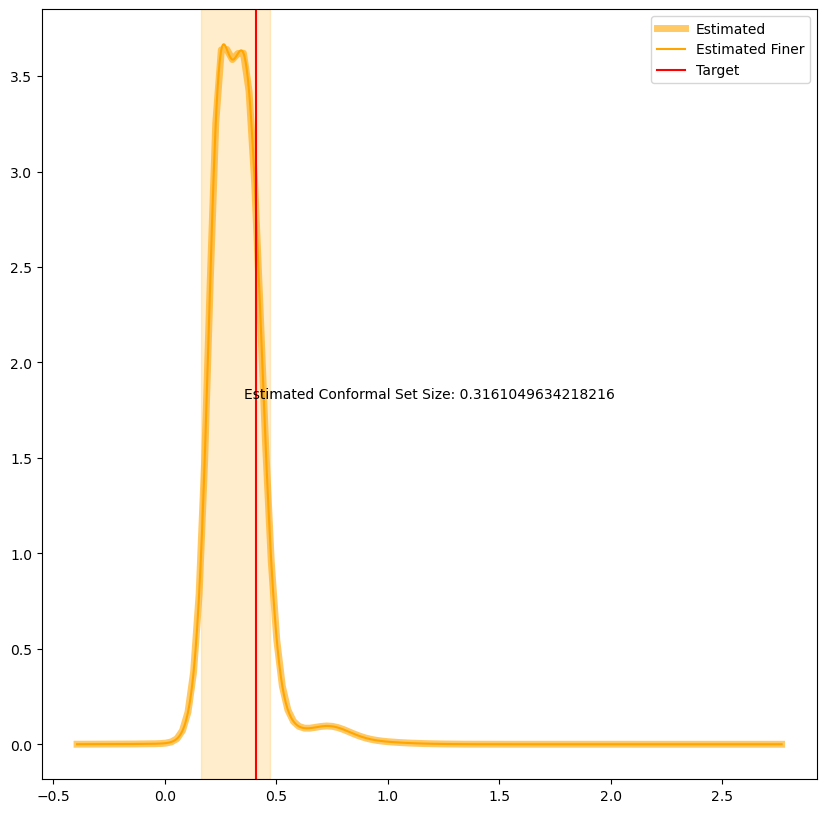

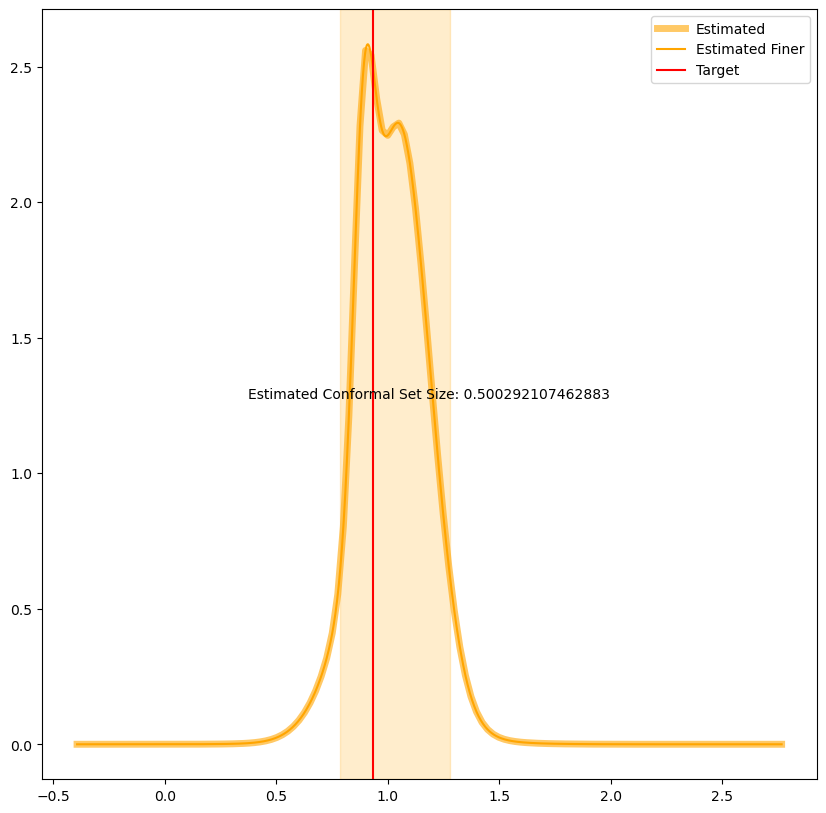

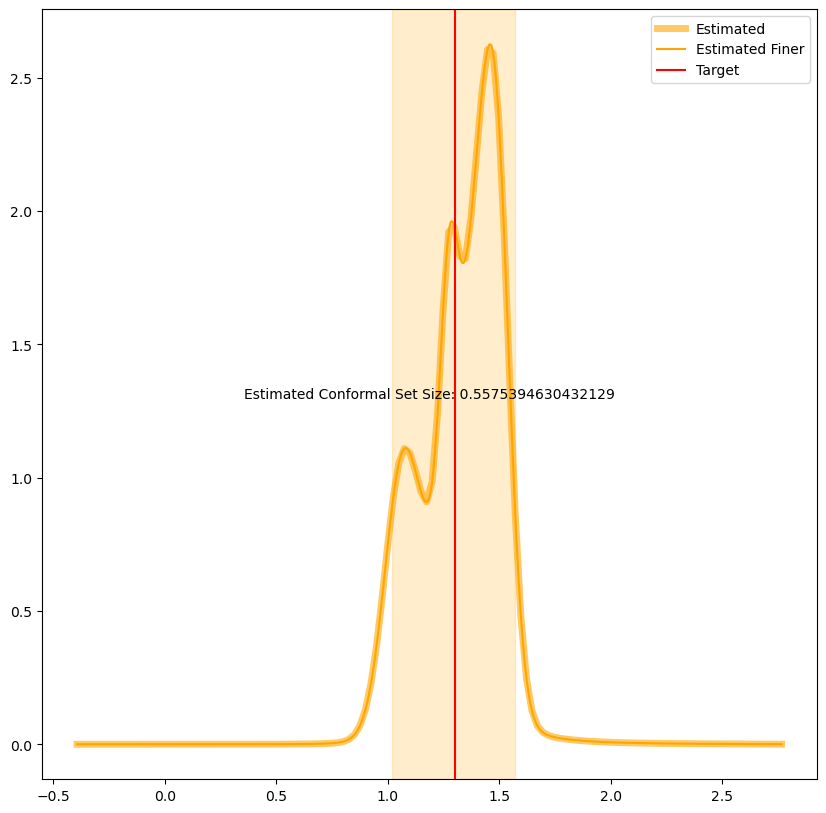

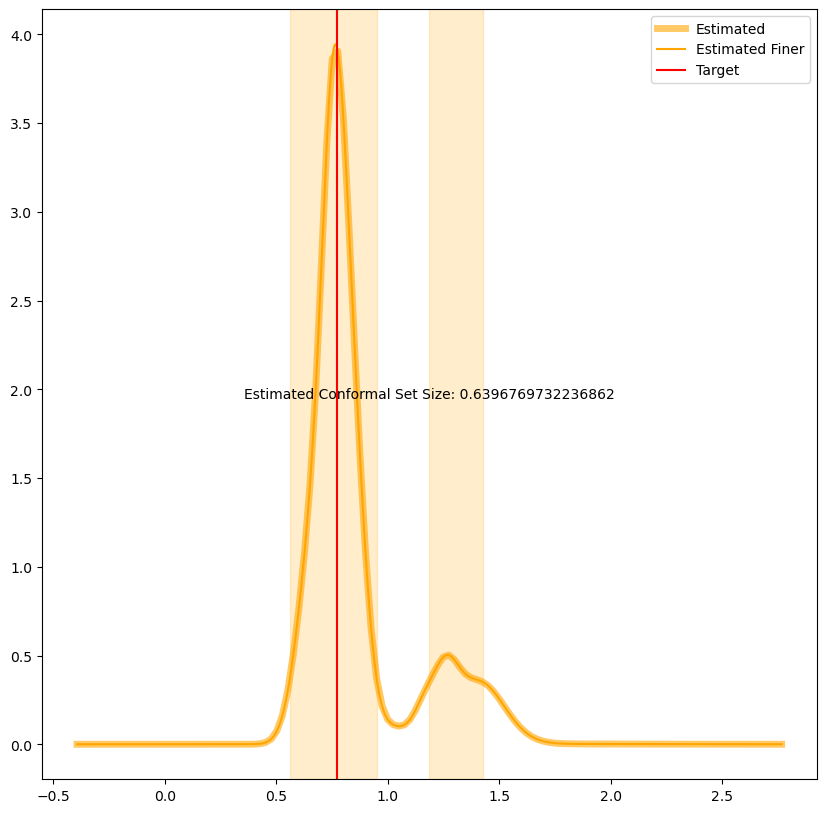

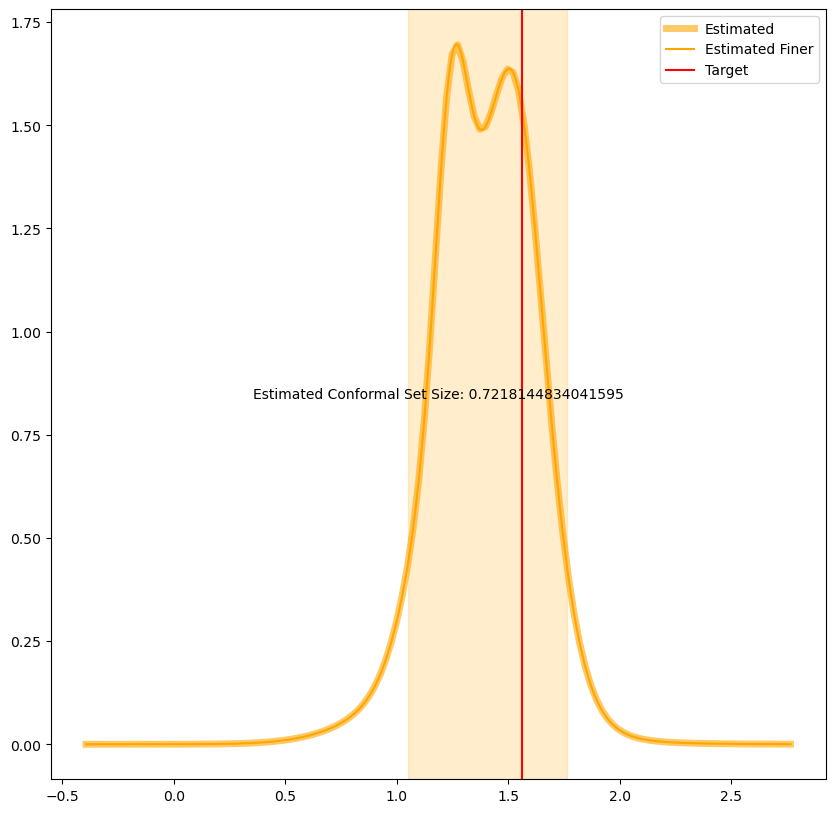

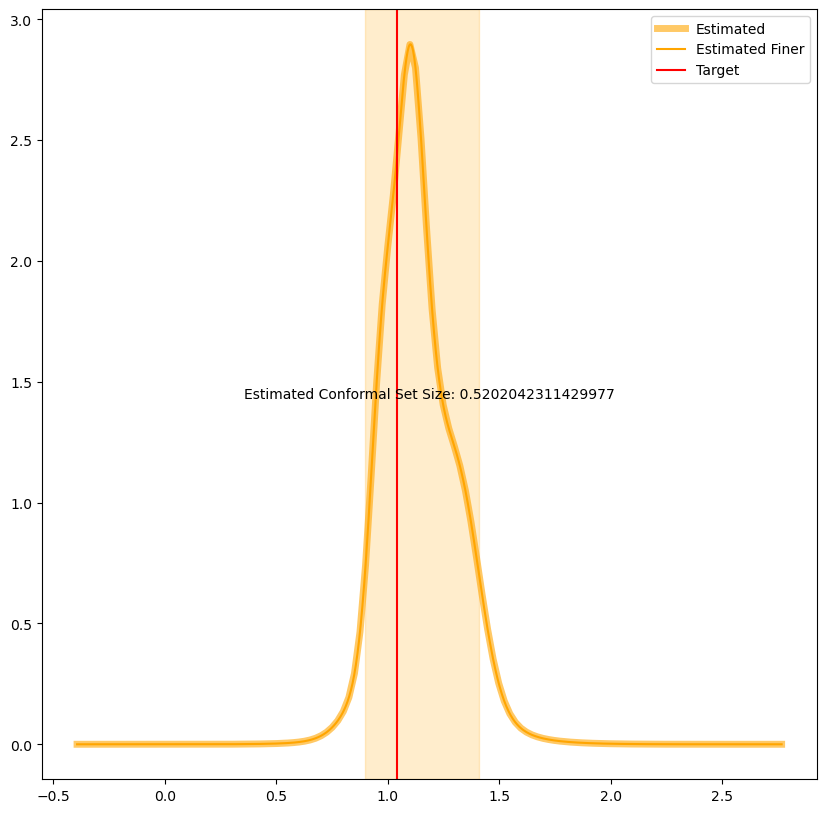

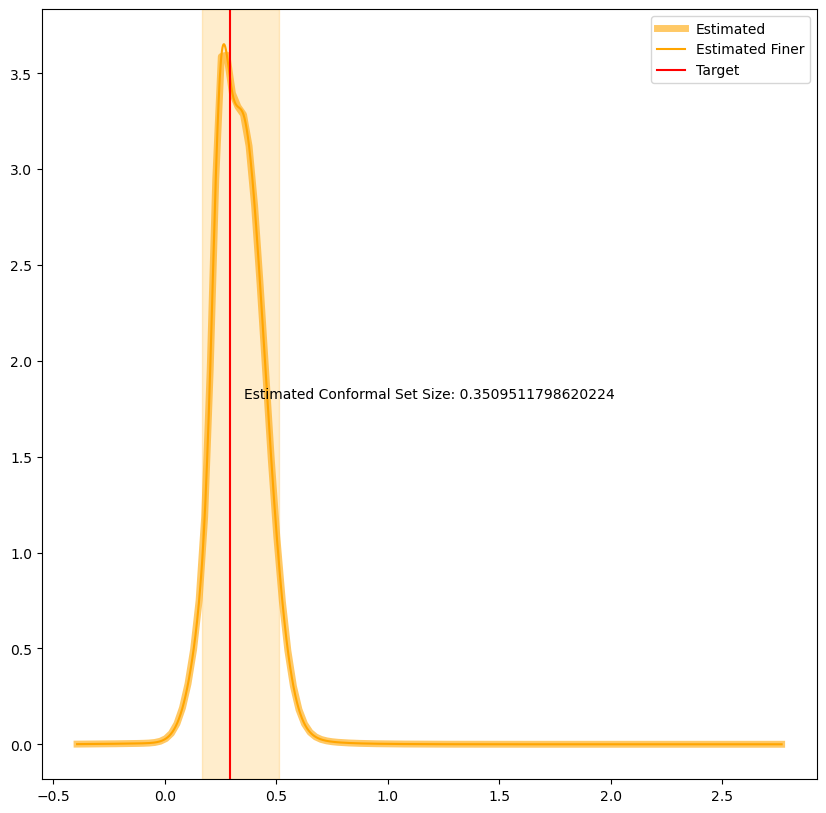

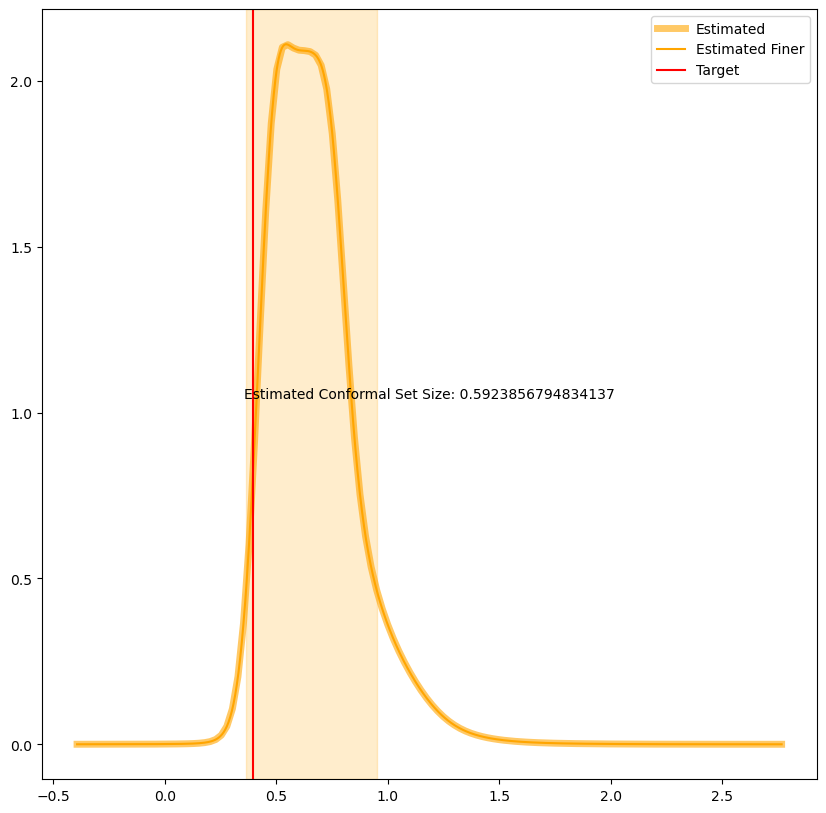

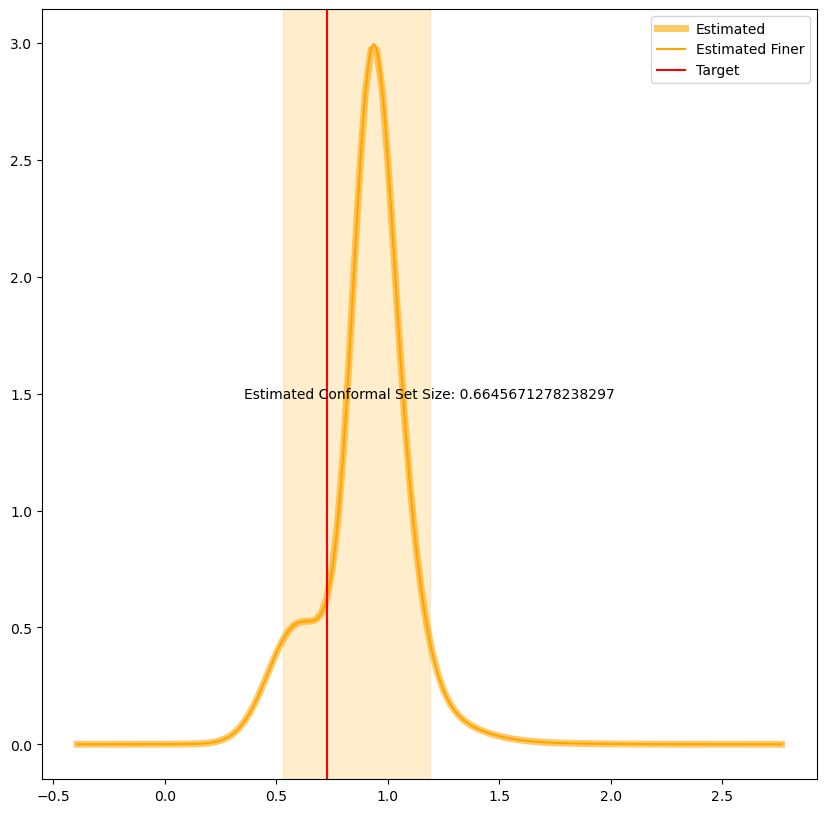

100%|██████████| 3/3 [00:29<00:00,  9.98s/it]


In [21]:
test_loader = dm.get_test_dataloader(64, shuffle=False)
model.eval()

target_std = dm.train_dataset.std_y

if has_true_distribution:
    y_space = training_dm.y_space
    y_space = torch.tensor(y_space, device=device).view(-1, 1)
else:
    y_space = torch.linspace((dm.train_dataset.y.min() - dm.train_dataset.std_y).item(), (dm.train_dataset.y.max() + dm.train_dataset.std_y).item(), 128).to(device).view(-1, 1)

num_steps = y_space.shape[0]
step_size = (y_space[1] - y_space[0]).abs()

estimated_conformal_set_sizes = []
target_in_conformal_set = []

for batch in tqdm(test_loader):

    if has_true_distribution:
        x_batch, y, densities = batch
    else:
        x_batch, y = batch

    precomputed_variables = model(x_batch.to(device), y.to(device))

    for idx in range(x_batch.shape[0]):
        x_space = x_batch[idx].unsqueeze(0).expand(num_steps, -1)

        if precomputed_variables:
            to_pass_precomputed_variables = make_to_pass_precomputed_variables(
                precomputed_variables, num_steps, idx
            )
            estimated_densities = model.get_density(
                x_space, y_space, False, **to_pass_precomputed_variables
            )
        else:
            estimated_densities = model.get_density(x_space, y_space, False)

        y_space_np = y_space.flatten().cpu().detach().numpy()
        y_space_fine = torch.linspace(
            y_space_np.min(), y_space_np.max(), num_steps * finer_factor
        )

        # conformal set true
        if has_true_distribution:
            densities_np = densities[idx].cpu().detach().numpy()
            interp = interp1d(y_space_np, densities_np, kind="linear")

            densities_fine = torch.from_numpy(interp(y_space_fine.numpy()))

            densities_fine_normalized = densities_fine / densities_fine.sum()
            sorted_indices = torch.argsort(densities_fine_normalized, descending=True)
            cumulative_sum = torch.cumsum(densities_fine_normalized[sorted_indices], dim=0)
            conformal_set = sorted_indices[cumulative_sum < conformal_p]

            sorted_conformal_set = torch.sort(conformal_set)[0]
            diff = sorted_conformal_set[1:] - sorted_conformal_set[:-1]
            breaks = torch.where(diff != 1)[0] + 1
            breaks = torch.cat(
                (torch.tensor([0]), breaks, torch.tensor([len(sorted_conformal_set)]))
            )

            starts = sorted_conformal_set[breaks[:-1]]
            ends = sorted_conformal_set[breaks[1:] - 1]

            conformal_set_size = len(conformal_set) * step_size.item() / finer_factor

        # conformal set estimated
        estimated_densities_np = estimated_densities.cpu().detach().numpy()
        interp = CubicSpline(y_space_np, estimated_densities_np)
        estimated_densities_fine = torch.from_numpy(interp(y_space_fine.numpy()))

        estimated_densities_fine_normalized = (
            estimated_densities_fine / estimated_densities_fine.sum()
        )
        sorted_indices = torch.argsort(estimated_densities_fine_normalized, descending=True)
        cumulative_sum = torch.cumsum(
            estimated_densities_fine_normalized[sorted_indices], dim=0
        )
        estimated_conformal_set = sorted_indices[cumulative_sum < conformal_p]

        sorted_conformal_set = torch.sort(estimated_conformal_set)[0]
        diff = sorted_conformal_set[1:] - sorted_conformal_set[:-1]
        breaks = torch.where(diff != 1)[0] + 1
        breaks = torch.cat(
            (torch.tensor([0]), breaks, torch.tensor([len(sorted_conformal_set)]))
        )

        estimated_starts = sorted_conformal_set[breaks[:-1]]
        estimated_ends = sorted_conformal_set[breaks[1:] - 1]

        append_target_in_conformal_set = False
        for start, end in zip(y_space_fine[estimated_starts], y_space_fine[estimated_ends]):
            if start <= y[idx].flatten().item() <= end:
                append_target_in_conformal_set = True
                break
        target_in_conformal_set.append(append_target_in_conformal_set)

        estimated_conformal_set_size = len(estimated_conformal_set) * step_size.item() / finer_factor
        estimated_conformal_set_sizes.append(estimated_conformal_set_size)
        
        if draw_plot:
            plt.figure(figsize=(10, 10))
            plt.plot(
                y_space_np,
                estimated_densities_np,
                label="Estimated",
                lw=5,
                alpha=0.6,
                c="orange",
            )
            plt.plot(
                y_space_fine, estimated_densities_fine, label="Estimated Finer", c="orange"
            )
            plt.axvline(y[idx].flatten().item(), c="red", label="Target")
            if has_true_distribution:
                plt.plot(y_space_np, densities_np, label="True", lw=5, alpha=0.6, c="green")
                plt.plot(y_space_fine, densities_fine, label="True Finer", c="green")
                for start, end in zip(y_space_fine[starts], y_space_fine[ends]):
                    plt.axvspan(start, end, alpha=0.2, color="green")

            for start, end in zip(y_space_fine[estimated_starts], y_space_fine[estimated_ends]):
                plt.axvspan(start, end, alpha=0.2, color="orange")

            if has_true_distribution:
                plt.text(
                    0.5,
                    0.5,
                    f"True Conformal Set Size: {conformal_set_size}\nEstimated Conformal Set Size: {estimated_conformal_set_size}",
                    horizontalalignment="center",
                    verticalalignment="center",
                    transform=plt.gca().transAxes,
                )
            else:
                plt.text(
                    0.5,
                    0.5,
                    f"Estimated Conformal Set Size: {estimated_conformal_set_size}",
                    horizontalalignment="center",
                    verticalalignment="center",
                    transform=plt.gca().transAxes,
                )
            plt.legend()
            plt.show()

In [23]:
print("Coverage Original Scale", np.mean(estimated_conformal_set_sizes), np.mean(target_in_conformal_set))
#print("Coverage Standardized", np.mean(estimated_conformal_set_sizes) / target_std.item(), np.mean(target_in_conformal_set))

Coverage Original Scale 0.5410798446786019 0.8903225806451613
